# Stoneburner, Kurt #
- ## DSC 550 - Week 07
- ## Milestone #4

### Current Project Notes: ###
**Primary Goal**: Model Racial COVID numbers at the county level. California provides County COVID data in terms of total case data. I want to model the racial makeup of those case. Example: If there were 100 COVID cases, I want to estimate the Latino, White, Black and Asian cases for the county on a given day.

My approach involves running a multivariate Linear Regression on a block of 30 days for each racial category. For example, I built a dataframe where each county was a column. This puts an entire days worth of COVID cases into a single row. Regression was run against the county numbers trying to predict the state wide race numbers. To determine an individual counties racial portion of the total, I took the resulting weighted coefficients and converted them to percentages. Since coefficients could be negative, I struggled with the conversion process. After much failure, I reached back to DSC510, and squared the coefficients then divided by the target value. 

Basic Model:
Linear regression predicting Statewide totals for each Race (Black, White, Asian, etc) using the county COVID cases for the day. Each regression coefficient is multiplied by the county total (Los Angeles, Imperial, Alameda, etc.) which generates a weighted coeffficent which represents each individual county's portion of the racial total on a given day. The weighted coefficients are converted to percentages by squaring the coefficients (to remove negative values), which are divided by the sum total of race cases. This generates a percentage of race cases per county, per day. The total racial cases is multiplied by the county percentages to generate a racial distribution per county, per day.

Steps:
1. Build weighted coefficents per county/day
1. Convert coefficients to racial percentages per county/day
1. Multiply county percentage by the racial total to generate modeled value

I believe I have this process working fairly well. However, I went through an awful lot of effort to determine Linear Regression is not a good fit for modeling this type of data. It is the only model that I was able to generate percentages from the coefficients. I started working on a forest regression model which hints at better results. I'm currently stuck on converting the forest importances to relative percentages. Which is assuming that is even possible. I'd like to look at support vector regression as well. Due to time constraints I'm planning on sticking with the Linear Regression model which works, even if it doesn't work well. 

The first issue with the Linear Regression model, is the order of the variables greatly influences the model. The first attribute applies the greatest weight, each successive value applies less and less weight. I attempted to weight the regression using population percentages without success. I may continue to explore a weighting feature, time permitting.

The resulting model, overestimates the populations for Los Angeles county, and underestimates for the rest. This is not obvious when looking at the numbers directly. But becomes apparent if all the racial values for a county are summed and compared to the total actual cases. This revealed the models flaw which appears to be based around an exponential distribution of racial cases. The total error distribution by county looks similar to a Pareto distribution. Which is another way of saying, "Not Good." In order to get something useable, I rescaled the modeled data to match the actual results. For Example: Los Angeles total racial COVID cases were over estimated by 67%. I subtracted 67% across all the Los Angeles data. Using the same technique, I scaled up the remaining counties. I'm not happy with the resulting values but they do seem to lie with the range of plausibility when dealing with counties that have populations over 100,000. The numbers get weird with low racial populations and counties with low population in general. 

On the whole, I'm proud of what I accomplished. I've created a fairly flexible coding pipeline. This helps speed up iterative testing. I worked hard to get all the numbers to balance. The State wide Racial COVID totals, did not equal the statewide total cases for the day, which did not equal the sum the county reported cases. I assumed this data was equal since it came from an official source. I burned a lot of calories troubleshooting my workflow before I realized the reason my numbers didn't add up, was due to my source numbers not adding up. Part of the issue is due to the nature of reporting. Daily COVID values change retroactively as positive tests are reported this is due to the lag between testing and reporting. The cases column is adjusted to show the estimated cases on that given day. I'm unsure if the other categories where treated similarly. I'm supposing not. I chose to base my COVID totals off the summed county data. This ensures are totals are equivalent. I rescaled the Statewide Racial totals to the summed county totals and  generated a daily percentage from the reported racial COVID cases. Additionally, I generated new racial totals from the summed county totals. This matched the state racial totals with the daily county totals.

It's interesting to compare the modeled versus the expected values. The difference between modeled and expected indicates a racial disparity in COVID distribution. In almost every county, Latinos have more COVID cases than their representative populations. It's the exact opposite for Whites, who are generally under-represented. These values are reflected in the Statewide totals.

![title](z_mile_3_modeled_vs_expected_1.png)


Work on full report writeup


In [1]:
#Look at Support Vector Regression
#https://www.mygreatlearning.com/blog/support-vector-regression/

In [2]:
import os
import sys
# //*** Imports and Load Data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
#//*** Use the whole window in the IPYNB editor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import time 
import random

#//*** Maximize columns and rows displayed by pandas
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

pd.set_option('display.width', 200)

df_list = []

In [3]:
from sklearn import linear_model
from math import sqrt
from sklearn.metrics import mean_squared_error

In [4]:
# //*** Legends automatically generate too many labels based on my looping method.
# //*** Remove the Duplicate Legends. I wrote this for DSC 530 and it keeps on giving.
def deduplicate_legend(input_ax):
    # //**** Get handle and label list for the current legend
    # //**** Use first instance, toss the rest.
    handles, labels = input_ax.get_legend_handles_labels()

    handle_dict = {}

    for x in range(len(labels)):
        if labels[x] not in handle_dict.keys():
            # //*** Label = handle
            handle_dict[labels[x]] = handles[x]

    # //*** Build unique output ists and handles
    out_handles = []
    out_labels = []
    
    for label,handle in handle_dict.items():
        out_handles.append(handle)
        out_labels.append(label)
    
    return out_handles,out_labels

   

In [5]:
#//***************************************************************************************************************************************************************************
#//*** Generatate a Individual Race Coeffecients for each county per day.
#//*** The the sum of racial coefficients should equal the state coefficent for the county. 
#//*** Build the coefficients for the entire data set. Each day will calculate the coefficients from the previous 30 days. The First 30 days will use one set of coeffients. The rest will use
#//*** The current day: -30 to generate the coefficients. This will be an overfitted solution which is exactly what we are going for.
#//***************************************************************************************************************************************************************************
def calculate_coefficients(left_df, right_df, x_col_index, y_col_index):
    print("Calculating racial coefficients...")
    start_time = time.time()
    
    #//*** Initialize the output dataframe
    output_df = pd.DataFrame()
    
    #//*** Combining with car_race_df and Latino value. It's not strictly needed, but the additional column will make combining the dataframes later, easier.
    #//*** Reusing Code: This loop only needs to run once
    for race in left_df.columns[1:]:

        #//*** Build model for the first 30 days, combines the race from ca_race (which is only needed as an extra field, to evenly space the columms)
        model_df = left_df[['date',race]].merge(right_df, left_on='date', right_on='date')[:30]

        #//*************************
        #//*** BEGIN regression
        #//*************************


        #//**** Build the x Values - Dependent Variables. These will be all the counties which start at the column index 
        #//*** The X Value is the index where the attributes start, there are 58 of them :)
        #x_column = model_df.columns[x_col_index:]

        #//*** Generate ordered list of Counties by current race population.
        #//*** The assumptions is the counties with higher populations will exert a greater weight on the model.
        #//*** Otherwise the tiny county of Alpine gets way overly represented
        race_columns = (pop_attrib_df[['county',race]].sort_values(race,ascending=False)['county'])

        #print(model_df[race_columns])
        #//*** Build the X attributes using the x_column. These are separated for readability and modularity
        x_model = model_df[race_columns]

        #print(x_model)
        #//*** Build the independent variable using the Index Column defined above as y_col_index.
        y_column = model_df.columns[y_col_index]

        #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
        #//*** easily assigned at the top of this section
        y_model = model_df[y_column]

        #//*** Define the Linear Model
        regr = linear_model.LinearRegression(n_jobs=-1)

        #//*** Make Regression Magic
        regr.fit(x_model, y_model)

        #//*** Apply the regression coefficients
        #//*** v1 Change: Apply coef to actual values
        model_df[race_columns] = (model_df[race_columns])*regr.coef_
        
        
        #//*** Dead End: v2 Change: Try just the coefficients 
        #model_df[race_columns] = regr.coef_



        #//*** Replace the Statewide Total Column. With the Statewide Race Totals
        model_df['total'] = model_df[race]

        #//*** Change The race column to hold the race name
        model_df[race] = race

        #//*** Rename the race (Latino, Native, etc) to 'race'
        cols = list(model_df.columns)
        cols[1] = 'race'
        model_df.columns = cols

        model_df['intercept'] = regr.intercept_

        #//*** Move intercept to be the column after Total
        #//*** Gets Columns as a list, removes intercept of end and inserts into position
        #//*** Model_df is saved with ordered list of columns.
        #//*** Kinda Cool
        model_df = model_df[ list(model_df.columns[:-1].insert(3,'intercept')) ]

        #//*** Reorder Counties
        #//*** Keep the First four Columns, then use ordered_counties
        model_df = model_df[list(model_df.columns[:4])+ordered_counties]

        #print(model_df)
        #//*** Add the First 30 days Model to the output_df dataframe
        output_df = pd.concat([output_df,model_df])

        #//*** Checking our work. The sum of the coefficients * cases + intercept should be close the independent value in Total Cases.
        print("Checking our Work. These values should be close:")
        print(model_df.iloc[1]['total'], " == ", model_df[race_columns].iloc[1].sum()+regr.intercept_)    

        #print(model_df)
        
        #break
        #//*** Build each day individually, based on the previous 30 days
        #//*** Start at index 31 
        for index in range(31,len(left_df)+1):

            #//*** Define the start and indexes for linear modeling. This is the row_index - 30
            min_index = index-30

            #//*** Build model_df using min_index and index as a 30 day range)
            model_df = left_df[['date',race]].merge(right_df, left_on='date', right_on='date')[min_index:index]
            
            #//*** Build the X attributes using the x_column. These are separated for readability and modularity
            x_model = model_df[race_columns]

            #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
            #//*** easily assigned at the top of this section
            y_model = model_df[y_column]

            #//*** Build a New the Linear Model
            regr = linear_model.LinearRegression(n_jobs=-1)

            #//*** Make Regression Magic
            regr.fit(x_model, y_model)

            #//*** Replace the Statewide Total Column. With the Statewide Race Totals
            model_df['total'] = model_df[race]

            #//*** Change The race column to hold the race name
            model_df[race] = race

            #//*** Rename the race (Latino, Native, etc) to 'race'
            cols = list(model_df.columns)
            cols[1] = 'race'
            model_df.columns = cols

            #//*** Apply the regression coefficients to all columns, even though we only need the last one
            #//*** v1 Change: Apply coef to actual values
            model_df[race_columns] = (model_df[race_columns])*regr.coef_

            #//*** Dead End: v2 Change: Try just the coefficients
            #model_df[race_columns] = regr.coef_

            model_df['intercept'] = regr.intercept_

            #//*** Move intercept to be the column after Total
            #//*** Gets Columns as a list, removes intercept of end and inserts into position
            #//*** Model_df is saved with ordered list of columns.
            #//*** Kinda Cool
            model_df = model_df[ list(model_df.columns[:-1].insert(3,'intercept')) ]

            #//*** Reorder Counties
            #//*** Keep the First four Columns, then use ordered_counties
            model_df = model_df[list(model_df.columns[:4])+ordered_counties]

            #//*** Add the last day of model_df to output_df. 
            #//*** It's not exactly efficient, but it is functional
            #output_df = pd.concat([output_df,model_df.iloc[-1]])
            output_df = output_df.append(model_df.iloc[-1])
    
    print(f"CoEfficients Calculated: {round(time.time()-start_time,0)}s")
    return output_df


In [6]:

#//************************************************
#//*** Convert Coefficients to percentages
#//************************************************
#//*** Racial Coefficients are built for each race by day and county.
#//*** Group output_df by date, to calculate the race percent for each county by day.
#//*** The Racial Percentage is

def coef_to_percent(input_df,x_col_index):

    start_time = time.time()



    x_column = processing_df.columns[x_col_index:]

    output_df = pd.DataFrame()

    for row in processing_df.iterrows():


        loop_row = row[1]


        #total = row[1][2]
        #print("Total: ",total)
        #intercept = row[1][3]
        #print("Intercept: ",total-intercept)
        #loop_row[4:] = loop_row[4:]

        #//*** Square the results to remove negative values
        loop_row[4:] = loop_row[4:]**2
        
        #//*** Avoid Divide by Zero issues
        if loop_row[4:].sum() > 0:
            #//*** Divide by the sum to get relative percentages
            loop_row[4:] = loop_row[4:]/loop_row[4:].sum()
        
        #//*** Multiply by the total to get the weighted percentage of racial values
        loop_row[4:] = loop_row[4:]*loop_row['total']
        
        #//*** Add the row to the output_df
        output_df = pd.concat([output_df,pd.DataFrame(loop_row).transpose()])

    #//*** Reindex with an integer. Keeps it clean
    output_df.index = np.arange(0,len(output_df))
    
    #//*** Zero, values generate Divide by Zero NaNs. Replace these with Zero
    output_df = output_df.fillna(0)

    print(f'Racial Percentages Calculated: {round(time.time()-start_time,0)}s')
    
    return output_df





In [7]:
#//*** Only download Data if download_data is True.
#//*** Avoids needlessly generating HTTP traffic
download_data = False
demographic_data_filename = "z_ca_covid_demo.csv"
cases_data_filename = "z_ca_covid_cases.csv"

#//***********************************************************************************************
#//*** California COVID Data website:
#//**************************************
#//*** https://data.chhs.ca.gov/dataset/covid-19-time-series-metrics-by-county-and-state
#//***********************************************************************************************

#//*** Download California Current COVID Demograohic Data
if download_data:
    try:
        response = requests.get("https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/e2c6a86b-d269-4ce1-b484-570353265183/download/covid19casesdemographics.csv")
        if response.ok:
            print("Demographic Data Downloaded")
            f = open(demographic_data_filename, "w")
            f.write(response.text)
            f.close()
            print("Demographic Data Written to file.")
    except:
        print("Demographic Data: Trouble Downloading From State of CA")

#//*** Download California Current COVID Case Counts
    try:
        response = requests.get("https://data.chhs.ca.gov/dataset/f333528b-4d38-4814-bebb-12db1f10f535/resource/046cdd2b-31e5-4d34-9ed3-b48cdbc4be7a/download/covid19cases_test.csv")
        if response.ok:
            print("Case Data Downloaded")
            f = open(cases_data_filename, "w")
            f.write(response.text)
            f.close()
            print("Case Data Written to file.")
    except:
        print("Ca Case Data: Trouble Downloading From State of CA")

In [8]:
#//*** read Cached Data From Local files

#//*** Statewide per county COVID Cases
ca_covid_df= pd.read_csv(cases_data_filename)

#//*** Racial Totals
ca_race_df = pd.read_csv(demographic_data_filename)


#//*** df_list keeps track of all the dataframe names. The project is getting too big to keep in my head, so I need to keep references
if 'ca_covid_df' not in df_list:
    df_list.append('ca_covid_df')

if 'ca_race_df' not in df_list:
    df_list.append('ca_race_df')

print(ca_race_df.columns)
#//*** Demographics Contain Age Groups, Gender, and Race Ethnicity.

#//*** We'll Focus on just Race Ethnicicty
print(f"Demographic Types: {ca_race_df['demographic_category'].unique()}")

#//*** Get Just Race Ethnicity
race_category = ca_race_df['demographic_category'].unique()[2]

#//*** Remove the other demographic Types. If we are cool we'd be factoring in age and gender.
#//*** But not this time
ca_race_df = ca_race_df[ca_race_df['demographic_category'] == race_category]


Index(['demographic_category', 'demographic_value', 'total_cases', 'percent_cases', 'deaths', 'percent_deaths', 'percent_of_ca_population', 'report_date'], dtype='object')
Demographic Types: ['Age Group' 'Gender' 'Race Ethnicity']


In [9]:
#//*******************************
#//*** Clean Ca_COVID_df
#//*******************************

print(ca_covid_df)

ca_covid_df.rename( columns= {'area':'county'}, inplace=True)
print(f"# of counties before Cleaning: {len(ca_covid_df['county'].unique())}")

#//*** Convert Date Column to Date Type.
ca_covid_df['date'] =  pd.to_datetime(ca_covid_df['date'], infer_datetime_format=True)

#print(ca_covid_df[ ca_covid_df['area_type'] == 'State'])
ca_covid_df = ca_covid_df.sort_values('date')

#\\*** DROP ca_covd dates that are not included in ca_race_df




             date       area area_type  population  cases  deaths  total_tests  positive_tests  reported_cases  reported_deaths  reported_tests
0      2021-05-19    Alameda    County   1685886.0    0.0     0.0          NaN             NaN            73.0              6.0          7715.0
1      2021-05-19     Alpine    County      1117.0    0.0     0.0          NaN             NaN             0.0              0.0             1.0
2      2021-05-19     Amador    County     38531.0    0.0     0.0          NaN             NaN             0.0              0.0           124.0
3      2021-05-19      Butte    County    217769.0    0.0     0.0          NaN             NaN            34.0             -3.0           436.0
4      2021-05-19  Calaveras    County     44289.0    0.0     0.0          NaN             NaN             1.0              0.0           112.0
...           ...        ...       ...         ...    ...     ...          ...             ...             ...              ...         

In [10]:
#//*** Remove the 'Out Of State, Unknown and California listings
print(f"Length Before removing Out Of Country County: {len(ca_covid_df)}")
ca_covid_df = ca_covid_df[~ca_covid_df['county'].isin(['Out of state','Unknown','California'])]

print(f"# of counties After Cleaning: {len(ca_covid_df['county'].unique())}")


#//*** Replace NaN values with 0
for col in ca_covid_df.columns:
    ca_covid_df[col].fillna(0,inplace=True)
    
    

#//*** Drop Columns
dropcols = ['area_type','population','positive_tests','reported_cases','reported_deaths','reported_tests']
#dropcols = []
ca_covid_orig_df = ca_covid_df.copy()

if 'ca_covid_orig_df' not in df_list:
    df_list.append('ca_covid_orig_df')

for col in dropcols:
    if col in ca_covid_df.columns:
        del ca_covid_df[col]


Length Before removing Out Of Country County: 28914
# of counties After Cleaning: 58


In [11]:
### //****************************************
#//*** Cleanup ca_race_df  attributes
#//****************************************
print("Before Cleaning:")
print(ca_race_df)
if 'demographic_value' in ca_race_df.columns:
    #//*** Rename the California Racial names to matches the census derived attribute names in pop_attrib_df
    ca_race_df['demographic_value']=ca_race_df['demographic_value'].str.replace('Native Hawaiian and other Pacific Islander','Hawaiian')
    ca_race_df['demographic_value']=ca_race_df['demographic_value'].str.replace('Multi-Race','Multiracial' )
    ca_race_df['demographic_value']=ca_race_df['demographic_value'].str.replace('American Indian or Alaska Native','Native' ) 

#//*** rename the reported_date column
ca_race_df.rename( columns= {'report_date':'date','total_cases':'cum_cases','deaths':'cum_deaths'}, inplace=True)

#//*** Delete Columns
if 'demographic_category' in ca_race_df.columns:
    del ca_race_df['demographic_category']

if 'demographic_value' in ca_race_df.columns:
    print(ca_race_df['demographic_value'].unique())

#//*************************************
#//*** Cleanup Statewide COVID values
#//*************************************
if 'demographic_value' in ca_race_df.columns:
    ca_race_df.rename( columns= {'demographic_value':'race'}, inplace=True)

#//*** Convert date to datetime format.
ca_race_df['date'] =  pd.to_datetime(ca_race_df['date'], infer_datetime_format=True)

#//*** Remove Total and Other from Race Types. Total is Statewide infections, Other is other racial categories.
#ca_race_df = ca_race_df[~ca_race_df['race'].isin(['Other'])]

#//*** Save temp_race_total_df for later use
#temp_race_total_df = ca_race_df[ca_race_df['race']=='Total']

#//*** Remove values with total (statewide values)
ca_race_df = ca_race_df[~ca_race_df['race'].isin(['Other','Total'])]

print("After Cleaning:")
print(ca_race_df)

Before Cleaning:
     demographic_category                 demographic_value  total_cases  percent_cases  deaths  percent_deaths  percent_of_ca_population report_date
3930       Race Ethnicity  American Indian or Alaska Native           33            0.2       3             0.5                       0.5  2020-04-13
3931       Race Ethnicity  American Indian or Alaska Native           33            0.2       3             0.4                       0.5  2020-04-14
3932       Race Ethnicity  American Indian or Alaska Native           32            0.2       3             0.4                       0.5  2020-04-15
3933       Race Ethnicity  American Indian or Alaska Native           34            0.2       4             0.5                       0.5  2020-04-16
3934       Race Ethnicity  American Indian or Alaska Native           38            0.2       4             0.4                       0.5  2020-04-17
...                   ...                               ...          ...           

In [12]:
#//*** Synchronize dates between ca_covid_df and ca_race_df
#//*** Get first date of Race
first_date = ca_race_df.iloc[0]['date']
#//*** remove values from ca_covid before the date
ca_covid_df = ca_covid_df[ca_covid_df['date'] >= first_date].sort_values('date')

In [13]:
#print(ca_race_df)
#print(ca_covid_df)

In [14]:
#print(df_list)
#print(ca_covid_df)

In [15]:

#//**********************************************************************************************************************************
#//*** US Census data on Racial population by County in California
#//**********************************************************************************************************************************
#//*** Data Source
#//**********************************************************************************************************************************
#//*** Census Data: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-counties-detail.html
#//*** Direct Download: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/asrh/cc-est2019-alldata-06.csv
#//**********************************************************************************************************************************
#//*** Process Flat File: California Ethnicity demographics - cc-est2019-alldata-06.csv

raw_ethnic_pop_df = pd.read_csv("cc-est2019-alldata-06.csv")

#//*** Data includes values for last twelve years. We only want data for the last year.

#//*** Rebuild raw_ethnic_pop_df using only the last year (most recent) data
raw_ethnic_pop_df = raw_ethnic_pop_df[raw_ethnic_pop_df['YEAR']==raw_ethnic_pop_df['YEAR'].max()]
if 'raw_ethnic_pop_df' not in df_list:
    df_list.append('raw_ethnic_pop_df')
#//*** Ethnic data is broken down by age. At this stage we will only use the totals of all ages
#//*** Only use AGEGRP == 0
raw_ethnic_pop_df = raw_ethnic_pop_df[raw_ethnic_pop_df['AGEGRP']==raw_ethnic_pop_df['AGEGRP'].min()]

#//*** Demographics are based on gender as well as Federal Race and Ethnic attributes. These attributes are different than the values reported
#//*** By the State of California. These attributes will require cleaning and transformation.
raw_ethnic_pop_df.head(20)


SUMLEV  STATE  COUNTY      STNAME              CTYNAME  YEAR  AGEGRP   TOT_POP  TOT_MALE  TOT_FEMALE  WA_MALE  WA_FEMALE  BA_MALE  BA_FEMALE  IA_MALE  IA_FEMALE  AA_MALE  AA_FEMALE  NA_MALE  \
209       50      6       1  California       Alameda County    12       0   1671329    823247      848082   414416     409177    88167      96201     9048       8749   259991     280400     7534   
437       50      6       3  California        Alpine County    12       0      1129       609         520      424        343        0          4      146        144       11          7        0   
665       50      6       5  California        Amador County    12       0     39752     21638       18114    19053      16583      955        111      554        371      318        347       61   
893       50      6       7  California         Butte County    12       0    219186    108473      110713    92754      94988     2316       1842     2730       2817     5461       5523      316   
1121      50      6       9  California     Calaveras County    12       0     45905     22847       23058    20794      20958      303        195      428        477      390        469       58   
1349      50      6      11  California        Colusa County    12       0     21547     10975       10572    10011       9619      164        118      312        282      152        185       63   
1577      50      6      13  California  Contra Costa County    12       0   1153526    564187      589339   372197     379086    52267      57797     5984       5725    99630     111488     3416   
1805      50      6      15  California     Del Norte County    12       0     27812     15186       12626    11674      10046      884         96     1415       1277      410        451       23   
2033      50      6      17  California     El Dorado County    12       0    192843     96158       96685    85557      85379     1142        858     1340       1234     4128       5189      223   
2261      50      6      19  California        Fresno County    12       0    999101    498648      500453   382292     382910    29301      28675    14838      14887    54900      56453     1422   
2489      50      6      21  California         Glenn County    12       0     28393     14462       13931    12881      12411      226        151      464        451      442        448       30   
2717      50      6      23  California      Humboldt County    12       0    135558     67241       68317    56089      56741     1161        857     4159       4478     1852       2078      231   
2945      50      6      25  California      Imperial County    12       0    181215     92878       88337    82621      80823     4317       1692     2216       2280     1967       1856      194   
3173      50      6      27  California          Inyo County    12       0     18039      9036        9003     7263       7141      136         83     1169       1267      143        164       18   
3401      50      6      29  California          Kern County    12       0    900202    461034      439168   379621     361338    30296      25986    11946      11772    23750      24529     1216   
3629      50      6      31  California         Kings County    12       0    152940     84342       68598    67356      56291     7772       3645     2574       2331     3301       3413      269   
3857      50      6      33  California          Lake County    12       0     64386     32194       32192    27976      28072      746        605     1454       1426      412        476       94   
4085      50      6      35  California        Lassen County    12       0     30573     19026       11547    14780       9960     2393        176      787        514      268        221      134   
4313      50      6      37  California   Los Angeles County    12       0  10039107   4949041     5090066  3552806    3545503   426817     472349    73361      70607   722516     822929    18174   
4541      50      6      3

In [16]:

#//*** Convert Applicable federal based census codes to California Census Codes.
#//*** Description of Federal Column Values
#//*** https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2019/cc-est2019-alldata.pdf
#//*** Census Data: https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/

#//*** Notably, Federal census regards Hispanic as an ethnicity not a race. For Example: People can be Hispanic White,
#//*** Hispanic Black, or Hispanic Asian.
#//*** California treats all hispanics as Latino
#//*** Latino = H_MALE, H_FEMALE Hispanic
#//*** White - NHWA_MALE, NHWA_FEMALE (Not Hispanic White)
#//*** Asian - NHAA_MALE, NHAA_FEMALE (Not Hispanic Asian) 
#//*** Black - NHBA_MALE, NHBA_FEMALE (Not Hispanic Black) 

#//*** Amer Indian - NHIA_MALE, NHIA_FEMALE (Not Hispanic, American Indian) 

#//*** Hawaiian - NHNA_MALE, NHNA_FEMALE (Not Hispanic, Hawaiian) 

#//*** California has the following columns: Multiracial, Other, Multirace. I could not find a good definition of these
#//*** These represent less than 5% of the population. Small but not too small to be ignored. These will combined into
#//*** Single attribute Other and combined with NHTOM_MALE, NHTOM_FEMALE - Not Hispanic Two or more races

#//*** Build a new data frame to hold the sanitized values.
pop_attrib_df = pd.DataFrame()

if 'pop_attrib_df' not in df_list:
    df_list.append('pop_attrib_df')

    #//*** The County Fibs code is shared between the federal census data and the Community Resilliance Estimate
pop_attrib_df['cty_fibs'] = raw_ethnic_pop_df['COUNTY']

#//*** County Name will be the Common attribute to link to the timeseries Data.
#//*** Standardize the County name. Remove County from the column name 
pop_attrib_df['county'] = raw_ethnic_pop_df['CTYNAME'].str.replace(" County","")
pop_attrib_df['population'] = raw_ethnic_pop_df['TOT_POP']

clean_cols = { 'Latino' : ['H_MALE', 'H_FEMALE'], 
              'White' : ['NHWA_MALE', 'NHWA_FEMALE'],
              'Asian' : ['NHAA_MALE', 'NHAA_FEMALE'],
              'Black' : ['NHBA_MALE', 'NHBA_FEMALE'],
              'Native' : ['NHIA_MALE','NHIA_FEMALE'],
              'Hawaiian' : ['NHNA_MALE', 'NHNA_FEMALE'],
              'Multiracial' : ['NHTOM_MALE', 'NHTOM_FEMALE']
            
            }

#//*** Combine male and female columns and store to column with same name as California Data
#//*** Loop through the clean_cols dictionary, key is California name, value is Federal columns to combine
#//*** These are the easy 1:1 columns
#//*** Hawaiian and Other will need adjustment in the Califnornia Side of the Dataset.


#//*** California Column name = Federal category male + Federal Category female
for ca_name,fed_names in clean_cols.items():
    pop_attrib_df[ca_name] = raw_ethnic_pop_df[fed_names[0]] + raw_ethnic_pop_df[fed_names[1]] 

#              'Native Hawaiian or Pacific Islander' :
#              'Native Hawaiian and other Pacific Islander'
#            'Other'

#//*** Assign the index to the county fibs number
pop_attrib_df = pop_attrib_df.set_index('cty_fibs')



In [17]:
#//*** Merge Population Attributes with COVID County info
#//*** Only Merge if we haven't merged yet. I got 99 iPython problems but this aint one.
if "Latino" not in ca_covid_df.columns:
    ca_covid_df = pd.merge(ca_covid_df,pop_attrib_df,how="left",on=['county'])


#//*** Build per 100k Stats
ca_100k_df = ca_covid_df.copy()
if 'ca_100k_df' not in df_list:
    df_list.append('ca_100k_df')

#//*** Define Population Columns to convert to 100k. These Columns shouldn't change. Trying to setup a flexible
#//*** Systems where I can add other attributes later if needed
population_cols = [ 'population','Latino', 'White', 'Asian', 'Black', 'Native', 'Hawaiian','Multiracial' ]

#//*** Convert Popultion values to 100k units. ie divide by 100,000
for col in population_cols:
    ca_100k_df[col] = ca_100k_df[col]/100000



#//*** Convert cases, deaths, test to per 100k units
attrib_cols = ['date','county']

#//*** Ignore values in attrib_cols, and population_cols
#//*** Convert remianing attributes to values per 100,000.
#//*** This method makes it easier to change the 100k attributes later.
for col in ca_100k_df.columns:
    if col not in attrib_cols and col not in population_cols:
        #//*** Convert column to per 100k value. Which is Columns value divided population per 100k
        ca_100k_df[col] = ca_100k_df[col]/ca_100k_df['population'] 
"""
plt.rcParams['figure.figsize'] = [50,20]
#//*** Check our Work.
#//*** Cases per 100k should be relatively similar in values.
display_size = 40
fig,ax = plt.subplots()

for county in ca_100k_df['county'].unique():
    
    loop_df = ca_100k_df[ca_100k_df['county'] ==  county]
    ax.plot(loop_df['date'],loop_df['cases'].rolling(5).mean(),label=county)


    plt.xticks(rotation=30,fontsize=display_size)
    plt.yticks(fontsize=display_size)
handles,labels = deduplicate_legend(ax)
plt.legend(fontsize=display_size*.25,loc='upper left')
plt.title(f"Scaled County Data (per 100k)",fontsize=display_size)
#plt.ylabel("Total Cases by County (millions)",fontsize=display_size)
plt.show()

"""

'\nplt.rcParams[\'figure.figsize\'] = [50,20]\n#//*** Check our Work.\n#//*** Cases per 100k should be relatively similar in values.\ndisplay_size = 40\nfig,ax = plt.subplots()\n\nfor county in ca_100k_df[\'county\'].unique():\n    \n    loop_df = ca_100k_df[ca_100k_df[\'county\'] ==  county]\n    ax.plot(loop_df[\'date\'],loop_df[\'cases\'].rolling(5).mean(),label=county)\n\n\n    plt.xticks(rotation=30,fontsize=display_size)\n    plt.yticks(fontsize=display_size)\nhandles,labels = deduplicate_legend(ax)\nplt.legend(fontsize=display_size*.25,loc=\'upper left\')\nplt.title(f"Scaled County Data (per 100k)",fontsize=display_size)\n#plt.ylabel("Total Cases by County (millions)",fontsize=display_size)\nplt.show()\n\n'

In [18]:
#//*** Build a list of counties ordered by total COVID prevalence (most Cases per 100k) 

#//*** Get the Statewide 100k value. 
#//*** Get total Case Count from orig_df, dvided by total population / 100000
state_100k = ca_covid_orig_df['cases'].sum()/(ca_covid_orig_df['population'].unique().sum()/100000)

if 'state_100k' not in df_list:
    df_list.append('state_100k')

county_list = ca_100k_df['county'].unique()

county_100k = []

#//*** Get a list of counties with population greater than 100,000
for county in county_list:
    if ca_100k_df[ca_100k_df['county']==county].iloc[0]['population'] > 1:
        county_100k.append(county)
case_totals = []

#//*** Get the total Cases for each county per 100k
for county in county_100k:
    case_totals.append(ca_100k_df[ca_100k_df['county']==county]['cases'].sum())

#//*** Build a series with the county name and the total per100k value for each county. Sort by the Prevalence value.
ts = pd.Series(index = county_100k, data=case_totals).sort_values(ascending=False)
if 'ts' not in df_list:
    df_list.append('ts')

In [19]:
print(ts.index)

Index(['Imperial', 'Kings', 'San Bernardino', 'Los Angeles', 'Riverside', 'Merced', 'Kern', 'Tulare', 'Madera', 'Fresno', 'Stanislaus', 'Monterey', 'Ventura', 'San Joaquin', 'San Diego', 'Orange',
       'Santa Barbara', 'San Luis Obispo', 'Solano', 'Napa', 'Shasta', 'Sacramento', 'Yolo', 'Santa Clara', 'Sonoma', 'Contra Costa', 'Santa Cruz', 'Placer', 'Butte', 'San Mateo', 'Marin',
       'El Dorado', 'Alameda', 'San Francisco', 'Humboldt'],
      dtype='object')


In [20]:

#//******************************************************************************************************************************************************************************
#//*** Build: ca_cases_broad_df
#//*** Counties are converted to per day attributes. The Values are a single CA_COVID_value for the whole table.
#//*** The Broad tables are needed for building linear regressions across the whole State. The Coefficients are used to generate granualar data about each county per day
#//*** This DF looks at building COVID cases per day, using ca_covid_df and ca_race_df
#//******************************************************************************************************************************************************************************

def build_broad_county_attribute(input_df,input_col):

    #//*** Temp dataframe to hold the output
    output_df = pd.DataFrame()
    for group in input_df[['date','county',input_col]].groupby('date'):

        #//*** Get County and Values. Each county is its own value. Use transpose() to make the counties attribute
        loop_df = group[1][['county',input_col]].transpose().copy()
        #//*** Set the Column names to the counties which are in the first line
        loop_df.columns = list(loop_df.iloc[0])

        #//*** Remove the first line, since the counties are now the columns/attributes
        loop_df = loop_df.drop('county')

        #//*** Change the index from Cases to 0. This is mostly cosmetic
        loop_df.index = [0]

        #//*** Add Date Column
        loop_df['date'] = group[0]

        #//*** Add Total Column which is a sum() of all values
        loop_df['total'] = group[1][[case_col_col]].values.sum()

        #//*** Build a new columm list that moves date and total to the first two columns
        #cols = ['date','total']+list(ts.index)

        cols = ['date','total']+ list(ca_covid_df['county'].unique())

        #//*** Save the df with the reordered columns
        loop_df = loop_df[cols]

        #//*** concat/append this row to the temp_df/output_df
        output_df = pd.concat([output_df,loop_df])

    return output_df




if 'ca_cases_broad_df' not in df_list:
    df_list.append('ca_cases_broad_df')

#//*** The column used to build broad statistic
case_col_col = 'cases'

ca_cases_broad_df = build_broad_county_attribute(ca_covid_df,'cases')

print(ca_cases_broad_df)


         date   total Los Angeles Yolo Ventura Tuolumne Tulare Trinity Tehama Stanislaus Sonoma Solano Siskiyou Sierra Sutter Orange Santa Clara Placer Plumas Riverside Sacramento San Benito  \
0  2020-04-13  1511.0         710   14      10        0     10       0      0          8      3      6        0      0      1     60          24      2      0       181         37          2   
0  2020-04-14  1480.0         712    6      21        0     37       0      0          6      7      3        0      0      0     69          42      1      0       140         12          1   
0  2020-04-15  1661.0         894    4      13        0     23       0      0         13      4      3        0      0      1     98          34      1      0       135          9          3   
0  2020-04-16  1653.0         818    4      14        0     17       0      0          7      1      5        0      0      0    102          34      1      0       196          9          0   
0  2020-04-17  1580.0         

In [21]:
#//*** State Race numbers don't quite add up with the State COVID totals.
#//*** We'll re-normalize the values by
#//*** 1.) Recalculate the percent of cases to a higher degree of accuracy
#//*** 2.) Recalculate the Race Cases based on updated percentages

#//*** Temp variables
t_date = []
t_race = []
t_percent_cases = []
tdf = pd.DataFrame()

#//*** Convert Date Column to Date Type.
#ca_covid_df['date'] =  pd.to_datetime(ca_covid_df['date'], infer_datetime_format=True)

#//*******************

#//*** iPython Trap
if 'cum_cases' in ca_race_df:
    for group in ca_race_df.groupby('date'):
        
        
        
        #//*** Get the Total Cases for the day, from the Race labeled Total
        #total_cases = temp_race_total_df[temp_race_total_df['date']==group[0]]['cum_cases'].values[0]
        #total_deaths = temp_race_total_df[temp_race_total_df['date']==group[0]]['cum_deaths'].values[0]
        
        total_cases = group[1]['cum_cases'].sum()
        total_deaths = group[1]['cum_deaths'].sum()
        loop_df = group[1].copy()
        #//*** Recalculate percent_cases
        loop_df['percent_cases'] = loop_df['cum_cases'] / total_cases

        #//*** Recalculate percent_deaths
        loop_df['percent_deaths'] = loop_df['cum_deaths'] / total_deaths

        #//*** Generate the Daily Race Cases based of total reported COVID cases
        
        
        #//*** Cross Check
        #print("Cross Check Cases: ",ca_covid_df[ca_covid_df['date']==group[0]]['cases'].sum())
        #print("Cross Check Deaths: ",ca_covid_df[ca_covid_df['date']==group[0]]['deaths'].sum())
        state_cases = ca_cases_broad_df[ca_cases_broad_df['date']==group[0]]['total'].values[0]
        state_deaths = ca_covid_df[ca_covid_df['date']==group[0]]['deaths'].sum()
        print("State Cases: ",state_cases)
        #print("State Deaths: ",state_deaths)

        #print(ca_covid_df[ca_covid_df['date']==group[0]])
        #//*** Convert cum_cases to daily cases
        #print(loop_df)
        loop_df['cum_cases'] = loop_df['percent_cases'] * state_cases
        loop_df['cum_deaths'] = loop_df['percent_deaths'] * state_deaths
        
        #//*** Checking Work
        #print("[1 == ",loop_df['percent_cases'].sum(), " ] ",loop_df['cum_cases'].sum()," == ", state_cases)
        
        #print(loop_df)
        #print(state_cases," ",state_deaths)
        tdf = pd.concat([tdf,loop_df])
    
        #print()
        #//*** Get the Percentage of cumulative Cases per day. This is cum_cases / total_cases
        #daily_percent = group[1][group[1]['race']!='Total']['cum_cases']/total_cases
        #group[1][group[1]['race']!='Total'] = daily_percent
        #print(group[1])

        

    print(tdf[ ['date','race','cum_cases','cum_deaths','percent_cases','percent_deaths','percent_of_ca_population'] ])
    ca_race_df = tdf[ ['date','race','cum_cases','cum_deaths','percent_cases','percent_deaths','percent_of_ca_population'] ].copy()

    if 'percent_of_ca_population' in ca_race_df.columns:
        del ca_race_df['percent_of_ca_population']

    ca_race_df.columns = ['date','race','cases','deaths','percent_cases','percent_deaths']

del tdf
del t_date
del t_race
del t_percent_cases
del loop_df

State Cases:  1511.0
State Cases:  1480.0
State Cases:  1661.0
State Cases:  1653.0
State Cases:  1580.0
State Cases:  1201.0
State Cases:  1062.0
State Cases:  1894.0
State Cases:  1658.0
State Cases:  1737.0
State Cases:  1834.0
State Cases:  2001.0
State Cases:  1599.0
State Cases:  1251.0
State Cases:  2224.0
State Cases:  2086.0
State Cases:  2014.0
State Cases:  1903.0
State Cases:  2210.0
State Cases:  1372.0
State Cases:  1146.0
State Cases:  2407.0
State Cases:  2599.0
State Cases:  2310.0
State Cases:  2136.0
State Cases:  2243.0
State Cases:  1543.0
State Cases:  1322.0
State Cases:  2424.0
State Cases:  2413.0
State Cases:  2268.0
State Cases:  2644.0
State Cases:  2503.0
State Cases:  1701.0
State Cases:  1322.0
State Cases:  2757.0
State Cases:  2415.0
State Cases:  2688.0
State Cases:  2427.0
State Cases:  2518.0
State Cases:  1734.0
State Cases:  1396.0
State Cases:  2214.0
State Cases:  3577.0
State Cases:  3498.0
State Cases:  3153.0
State Cases:  3777.0
State Cases: 

State Cases:  1489.0
State Cases:  1533.0
State Cases:  1431.0
State Cases:  1277.0
State Cases:  834.0
State Cases:  712.0
State Cases:  1465.0
State Cases:  1427.0
State Cases:  1236.0
State Cases:  1065.0
State Cases:  1058.0
State Cases:  609.0
State Cases:  444.0
State Cases:  642.0
State Cases:  138.0
State Cases:  0.0
           date         race   cum_cases  cum_deaths  percent_cases  percent_deaths  percent_of_ca_population
3930 2020-04-13       Native    3.723620    0.401695       0.002464        0.005085                       0.5
4332 2020-04-13        Asian  214.615936   13.122034       0.142036        0.166102                      15.4
4734 2020-04-13        Black  116.222089    8.167797       0.076917        0.103390                       6.0
5136 2020-04-13       Latino  595.327907   22.762712       0.393996        0.288136                      38.9
5538 2020-04-13  Multiracial   30.240311    1.071186       0.020013        0.013559                       2.2
...         .

In [22]:
#//*** Verified ca_race_df and ca_covid_df ca_cases_broad_df are all balanced. Daily totals are based on the total county cases

#print(df_list)
#//*** Check our Work use Random to pick a random day
t_date = ca_cases_broad_df.iloc[random.randint(0,len(ca_cases_broad_df))]['date']


print("Should all be the same for this Date: ",t_date)
print("ca_covid_df Cases:        ",ca_covid_df[ca_covid_df['date']==t_date]['cases'].sum())
print("ca_cases_broad_df Cases: ",ca_cases_broad_df[ca_cases_broad_df['date']==t_date]['total'].values[0])
print("ca_race_df Cases:        ",ca_race_df[ca_race_df['date']==t_date]['cases'].sum())

#del race_tdf
del t_date
print(ca_race_df)

Should all be the same for this Date:  2021-01-08 00:00:00
ca_covid_df Cases:         41388.0
ca_cases_broad_df Cases:  41388.0
ca_race_df Cases:         41388.0
           date         race       cases     deaths  percent_cases  percent_deaths
3930 2020-04-13       Native    3.723620   0.401695       0.002464        0.005085
4332 2020-04-13        Asian  214.615936  13.122034       0.142036        0.166102
4734 2020-04-13        Black  116.222089   8.167797       0.076917        0.103390
5136 2020-04-13       Latino  595.327907  22.762712       0.393996        0.288136
5538 2020-04-13  Multiracial   30.240311   1.071186       0.020013        0.013559
...         ...          ...         ...        ...            ...             ...
5135 2021-05-19        Black    0.000000   0.000000       0.047207        0.064164
5537 2021-05-19       Latino    0.000000   0.000000       0.620743        0.472026
5939 2021-05-19  Multiracial    0.000000   0.000000       0.019517        0.014463
6341 202

In [23]:
#//********************************************************************
#//*** Add State Wide Race per 100k values.
#//********************************************************************

state_pop = {}
print(ca_race_df['race'].unique())
for col in pop_attrib_df.columns[1:]:
    state_pop[col] = pop_attrib_df[col].sum()/100000

print(ca_race_df['race'].apply(lambda x : state_pop[x]))

ca_race_df['cases_100k'] = ca_race_df['cases'] / ca_race_df['race'].apply(lambda x : state_pop[x])
ca_race_df['deaths_100k'] = ca_race_df['deaths'] / ca_race_df['race'].apply(lambda x : state_pop[x])

#//*** temp list to hold per 100k values
#tl_case = []
#t1_death = []
#print(ca_race_df)
#for index,row in ca_race_df.iterrows():
    
    #//*** Get State population based on race column
#    state_pop[ row['race'] ]

for date in ca_race_df['date'].unique():
    print(ca_race_df[ ca_race_df['date'] == date ])
    break
#print(ca_race_df)

['Native' 'Asian' 'Black' 'Latino' 'Multiracial' 'Hawaiian' 'White']
3930      1.62336
4332     58.69038
4734     22.21363
5136    155.74880
5538     11.14409
          ...    
5135     22.21363
5537    155.74880
5939     11.14409
6341      1.46449
7547    144.23748
Name: race, Length: 2814, dtype: float64
           date         race       cases     deaths  percent_cases  percent_deaths  cases_100k  deaths_100k
3930 2020-04-13       Native    3.723620   0.401695       0.002464        0.005085    2.293774     0.247447
4332 2020-04-13        Asian  214.615936  13.122034       0.142036        0.166102    3.656748     0.223581
4734 2020-04-13        Black  116.222089   8.167797       0.076917        0.103390    5.232017     0.367693
5136 2020-04-13       Latino  595.327907  22.762712       0.393996        0.288136    3.822360     0.146150
5538 2020-04-13  Multiracial   30.240311   1.071186       0.020013        0.013559    2.713574     0.096121
5940 2020-04-13     Hawaiian   27.419386   0

In [24]:
#print(df_list)
#print(ca_100k_df)

In [25]:
#//******************************************************************************************************************************************************************************
#//*** Build: ca_races_broad_df
#//*** Daily Race Values are converted to per day attributes. The Values are a single race value for the whole table.
#//*** The Broad tables are needed for building linear regressions across the whole State. The Coefficients are used to generate granualar data about each county per day
#//*** This DF looks at building COVID cases per day, using ca_broad_df['total] which is the same as ca_covid_df.sum()
#//******************************************************************************************************************************************************************************
def build_broad_race_attribute(input_df,input_cols):

    #//*** Temp dataframe to hold the output
    output_df = pd.DataFrame()
    for group in input_df[['date','race',input_cols]].groupby('date'):


        #//*** Get County and Values. Each county is its own value. Use transpose() to make the counties attribute
        loop_df = group[1][['race',input_cols]].transpose().copy()
        #//*** Set the Column names to the counties which are in the first line
        loop_df.columns = list(loop_df.iloc[0])

        #//*** Remove the first line, since the counties are now the columns/attributes
        loop_df = loop_df.drop('race')
        #print(loop_df)
        #//*** Change the index from Cases to 0. This is mostly cosmetic
        loop_df.index = [0]

        #//*** Add Date Column
        loop_df['date'] = group[0]



        #//*** Build a new columm list that moves date and total to the first two columns
        cols = ['date']+list(loop_df.columns[:-1])

        #//*** Save the df with the reordered columns
        loop_df = loop_df[cols]

        #//*** concat/append this row to the temp_df/output_df
        output_df = pd.concat([output_df,loop_df])

    return output_df

    
    



    

In [26]:
#//*** The column used to build broad statistic
race_col_col = 'cases'

#//*** Assign output_df to ca_races_broad_df 
ca_races_broad_df = build_broad_race_attribute(ca_race_df,'cases')

#ca_rac= build_broad_attribute(ca_100k_df,'cases')

if 'ca_races_broad_df' not in df_list:
    df_list.append('ca_races_broad_df')
    
print(ca_races_broad_df)


         date   Native    Asian    Black   Latino Multiracial  Hawaiian    White
0  2020-04-13  3.72362  214.616  116.222  595.328     30.2403   27.4194  523.451
0  2020-04-14  3.34773  207.458  112.301  599.548     30.7382   25.5645  501.043
0  2020-04-15   3.4002   229.62  124.958  683.547     34.9584   27.8392  556.677
0  2020-04-16  3.34595  232.347  122.423  690.152     35.6246   27.4565  541.651
0  2020-04-17  3.35625  219.835  115.879  673.635     33.2092   25.6135  508.472
..        ...      ...      ...      ...      ...         ...       ...      ...
0  2021-05-15  2.30765  46.7956  28.7131  378.098      11.855   3.75964  137.471
0  2021-05-16  1.68163   34.106  20.9368  275.682     8.65246    2.7399  100.202
0  2021-05-17  2.43102  49.3132    30.28  398.603     12.5131   3.96259  144.897
0  2021-05-18  0.52299  10.5999  6.51095  85.6745     2.68986  0.851984  31.1498
0  2021-05-19        0        0        0        0           0         0        0

[402 rows x 8 columns]


In [27]:
#//*** Check our Work use Random to pick a random day
#//*** The case totals should be close or identical
t_date = ca_cases_broad_df.iloc[random.randint(0,len(ca_cases_broad_df))]['date']


print("Should all be the same for this Date:\n",t_date)
print("ca_covid_df Cases:       ",ca_covid_df[ca_covid_df['date']==t_date]['cases'].sum())
print("ca_cases_broad_df Cases: ",ca_cases_broad_df[ca_cases_broad_df['date']==t_date]['total'].values[0])
print("ca_race_df Cases:        ",ca_race_df[ca_race_df['date']==t_date]['cases'].sum())

print("ca_races_broad_df Cases  ",ca_races_broad_df[ca_races_broad_df['date']==t_date].transpose()[1:].sum().values[0])
del t_date

Should all be the same for this Date:
 2020-08-20 00:00:00
ca_covid_df Cases:        4687.0
ca_cases_broad_df Cases:  4687.0
ca_race_df Cases:         4687.0
ca_races_broad_df Cases   4687.0


In [28]:
#//*** Check our work with a selection of ilocs. Sum of the Coefficients + intercept should be close to the total values.
#//*** It's very close, very low error

#for x in [50,100,150,200,250,300]:
#    print(f"{state_coef_df.iloc[x]['date'].values[0]} - {state_coef_df[x_column].iloc[x].sum() + state_coef_df.iloc[x]['intercept'].values[0]} == {state_coef_df.iloc[x]['total'].values[0]}")
 

In [29]:
ordered_counties = (list(pop_attrib_df[['county','population']].sort_values('population',ascending=False)['county']))
race = 'Latino'
#print(list(pop_attrib_df[['county',race]].sort_values(race,ascending=False)[race]))

In [30]:
#print(ca_races_broad_df)
#print(ca_cases_broad_df)

In [31]:
#print(ca_100k_df)

In [32]:
#//************************************************************************************************************************************************************************
#//*** Calculate the coefficients for Racial data for each county day.
#//*** This uses LinearRegression to generate coefficients which are weighted with the county cases of the day.
#//*** Coefficients derive individual counties affect on the whole of racial COVID cases. The idea is to estimate every counties given portion of the racial cases.
#//*** Each race is modeled separately. The coefficients are converted to percentages in the following step
#//************************************************************************************************************************************************************************


#//*** left_df contains the broad racial categories
left_df = ca_races_broad_df

#//*** Right df contains each county as a column, with one value aggregated. Such as raw COVID cases.
right_df = ca_cases_broad_df

#//*** County Columns start at Index 3.
#//*** These values are a little unintuitive, since they are releveant during the function operation. They are used to indicate which columns are used via the first elements index position
x_col_index = 3

#//*** Target Independent Column Index. Statewide race numbers begin at column 1
#//*** These values are a little unintuitive. They are used to indicate which columns are used via the first elements index position
y_col_index = 1


processing_df = calculate_coefficients(left_df,right_df,x_col_index,y_col_index)

#//**** County Column index start
x_col_index = 4

#//*** Convert coefficients to percentages,

print("BEGIN PERCENT")
ca_case_race_total_df =coef_to_percent(processing_df,x_col_index)


print(ca_case_race_total_df)
if 'ca_case_race_total_df' not in df_list:
    df_list.append('ca_case_race_total_df')

print("Done")

Calculating racial coefficients...
Checking our Work. These values should be close:
3.347727740078141  ==  3.347727740078141
Checking our Work. These values should be close:
207.45767358969087  ==  207.45767358969087
Checking our Work. These values should be close:
112.30104873534854  ==  112.30104873534853
Checking our Work. These values should be close:
599.5476043594489  ==  599.5476043594484
Checking our Work. These values should be close:
30.73822743162657  ==  30.738227431626626
Checking our Work. These values should be close:
25.564466378778533  ==  25.564466378778548
Checking our Work. These values should be close:
501.04325176502846  ==  501.0432517650289
CoEfficients Calculated: 114.0s
BEGIN PERCENT
Racial Percentages Calculated: 17.0s
           date    race       total     intercept  Los Angeles  San Diego    Orange  Riverside  San Bernardino  Santa Clara   Alameda  Sacramento  Contra Costa    Fresno      Kern  San Francisco  \
0    2020-04-13  Native    3.723620  8.364320e

In [33]:
"""
#//***************************************************************************************************************************************************************************
#//*** Generatate a Individual Race Coeffecients for each county per day.
#//*** The the sum of racial coefficients should equal the state coefficent for the county. 
#//*** Build the coefficients for the entire data set. Each day will calculate the coefficients from the previous 30 days. The First 30 days will use one set of coeffients. The rest will use
#//*** The current day: -30 to generate the coefficients. This will be an overfitted solution which is exactly what we are going for.
#//***************************************************************************************************************************************************************************
def calculate_coefficients_v2(left_df, right_df, x_col_index, y_col_index):
    print("Calculating racial coefficients...")
    start_time = time.time()
    
    #//*** Initialize the output dataframe
    output_df = pd.DataFrame()
    
    
    
    #//*** Combining with car_race_df and Latino value. It's not strictly needed, but the additional column will make combining the dataframes later, easier.
    #//*** Reusing Code: This loop only needs to run once
    for race in left_df.columns[1:]:

        #//*** Build model for the first 30 days, combines the race from ca_race (which is only needed as an extra field, to evenly space the columms)
        model_df = left_df[['date',race]].merge(right_df, left_on='date', right_on='date')
        
        loop_df = model_df.copy()
        
        #print(model_df)
        #//*************************
        #//*** BEGIN regression
        #//*************************


        #//**** Build the x Values - Dependent Variables. These will be all the counties which start at the column index 
        #//*** The X Value is the index where the attributes start, there are 58 of them :)
        #x_column = model_df.columns[x_col_index:]

        #//*** Generate ordered list of Counties by current race population.
        #//*** The assumptions is the counties with higher populations will exert a greater weight on the model.
        #//*** Otherwise the tiny county of Alpine gets way overly represented
        race_columns = list(pop_attrib_df[['county',race]].sort_values(race,ascending=False)['county'])
        
        for index in range(0,len(race_columns)):
            loop_cols = (race_columns[index:] + race_columns[:index])
            
            #print(model_df[race_columns])
            #//*** Build the X attributes using the x_column. These are separated for readability and modularity
            x_model = model_df[loop_cols]
            
            #//*** Build the independent variable using the Index Column defined above as y_col_index.
            y_column = model_df.columns[y_col_index]

            #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
            #//*** easily assigned at the top of this section
            y_model = model_df[y_column]

            #//*** Define the Linear Model
            regr = linear_model.LinearRegression(n_jobs=-1)

            #//*** Make Regression Magic
            regr.fit(x_model, y_model)

            #//*** Apply the regression coefficients
            #//*** v1 Change: Apply coef to actual values
            model_df[loop_cols] = (model_df[race_columns])*regr.coef_
            
            #//*** Only keep the coef_ for the first county
            loop_df[loop_cols[0]] = model_df[loop_cols[0]]
        #print(loop_df)
        #break

        
        #print(x_model)
        
        
        #//*** Dead End: v2 Change: Try just the coefficients 
        #model_df[race_columns] = regr.coef_



        #//*** Replace the Statewide Total Column. With the Statewide Race Totals
        loop_df['total'] = loop_df[race]

        #//*** Change The race column to hold the race name
        loop_df[race] = race

        #//*** Rename the race (Latino, Native, etc) to 'race'
        cols = list(loop_df.columns)
        cols[1] = 'race'
        loop_df.columns = cols

        loop_df['intercept'] = regr.intercept_

        #//*** Move intercept to be the column after Total
        #//*** Gets Columns as a list, removes intercept of end and inserts into position
        #//*** Model_df is saved with ordered list of columns.
        #//*** Kinda Cool
        loop_df = loop_df[ list(loop_df.columns[:-1].insert(3,'intercept')) ]

        #//*** Reorder Counties
        #//*** Keep the First four Columns, then use ordered_counties
        loop_df = loop_df[list(loop_df.columns[:4])+ordered_counties]

        #print(model_df)
        #//*** Add the First 30 days Model to the output_df dataframe
        output_df = pd.concat([output_df,loop_df])

        #//*** Checking our work. The sum of the coefficients * cases + intercept should be close the independent value in Total Cases.
        print("Checking our Work. These values should be close:")
        print(model_df.iloc[1]['total'], " == ", model_df[race_columns].iloc[1].sum()+regr.intercept_)    

        #print(output_df)
        
        

    
    print(f"CoEfficients Calculated: {round(time.time()-start_time,0)}s")
    return output_df


#//************************************************************************************************************************************************************************
#//*** Calculate the coefficients for Racial data for each county day.
#//*** This uses LinearRegression to generate coefficients which are weighted with the county cases of the day.
#//*** Coefficients derive individual counties affect on the whole of racial COVID cases. The idea is to estimate every counties given portion of the racial cases.
#//*** Each race is modeled separately. The coefficients are converted to percentages in the following step
#//************************************************************************************************************************************************************************


#//*** left_df contains the broad racial categories
left_df = ca_races_broad_df

#//*** Right df contains each county as a column, with one value aggregated. Such as raw COVID cases.
right_df = ca_cases_broad_df

#//*** County Columns start at Index 3.
#//*** These values are a little unintuitive, since they are releveant during the function operation. They are used to indicate which columns are used via the first elements index position
x_col_index = 3

#//*** Target Independent Column Index. Statewide race numbers begin at column 1
#//*** These values are a little unintuitive. They are used to indicate which columns are used via the first elements index position
y_col_index = 1


processing_df = calculate_coefficients_v2(left_df,right_df,x_col_index,y_col_index)

#//**** County Column index start
x_col_index = 4

#//*** Convert coefficients to percentages,

print("BEGIN PERCENT")
v2_ca_case_race_total_df =coef_to_percent(processing_df,x_col_index)


print(v2_ca_case_race_total_df)
if 'v2_ca_case_race_total_df' not in df_list:
    df_list.append('v2_ca_case_race_total_df')

print("Done")
"""
print()

In [34]:
#//*** Checking our work. These numbers should be close. Predicted values are converted to integers so there will be no 'partial' cases. If modeled a


t_date = ca_case_race_total_df.iloc[random.randint(0,len(ca_case_race_total_df))]['date']
t_total = ca_case_race_total_df[ca_case_race_total_df['date']==t_date]['total']
#print(t_date, " " , t_total)
#print(ca_case_race_total_df.iloc[250][4:].sum())

#print(ca_case_race_total_df.iloc[250])
print(t_date)
tdf1 = ca_cases_broad_df[ca_cases_broad_df['date']== t_date]
print(tdf1[tdf1.columns[2:]].transpose().sum())
print("===================")
print(ca_case_race_total_df[ca_case_race_total_df['date']==t_date].iloc[3][2])
print(ca_case_race_total_df[ca_case_race_total_df['date']==t_date].iloc[3][4:].sum())
print("===================")
print(tdf1)
print("===================")
print("Imperial Broad: ",tdf1['Imperial'].values[0])
print("Imperial Race:  ", ca_case_race_total_df[ca_case_race_total_df['date']==t_date]['Imperial'].sum())
print("Race Total   :  ", ca_case_race_total_df[ca_case_race_total_df['date']==t_date]['total'].sum())
print("===================")
print("Total COVID cases by Race on this day: ",ca_races_broad_df[ca_races_broad_df['date']==t_date].transpose()[1:].sum().values[0])
print("Total COVID cases by County:           ",tdf1['total'].values[0])



del t_date
del tdf1
del t_total

2021-03-27 00:00:00
0    1669.0
dtype: float64
1038.5281430440973
1038.5281430440978
        date   total Los Angeles Yolo Ventura Tuolumne Tulare Trinity Tehama Stanislaus Sonoma Solano Siskiyou Sierra Sutter Orange Santa Clara Placer Plumas Riverside Sacramento San Benito  \
0 2021-03-27  1669.0         332    9      32        1     14       0      1         68     15     26        0      0      2     63         101     26      1        78        101          3   

  San Bernardino San Francisco San Joaquin San Luis Obispo San Mateo Santa Barbara San Diego Santa Cruz Yuba Shasta Napa Nevada Lake Lassen Madera Mono Mariposa Mendocino Merced Modoc Kern Marin  \
0             58            25          63              13        34            30       179         14   10      9   10     20    2      1     10    1        0         1     23     0   24     6   

  Inyo Contra Costa Kings Glenn Humboldt Monterey Alameda Alpine Amador Butte Imperial Colusa Del Norte El Dorado Fresno Calaveras 

In [35]:
modified_race_total = ca_case_race_total_df.copy()
redistrib = 0
for county in ordered_counties:
    #//*** Get the Actual Summed Totals of cases for the Counties 
    actual = ca_cases_broad_df[county].sum()
    
    modeled = modified_race_total[county].sum()
    if modeled > actual:
        #//*** Modeled is Bigger, need to redistribute the overage
        print(actual/modeled)
        redistrib = modified_race_total[county].sum()
        print("Redistrib: ",redistrib)
        modified_race_total[county] = modified_race_total[county]*(actual/modeled)
    else:
        county_target =  modified_race_total[county].sum()/(modeled/actual)
        redistrib -=  county_target
        #print(actual,"-",int(modeled)," Under: ", modeled/actual, " ", county, " ", county_target, " == ", modified_race_total[county].sum()/(modeled/actual)," -- ",int(redistrib))
        modified_race_total[county] = modified_race_total[county]/(modeled/actual)
    #print(actual, " / ",modeled)
 


0.45320541790276464
Redistrib:  2608148.4318300984


In [36]:
#//*** The Rescaled numbers match. But it's kind of hokum
#//*** Compare the Modeled County Totals to the Actual Totals. 
for county in ordered_counties:
    #print(county, " Actual: ",ca_cases_broad_df[county].sum(), " - Modeled: ",ca_case_race_total_df[county].sum()   )
    print("A: ",ca_cases_broad_df[county].sum(), " - M: ",round(modified_race_total[county].sum(),0), " ", county   )

A:  1182027.0  - M:  1182027.0   Los Angeles
A:  276900.0  - M:  276900.0   San Diego
A:  252104.0  - M:  252104.0   Orange
A:  285728.0  - M:  285728.0   Riverside
A:  290599.0  - M:  290599.0   San Bernardino
A:  117162.0  - M:  117162.0   Santa Clara
A:  86708.0  - M:  86708.0   Alameda
A:  104301.0  - M:  104301.0   Sacramento
A:  68074.0  - M:  68074.0   Contra Costa
A:  101654.0  - M:  101654.0   Fresno
A:  95499.0  - M:  95499.0   Kern
A:  35642.0  - M:  35642.0   San Francisco
A:  80274.0  - M:  80274.0   Ventura
A:  41175.0  - M:  41175.0   San Mateo
A:  71915.0  - M:  71915.0   San Joaquin
A:  55644.0  - M:  55644.0   Stanislaus
A:  29885.0  - M:  29885.0   Sonoma
A:  48747.0  - M:  48747.0   Tulare
A:  32462.0  - M:  32462.0   Solano
A:  33870.0  - M:  33870.0   Santa Barbara
A:  42824.0  - M:  42824.0   Monterey
A:  22639.0  - M:  22639.0   Placer
A:  20930.0  - M:  20930.0   San Luis Obispo
A:  30936.0  - M:  30936.0   Merced
A:  16022.0  - M:  16022.0   Santa Cruz
A:  138

In [37]:
#print(ca_100k_df)

In [38]:
"""
#//*** 100k Modeling is not the way to go

quick_attrib_df = pd.DataFrame()

for group in ca_100k_df.groupby('county'):
    quick_attrib_df = pd.concat([quick_attrib_df,pd.DataFrame(group[1].iloc[0][[ 'county','population','Latino','White','Asian','Black','Native','Hawaiian','Multiracial']]).transpose()])

#print(quick_attrib_df)
    
#//*** Set Display to 5 significant figures globally
pd.set_option('display.float_format', lambda x: '%.5f' % x)

for group in ca_case_race_100k_df.groupby('race'):
    x_column = ca_case_race_100k_df.columns[4:]
    print(group[0])
    #print(group[1])
    loop_series = group[1][x_column].mean().sort_values(ascending=False)
    
    
    
    loop_df = pd.DataFrame(loop_series) 
    loop_df.columns = ['cases']
    loop_df['county'] = loop_df.index
    loop_df = loop_df.merge(quick_attrib_df,on='county')
    #print(ca_100k_df.columns[5:])
    #loop_df['population'] = loop_df['population']/100000
    #loop_df['percent'] = loop_df['cases'] / loop_df[group[0]]
    loop_df['percent'] = loop_df['cases'] / (loop_df[group[0]])
    #loop_df['pop_percent'] = loop_df[group[0]]/loop_df['population']
    
    #print(loop_df.sort_values('cases',ascending=False)[['county','cases','percent','pop_percent']])
    print(loop_df.sort_values('cases',ascending=False))
    #print(ca_100k_df[[ 'county','population','Latino','White','Asian','Black','Native','Hawaiian','Multiracial']].iloc[0])
    #print(loop_df)
    print("====")

#//*** Reset the notation 
pd.reset_option('display.float_format')
"""
print()

In [39]:
#//*** This is the modeled county Data (such as it is) I'm working on a visualization for this


#//*** Set Display to 5 significant figures globally
pd.set_option('display.float_format', lambda x: '%.5f' % x)

for group in modified_race_total.groupby('race'):
    x_column = modified_race_total.columns[4:]
    print(group[0])
    #print(group[1])
    loop_series = group[1][x_column].sum().sort_values(ascending=False)
    
    loop_df = pd.DataFrame(loop_series) 
    loop_df.columns = ['cases']
    loop_df['county'] = loop_df.index
    loop_df = loop_df.merge(pop_attrib_df,on='county')
    
    #loop_df['population'] = loop_df['population']/100000
    #loop_df['percent'] = loop_df['cases'] / loop_df[group[0]]
    loop_df['percent'] = loop_df['cases'] / (loop_df[group[0]])
    loop_df['pop_percent'] = loop_df[group[0]]/loop_df['population']
    
    print(loop_df.sort_values('percent',ascending=False)[['county','cases','percent','pop_percent']])
    print("====")

#//*** Reset the notation 
pd.reset_option('display.float_format')

Asian
             county       cases  percent  pop_percent
34             Lake   902.87625  1.19428      0.01174
45           Colusa   253.23044  0.95199      0.01235
47             Inyo   215.09302  0.79370      0.01502
28         Imperial  1674.44441  0.78465      0.01178
30       San Benito  1499.75372  0.77108      0.03097
44           Lassen   298.98302  0.74933      0.01305
39         Tuolumne   527.52405  0.73883      0.01311
26           Madera  2022.85657  0.62357      0.02062
41           Tehama   453.24685  0.55477      0.01255
43        Calaveras   352.68389  0.49052      0.01566
56           Alpine     8.56879  0.47604      0.01594
54            Modoc    44.39673  0.46733      0.01075
6     Santa Barbara 10777.18071  0.44711      0.05398
57           Sierra     6.10699  0.35923      0.00566
48           Amador   202.64682  0.35243      0.01446
17       Santa Cruz  4213.94749  0.32540      0.04740
38        Mendocino   584.37637  0.32179      0.02093
42           Nevada   

             county      cases  percent  pop_percent
7         San Mateo  458.14504  0.42938      0.00139
24             Napa  141.61304  0.25889      0.00397
17       Santa Cruz  225.73811  0.22066      0.00374
0       Los Angeles 3750.65349  0.19990      0.00187
12    Santa Barbara  351.04450  0.18683      0.00421
19         Monterey  203.31392  0.15356      0.00305
20           Merced  174.06700  0.15045      0.00417
11          Ventura  366.46690  0.14946      0.00290
16    San Francisco  230.99525  0.13668      0.00192
9      Contra Costa  399.84473  0.12791      0.00271
37       San Benito   31.33080  0.12685      0.00393
32            Marin   65.79146  0.12094      0.00210
4            Orange  745.52039  0.11994      0.00196
10      San Joaquin  388.44910  0.11711      0.00435
8       Santa Clara  433.32695  0.11494      0.00196
14           Tulare  344.99314  0.10798      0.00685
5              Kern  541.47554  0.09888      0.00608
29           Sutter   83.93015  0.09441      0

In [40]:
print(ca_cases_broad_df['date'].iloc[-1])

2021-05-19 00:00:00


In [41]:
#//*********************************************************************
#//*** Compare the Regression Model with the expected values
#//*********************************************************************
#//*** The expected racial values are the total COVID cases by county * racial percentage of the county
#//*** This would mean an even distribution of cases
#//*********************************************************************

#//*** Build Statewide racial differential percentages

ca_race_diff = pd.DataFrame()

#ca_race_diff['date'] = ca_total_df['date'].copy()
ca_race_diff['date'] = ca_cases_broad_df['date'].copy()

#print(ca_race_diff)

for race in ca_race_df['race'].unique():

    race_percent = pop_attrib_df[race].sum() / pop_attrib_df['population'].sum()
    #/  ca_total_df['cases']*race_percent
    #//**** actual Value
    
    #//*** Avoid Divide by 0 warrnings. Convert Zeros to 1
    actual = ca_race_df[ca_race_df['race']==race]['cases'].replace(0,1)
#    expected = ca_total_df['cases']*race_percent
    expected = ca_cases_broad_df['total']*race_percent
    
    #print(expected)
    
    #ca_race_diff['actual'] = actual.values
    #ca_race_diff['expected'] = expected.values
    ca_race_diff[race] = ( actual.values - expected.values ) / actual.values
    
    #print(pd.DataFrame([actual,expected]))
    #ax.plot(ca_race_df['date'].unique(),ca_race_df[ca_race_df['race']==race]['cases'].rolling(5).mean(),label='actual')
    #ax.plot(ca_race_df['date'].unique(),ca_total_df['cases'].rolling(5).mean()*race_percent,label='expected')
#ca_race_diff['Native'] = ca_race_diff['Native'].replace(np.inf,0)
ca_race_diff.replace([np.inf, -np.inf], 0, inplace=True)
#//*** Replace 1 with Zero. These were Zero value before. Avoids Divide by Zero issues.
ca_race_diff.replace(1, 0, inplace=True)
ca_race_diff = ca_race_diff.fillna(0)

#//***********************************************************************************************************************
#//*** Build the Model for all Counties.
#//***********************************************************************************************************************
#//*** Model takes the daily cases, and estimates the racial cases based on the portion of the population.
#//*** Example: 100 cases and Latino is .55. Latinos would be assigned 55 cases.
#//***********************************************************************************************************************
#//*** The expected racial value is adjusted by the statewide racial percentage
#//*** Example: If Latinos comprised .25 of the total State Cases, The modeled Latino cases would be 68.75 (55 *.25)
#//***********************************************************************************************************************

#//*** Build a dataframe to hold the expected cases
ca_covid_est_case_df = ca_covid_df.copy()


#//*** Process each race
for race in ca_race_df['race'].unique():
    #ca_covid_est_case_df[race] =  ( (ca_covid_est_case_df[race] / ca_covid_est_case_df['population'])*ca_covid_est_case_df['cases'] ) + ( ( (ca_covid_est_case_df[race] / loop_df['population'])*ca_covid_est_case_df['cases'] ) * ca_race_diff[race].values )
    
    #//*** Build the racial population percentage for each county
    #//*** Racial Population / total Population = County racial portion
    ca_covid_est_case_df[race] = (ca_covid_est_case_df[race] / ca_covid_est_case_df['population']) 
    
    #//*** Build the Expected COVID cases based on population percentage
    #//*** Case_[race] columns. County COVID cases * Racial portion 
    ca_covid_est_case_df[f'case_{race}'] = ca_covid_est_case_df[race] * ca_covid_est_case_df['cases']
    

#//*** Build model Dataframe. This holds the adjusted cases
#//*** This workflow is awkward because I"m building it for each date. I can probably do this better by merging the ca_race_diff dataframe.
ca_model_cases_df = pd.DataFrame()

#//*** Process each Date 
for group in ca_covid_est_case_df.groupby('date'):
    loop_date = group[0]
    loop_df = group[1].copy()
    
    #//*** Get the race differential values on the given date
    loop_race_diff = ca_race_diff[ ca_race_diff['date']==loop_date] 
    
    #//*** Process the race data for each racial attribute.
    #//*** Each loop processes a racial attribute and adds an adjusted_[race] value.
    for race in ca_race_df['race'].unique():
        #//*** Get the modifier that race on the given day
        race_modifier = loop_race_diff[race].values[0]
        
        #//*** expected value + (expected value * modifier)
        #//*** Modifier can be positive or negative.
        loop_df[f'adj_{race}'] =  loop_df[f'case_{race}'].values + (loop_df[f'case_{race}'].values * race_modifier) 
    
    #//*** Add the results into ca_model_cases_df. Awkward an inefficient.
    ca_model_cases_df = pd.concat([ ca_model_cases_df, loop_df ] ) 
    

#//*** Temp variable cleanup
del loop_df
del loop_date
del loop_race_diff
del race_modifier

In [42]:
#print(modified_race_total)

In [43]:
#//*** Get the Statewide 100k value. 
#//*** Get total Case Count from orig_df, dvided by total population / 100000
state_100k = ca_covid_orig_df['cases'].sum()/(ca_covid_orig_df['population'].unique().sum()/100000)

county_list = ca_100k_df['county'].unique()

county_100k = []

for county in county_list:
    if ca_100k_df[ca_100k_df['county']==county].iloc[0]['population'] > 1:
        county_100k.append(county)
case_totals = []

for county in county_100k:
    case_totals.append(ca_100k_df[ca_100k_df['county']==county]['cases'].sum())

#//*** Temp Series
ts = pd.Series(index = county_100k, data=case_totals).sort_values(ascending=False)

#print(ts)

high_covid_counties = list(ts[ts > state_100k].index)



In [44]:
#//*** Build correlation table. How does the correlation compare between the modeled and Expected Values?
#//*** Result: Unsure. Probably not helpful
from scipy.stats import pearsonr

county = 'Los Angeles'
loop_dict = {}

for county in ca_100k_df['county'].unique():   
    #//*** Compare the expected vs scaled modeled values
    expected_la = ca_model_cases_df[ca_model_cases_df['county']== county]
    
    modeled_la = modified_race_total[['date','race',county]]
    #modeled_la = ca_case_race_total_df[['date','race',county]]
    for race in modeled_la['race'].unique():
        loop_model_race = modeled_la[modeled_la['race']==race]
#
        loop_model_expected = expected_la[['date','county',race,f"case_{race}",f"adj_{race}","cases"]]
        #print(loop_model_race)
        #print(loop_model_expected)
        corr,_ = pearsonr(loop_model_race[county],loop_model_expected['cases'])
        #print("Correlation: ", county, " ",race, " ",corr)
        
        if county not in loop_dict.keys():
            loop_dict[county] = {}
            
        loop_dict[county][race] = (corr)
cors_df = pd.DataFrame(loop_dict)
cor_index = list(cors_df.index)
cor_col = list(cors_df.columns)
cors_df = cors_df.append(cors_df.sum(),ignore_index=True)
cors_df.index = [cor_index + ['total']]
cors_df = cors_df.transpose()
cors_df['county'] = cors_df.index
cors_df.index=range(0,len(cors_df))
cors_df.columns = ['Native','Asian','Black','Latino','Multiracial', 'Hawaiian','White','total','county']
cors_df = cors_df.sort_values('total',ascending=False)
print("===============================================")
print("Correlation between Expected and Modeled Values")
print("===============================================")
print(cors_df)        

Correlation between Expected and Modeled Values
      Native     Asian     Black    Latino  Multiracial  Hawaiian     White     total           county
0   0.988321  0.986314  0.997240  0.994022     0.984097  0.989167  0.995317  6.934479      Los Angeles
26  0.854820  0.776525  0.939632  0.911241     0.754773  0.803630  0.823243  5.863864        San Diego
3   0.738466  0.712228  0.852705  0.840768     0.853219  0.866675  0.830786  5.694847         Tuolumne
35  0.797589  0.789847  0.785866  0.787415     0.795800  0.786646  0.791045  5.534208             Mono
20  0.725521  0.782088  0.926816  0.952207     0.430286  0.842749  0.659371  5.319038   San Bernardino
13  0.626968  0.749711  0.882364  0.866167     0.593540  0.721324  0.807849  5.247923           Orange
2   0.581088  0.741334  0.900445  0.847283     0.624185  0.761473  0.785504  5.241312          Ventura
17  0.640517  0.577620  0.938523  0.942775     0.706068  0.500348  0.705630  5.011482        Riverside
29  0.631873  0.672564  0

In [443]:
pd_dict = {}

input_df=modified_race_total



for group in input_df.groupby('race'):

    #//*** Initialize Race as a key
    pd_dict[group[0]] ={}

    #//*** Add the values for each county
    for county in group[1].columns[4:]:
        
        #//*** Assign the total to [race] [county]
        pd_dict[group[0]][county] = group[1][county].sum()
    

#//*** Let's build cumulative Racial Totals
#print(modified_race_total)

#//*** Convert to data frame
modeled_total_counts_df = pd.DataFrame(pd_dict).transpose()

#//*** Build a new Dataframe to hold the percentages
modeled_percents_df = modeled_total_counts_df.copy()

for county in modeled_percents_df.columns:
    
    modeled_percents_df[county] = modeled_percents_df[county] / modeled_percents_df[county].sum()
    

#print(modeled_percents_df.transpose().sort_values("Latino",ascending=False))

#modeled_percents_df = modeled_percents_df.sort_values("Los Angeles",ascending=False).transpose().sort_values("Latino",ascending=False)
modeled_percents_df = modeled_percents_df.sort_values("Los Angeles",ascending=False).transpose()

print(modeled_percents_df)
#//*** Temp variable cleanup
del pd_dict

301609.6616846995
                   Latino     White     Asian     Black  Multiracial  Hawaiian    Native
Los Angeles      0.637906  0.222558  0.068318  0.049017     0.012509  0.006518  0.003173
San Diego        0.607218  0.231752  0.089549  0.044367     0.015819  0.007542  0.003753
Orange           0.628549  0.230209  0.077516  0.040858     0.014583  0.005328  0.002957
Riverside        0.672069  0.190958  0.073089  0.044162     0.010503  0.006399  0.002821
San Bernardino   0.726407  0.156808  0.051968  0.045512     0.011727  0.004952  0.002626
Santa Clara      0.653359  0.219459  0.060270  0.041192     0.016864  0.005156  0.003699
Alameda          0.516559  0.267115  0.130060  0.044060     0.026856  0.011358  0.003991
Sacramento       0.665516  0.187917  0.075535  0.037617     0.022012  0.006721  0.004681
Contra Costa     0.470090  0.294860  0.149798  0.042674     0.026138  0.010565  0.005874
Fresno           0.705181  0.152080  0.074360  0.043563     0.016831  0.005799  0.002187
Ker

In [434]:
#//*** Build the Racial percentages for each county
pop_percent_df = pop_attrib_df.copy()

#//*** Divide each race column by the population to get percentage
for col in pop_percent_df.columns[2:]:
    pop_percent_df[col] = pop_percent_df[col]/pop_percent_df['population'] 

#//*** Set index to county
pop_percent_df.index=pop_percent_df['county']
#//*** Delete county column
del pop_percent_df['county']

del pop_percent_df['population']

#//*** Set index to modeled_percents_df.index. This aligns the county values.
pop_percent_df = pop_percent_df.reindex(modeled_percents_df.index)

#//*** Align Columns with Modeled Percents for consistent looping
pop_percent_df = pop_percent_df[list(modeled_percents_df.columns)]

print(pop_percent_df)

                   Latino     White     Asian     Black  Multiracial  Hawaiian    Native
Los Angeles      0.486295  0.260576  0.147941  0.079517     0.021526  0.002276  0.001869
San Diego        0.341498  0.449586  0.119495  0.047063     0.033806  0.004256  0.004297
Orange           0.340427  0.398339  0.212370  0.016607     0.027432  0.002867  0.001957
Riverside        0.500307  0.340745  0.065504  0.062192     0.023532  0.002959  0.004760
San Bernardino   0.544386  0.272933  0.073354  0.081084     0.021433  0.003020  0.003790
Santa Clara      0.250174  0.305805  0.383753  0.023652     0.031240  0.003420  0.001956
Alameda          0.223209  0.306423  0.316932  0.101688     0.041199  0.008062  0.002487
Sacramento       0.236308  0.437951  0.162797  0.097670     0.048694  0.011559  0.005020
Contra Costa     0.260436  0.426859  0.176888  0.087383     0.041061  0.004663  0.002710
Fresno           0.537663  0.286306  0.103523  0.046316     0.018781  0.001438  0.005972
Kern             0.54

In [435]:
#//*** Assigns a color from a palette list to a county. 
def assign_color(input_item, input_cd,input_palette):
    #//*** Check if item already exists, if so, return input_cd
    if input_item in input_cd.keys():
        return input_cd
    
    #//*** input_item needs a Color. Walk down the input_palette till one is not found
    for color in input_palette:
        if color not in input_cd.values():
            input_cd[input_item] = color
            return input_cd
    print("UH OH ran out of colors!!!")
    print(f"Item: {input_item}")
    print(input_cd)
    return input_cd

#//*** Color Choices: Tucking these aside for later use
#//*** Combine these with a dictionary to create color continuity across multiple visualizations.
color_palette = ["#c6eaff","#caa669","#14bae2","#f7cd89","#98a9e7","#e2ffb7","#cb9ec2","#77dcb5","#ffc5b7","#40bdba","#fff4b0","#74d0ff","#e4da8d","#7ceeff","#d0e195","#b7ab8c","#fcffdb","#83b88d","#ffe2c0","#abc37a"]
color_palette = ["#557788","#e12925","#44af0e","#7834c0","#726d00","#130c6d","#004e12","#f7007d","#017878","#950089","#00a3d7","#4b000e","#0063c2","#f07478","#013b75","#cf81b8","#212238","#af87e7","#320f49","#9c91db"]
county_color_palette = ["#b4a23b","#4457ca","#9ec535","#a651cb","#59ce59","#6a77f0","#52a325","#b93d9b","#36b25c","#e374d4","#c1c035","#7452af","#96ae3a","#a484e2","#89c466","#e54790","#57c888","#dd3d60","#5bd6c4","#dd4e2d","#45ccdf","#bd3738","#4cb998","#b13a6c","#368433","#588feb","#dcad3d","#4763af","#e49132","#4aa5d4","#c86321","#7695d3","#769233","#925898","#54701c","#c893d6","#3d7b44","#e084ac","#65a76b","#965179","#296437","#e57f5f","#31a8ad","#a44b2c","#368d71","#df7f81","#226a4d","#96465f","#b5b671","#68649c","#ad772e","#a34f52","#758348","#d8a06e","#505e25","#8e5e31","#8e8033","#695f1b"]
county_color_palette = ["#96465f","#dd3d60","#df7f81","#a34f52","#bd3738","#dd4e2d","#e57f5f","#a44b2c","#c86321","#8e5e31","#d8a06e","#e49132","#ad772e","#dcad3d","#b4a23b","#8e8033","#695f1b","#c1c035","#b5b671","#96ae3a","#505e25","#758348","#9ec535","#769233","#54701c","#52a325","#89c466","#368433","#59ce59","#3d7b44","#65a76b","#296437","#36b25c","#57c888","#226a4d","#368d71","#4cb998","#5bd6c4","#31a8ad","#45ccdf","#4aa5d4","#7695d3","#588feb","#4763af","#6a77f0","#4457ca","#68649c","#a484e2","#7452af","#a651cb","#c893d6","#925898","#e374d4","#b93d9b","#965179","#e084ac","#e54790","#b13a6c"]
county_color_palette = ["#226a4d","#31a8ad","#68649c","#758348","#505e25","#368d71","#4aa5d4","#965179","#7695d3","#45ccdf","#296437","#96465f","#8e5e31","#b5b671","#d8a06e","#a34f52","#5bd6c4","#695f1b","#4cb998","#df7f81","#3d7b44","#e084ac","#c893d6","#65a76b","#8e8033","#925898","#4763af","#54701c","#ad772e","#a44b2c","#e57f5f","#769233","#57c888","#b13a6c","#588feb","#a484e2","#b4a23b","#368433","#89c466","#7452af","#96ae3a","#dcad3d","#bd3738","#36b25c","#e374d4","#c86321","#b93d9b","#e49132","#dd3d60","#e54790","#c1c035","#4457ca","#6a77f0","#52a325","#9ec535","#dd4e2d","#a651cb","#59ce59"]
color_palette = ["#e0472b","#ffac4b","#469100","#02c1d7","#66acff","#906fee","#fcaee0"]
race_color = {}

for race in pop_percent_df.columns:
    race_color = assign_color(race,race_color,color_palette)
    
print(race_color)

{'Latino': '#e0472b', 'White': '#ffac4b', 'Asian': '#469100', 'Black': '#02c1d7', 'Multiracial': '#66acff', 'Hawaiian': '#906fee', 'Native': '#fcaee0'}


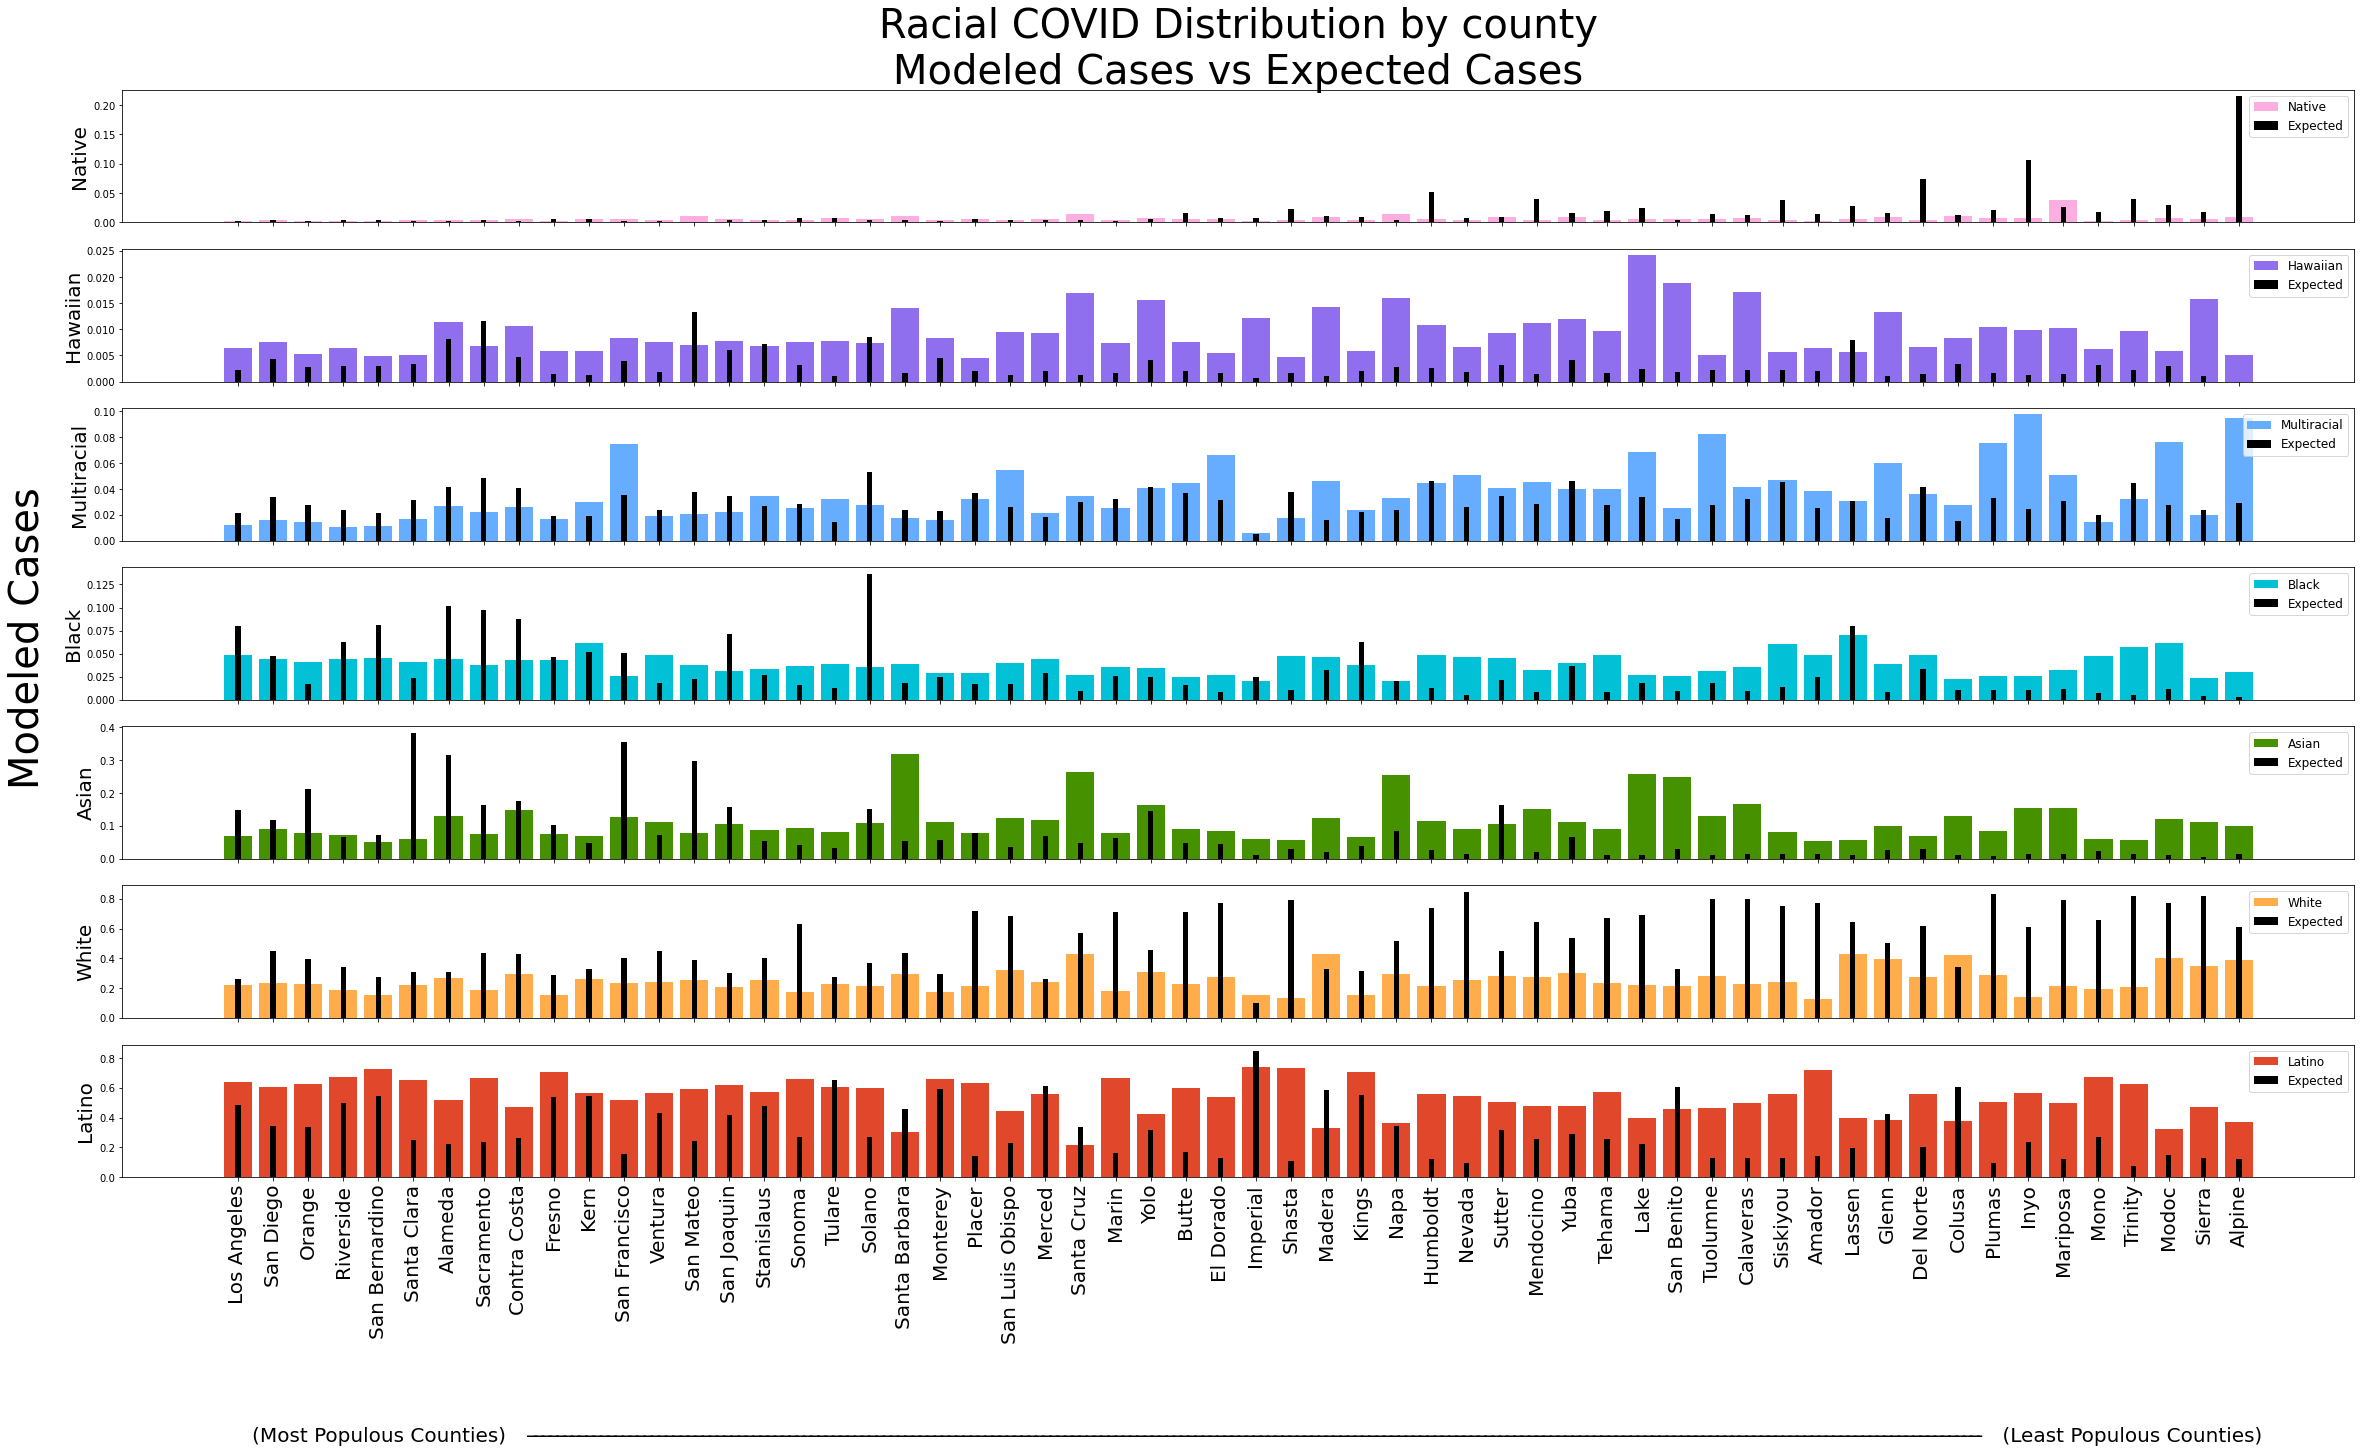

In [499]:
display_size = 40

graph_df = modeled_percents_df.copy()

#state_cases = modeled_total_counts_df.transpose().sum().sum()

bottom = -1
col_count = len(graph_df.columns)
fig,axs = plt.subplots(col_count,figsize=(display_size,display_size/2),sharex=True)
for x in range(0,col_count):
    
    this_race = graph_df.columns[x]

    this_color = race_color[this_race]
    this_ax = col_count-1 - x
    axs[this_ax].bar(graph_df.index,graph_df[this_race],color=this_color,label=this_race)
    if x == col_count-1:
        axs[this_ax].set_title(f"Racial COVID Distribution by county\nModeled Cases vs Expected Cases",fontsize=display_size)

    axs[this_ax].bar(pop_percent_df.index,pop_percent_df[this_race],color='black',width=.15,label='Expected')
    
    #race_percent = modeled_total_counts_df.transpose().sum().loc[this_race] / state_cases
    #axs[this_ax].axhline(race_percent,color = "white", linestyle = "-", lw=2, alpha=.5)
    #axs[this_ax].axhline(race_percent,color = "black", label="State Avg", linestyle = "--", lw=2, alpha=.15)
    
    axs[this_ax].legend(fontsize=display_size*.3,loc="upper right")
    
    axs[this_ax].set_ylabel(this_race)
    axs[this_ax].yaxis.label.set_size(display_size*.5)
    
    #axes.xaxis.label.set_size(16)

        
plt.xticks(rotation=90,fontsize=display_size*.5)
#plt.yticks(fontsize=display_size)

#handles,labels = deduplicate_legend(ax)

#plt.legend(fontsize=display_size*.5,loc="upper right")
#plt.title(f"Racial COVID Distribution by county",fontsize=display_size)
#plt.ylabel("Total Cases by County (per 100k)",loc="center",fontsize=display_size)
fig.text(.085, 0.5, 'Modeled Cases', va='center', rotation='vertical',fontsize=display_size)
#fig.text(.5, -0.05, 'California Counties', va='center',fontsize=display_size)
fig.text(.17, -0.055, '(Most Populous Counties)', va='center',fontsize=display_size *.5)
fig.text(.265, -0.055, '---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------   (Least Populous Counties)', va='center',fontsize=display_size *.5)
fig.text(.267, -0.055, '--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------', va='center',fontsize=display_size *.5)

plt.show()

del graph_df

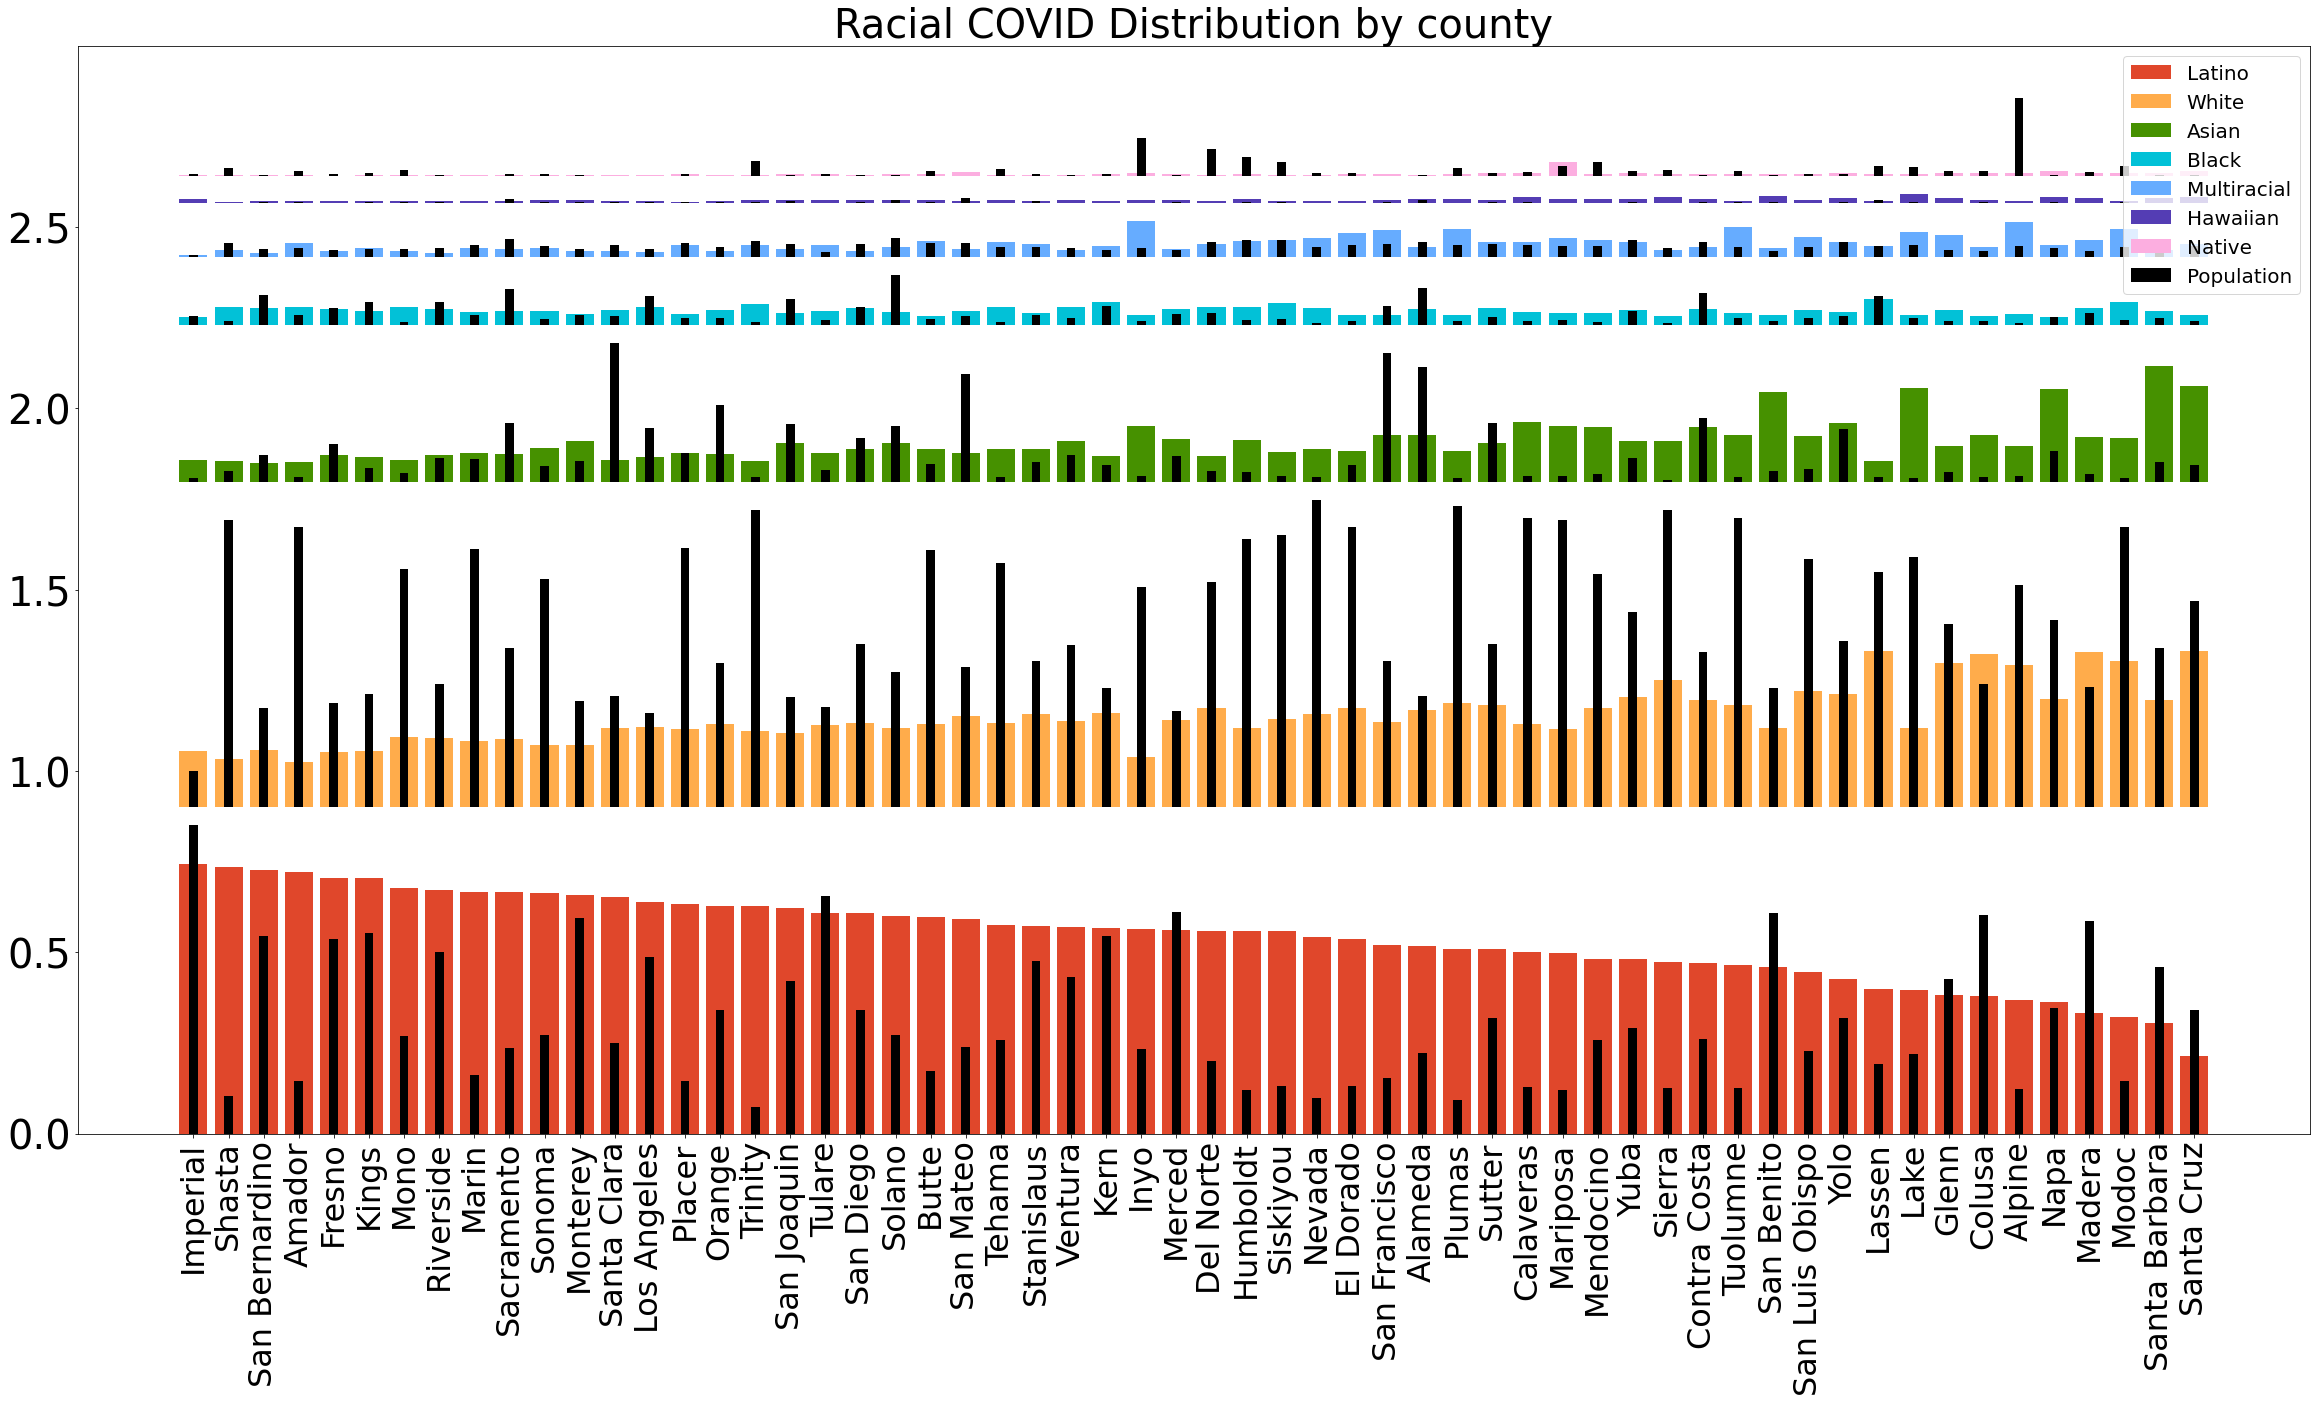

In [315]:
display_size = 40

graph_df = modeled_percents_df.copy()

bottom = -1

fig,ax = plt.subplots(figsize=(display_size,display_size/2))

ax.bar(graph_df.index,graph_df[graph_df.columns[0]],label=graph_df.columns[0],color=race_color[graph_df.columns[0]])

ax.bar(pop_percent_df.index,pop_percent_df[graph_df.columns[0]],color='black',width=.25)

#//*** Set the graph bottom  to the greater of graph_df and pop_percent_df max
if graph_df[graph_df.columns[0]].max() > pop_percent_df[graph_df.columns[0]].max():
    
    bottom = graph_df[graph_df.columns[0]].max()+.05
    
else:
    bottom = pop_percent_df[graph_df.columns[0]].max()+.05
        

for x in range(1, (len(graph_df.columns))):
    
    ax.bar(graph_df.index,graph_df[graph_df.columns[x]],bottom=bottom,label=graph_df.columns[x],color=race_color[graph_df.columns[x]])
    ax.bar(graph_df.index,pop_percent_df[graph_df.columns[x]],color='black',bottom=bottom,width=.25)
    
    if graph_df[graph_df.columns[x]].max() > pop_percent_df[graph_df.columns[x]].max():
        bottom += graph_df[graph_df.columns[x]].max()+.05
    else:
        bottom += pop_percent_df[graph_df.columns[x]].max()+.05
        
ax.bar(pop_percent_df.index,pop_percent_df[graph_df.columns[0]],label='Population',color='black',width=.25)
    
#//*** Draw horizontal line. Draw it twice to get the yellow and back effect. 
#//*** This technique looks viusually good, but I can't get the legend to draw approrpriately.
#ax.axhline(state_100k,color = "black", label="Statewide Cases 100k", linestyle = "-", lw=2)
#ax.axhline(state_100k,color = "yellow", linestyle = "--", lw=2)
        
plt.xticks(rotation=90,fontsize=display_size*.8)
plt.yticks(fontsize=display_size)

handles,labels = deduplicate_legend(ax)

plt.legend(fontsize=display_size*.5,loc="upper right")
plt.title(f"Racial COVID Distribution by county",fontsize=display_size)
#plt.ylabel("Total Cases by County (per 100k)",fontsize=display_size)
plt.show()

del graph_df

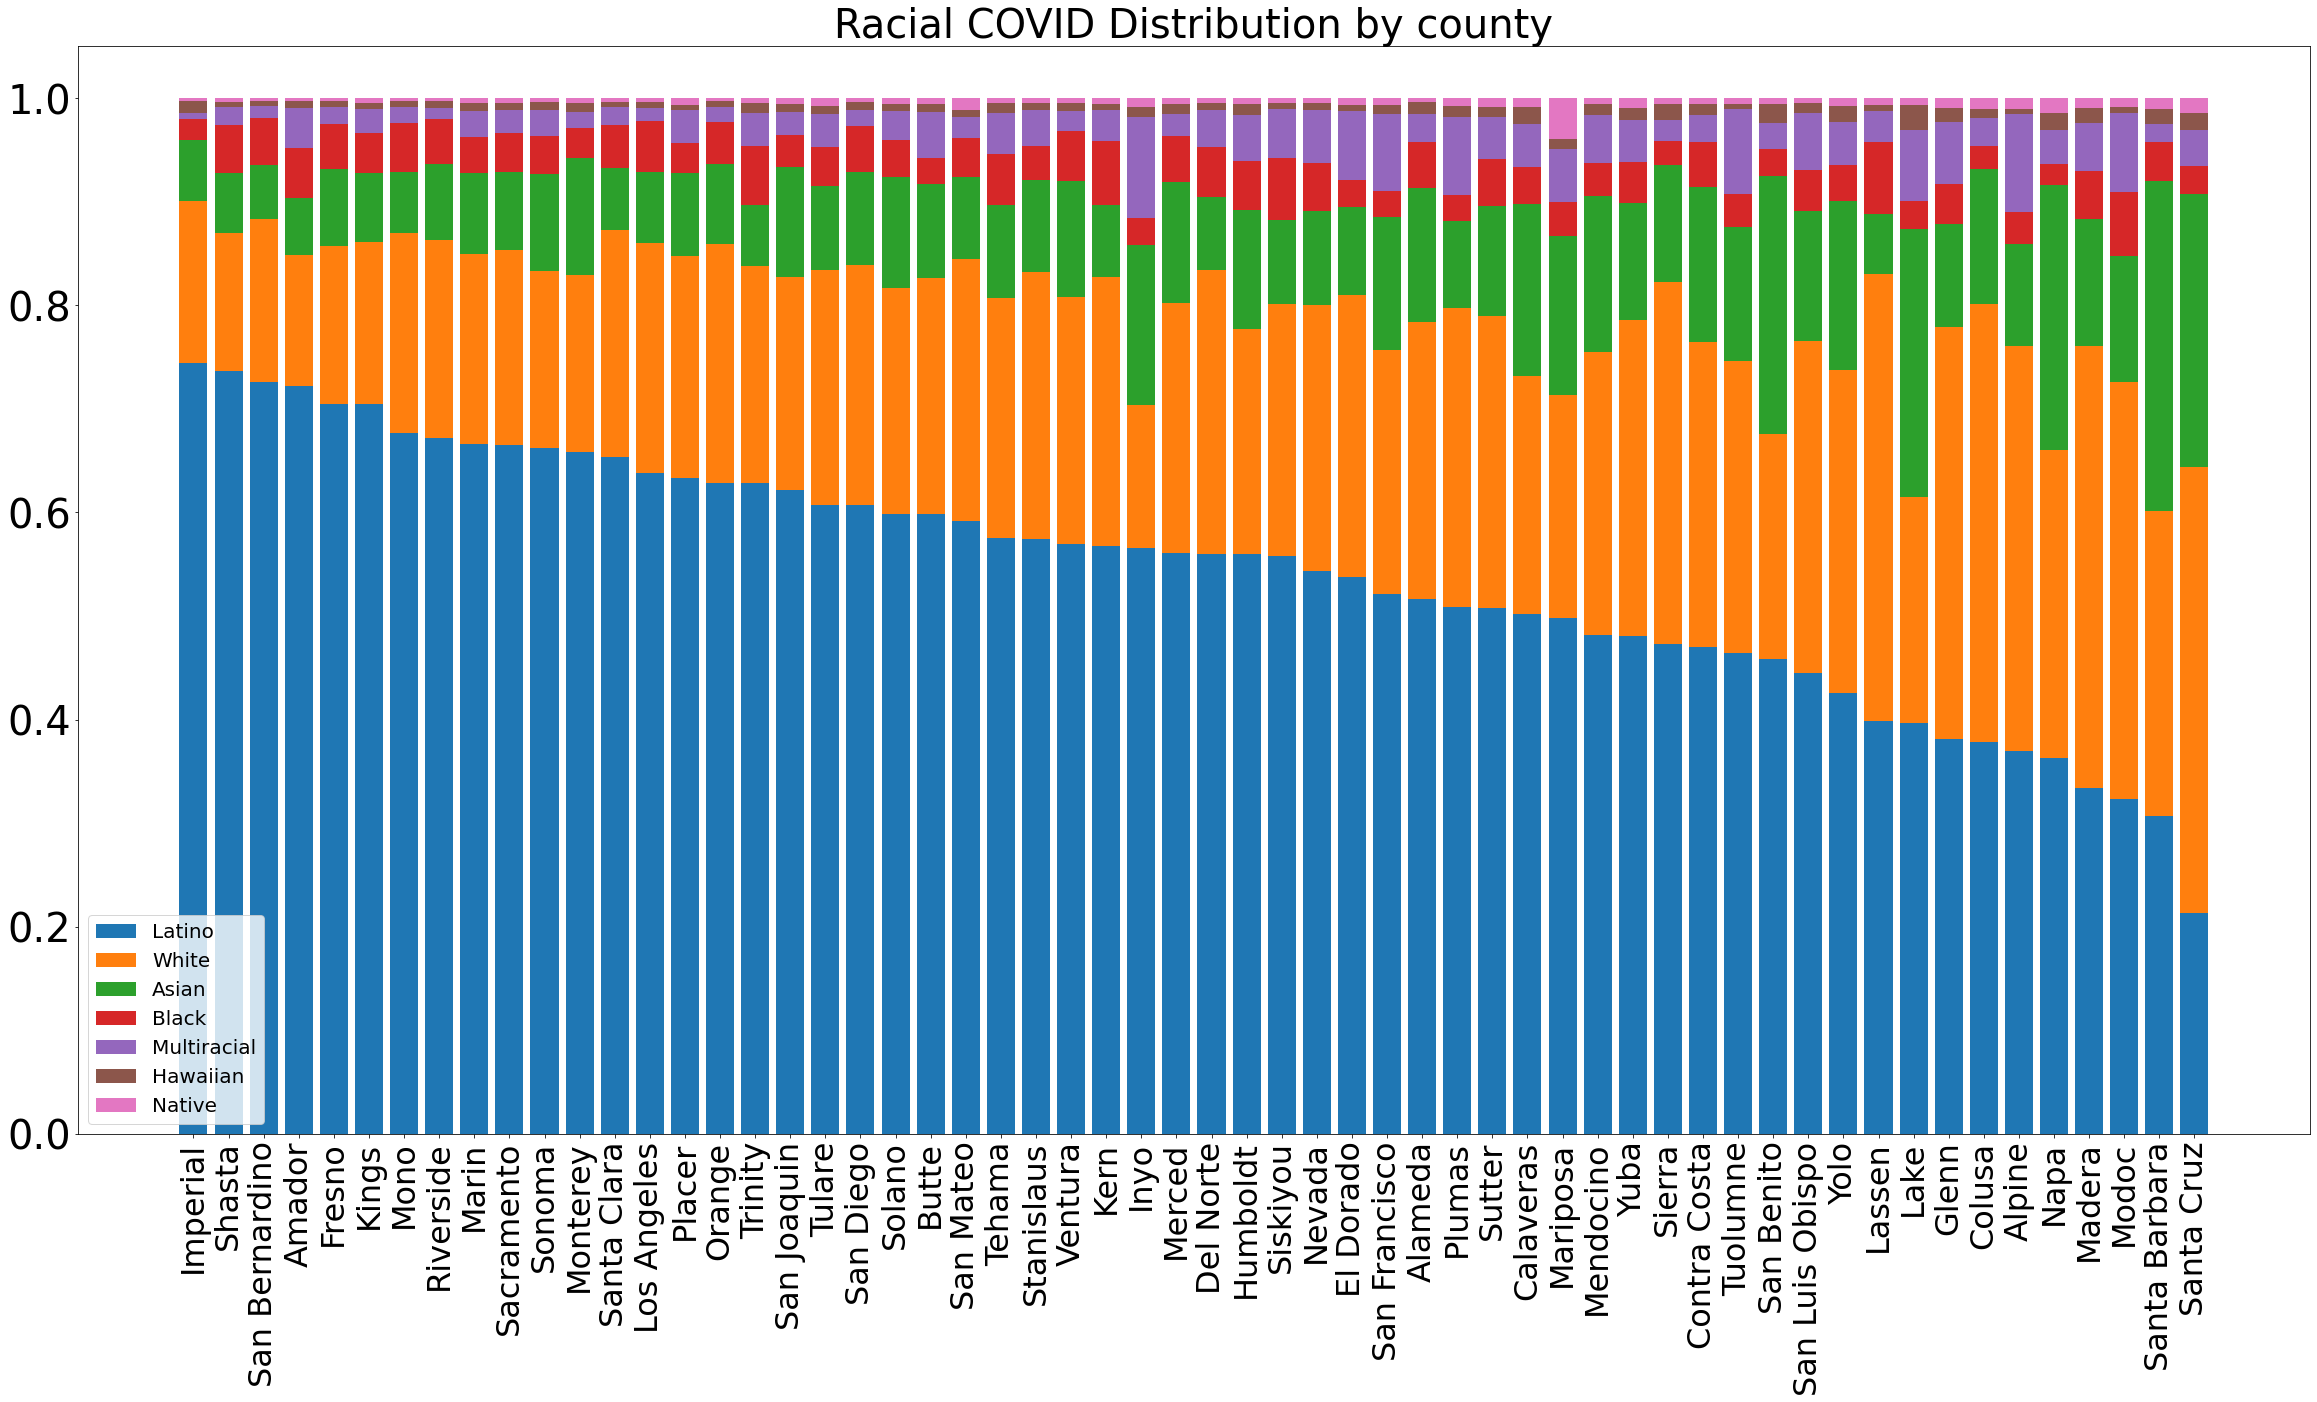

In [287]:
display_size = 40

graph_df = modeled_percents_df.copy()

bottom = -1

fig,ax = plt.subplots(figsize=(display_size,display_size/2))

ax.bar(graph_df.index,graph_df[graph_df.columns[0]],label=graph_df.columns[0])

bottom = graph_df[graph_df.columns[0]]

for x in range(1, (len(graph_df.columns))):
    
    ax.bar(graph_df.index,graph_df[graph_df.columns[x]],bottom=bottom,label=graph_df.columns[x])
    
    
    bottom += graph_df[graph_df.columns[x]]

#//*** Draw horizontal line. Draw it twice to get the yellow and back effect. 
#//*** This technique looks viusually good, but I can't get the legend to draw approrpriately.
#ax.axhline(state_100k,color = "black", label="Statewide Cases 100k", linestyle = "-", lw=2)
#ax.axhline(state_100k,color = "yellow", linestyle = "--", lw=2)
        
plt.xticks(rotation=90,fontsize=display_size*.8)
plt.yticks(fontsize=display_size)

handles,labels = deduplicate_legend(ax)

plt.legend(fontsize=display_size*.5)
plt.title(f"Racial COVID Distribution by county",fontsize=display_size)
#plt.ylabel("Total Cases by County (per 100k)",fontsize=display_size)
plt.show()

del graph_df

TESTING visualization Model vs Expected


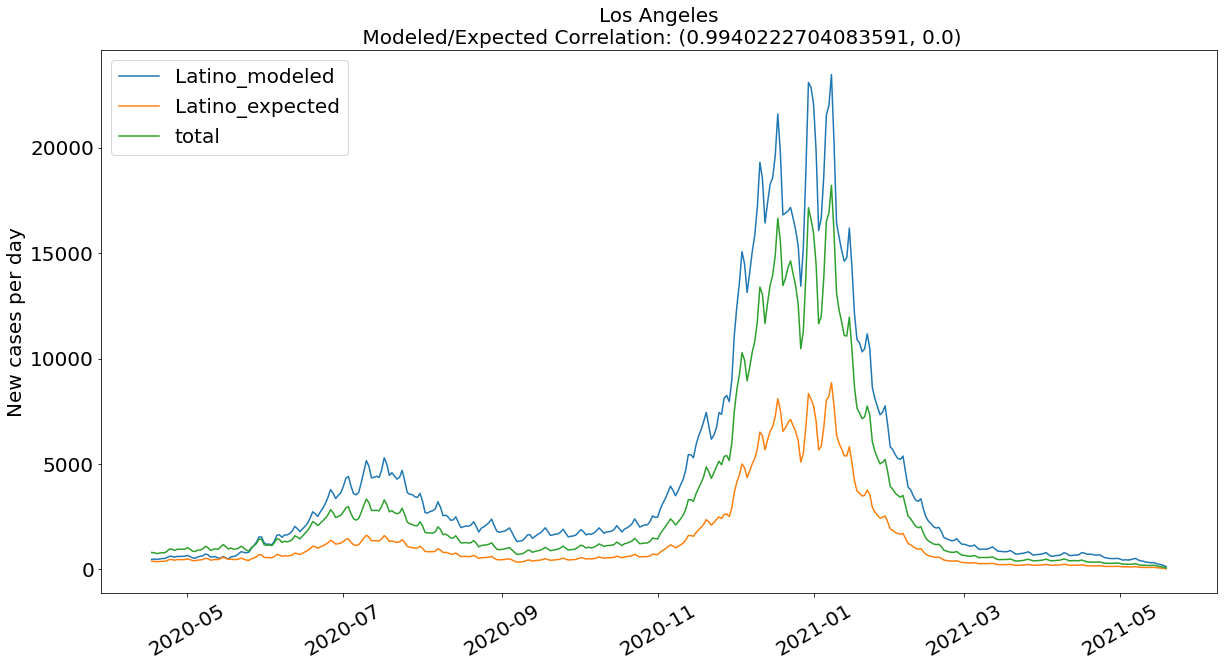

TESTING visualization Model vs Expected


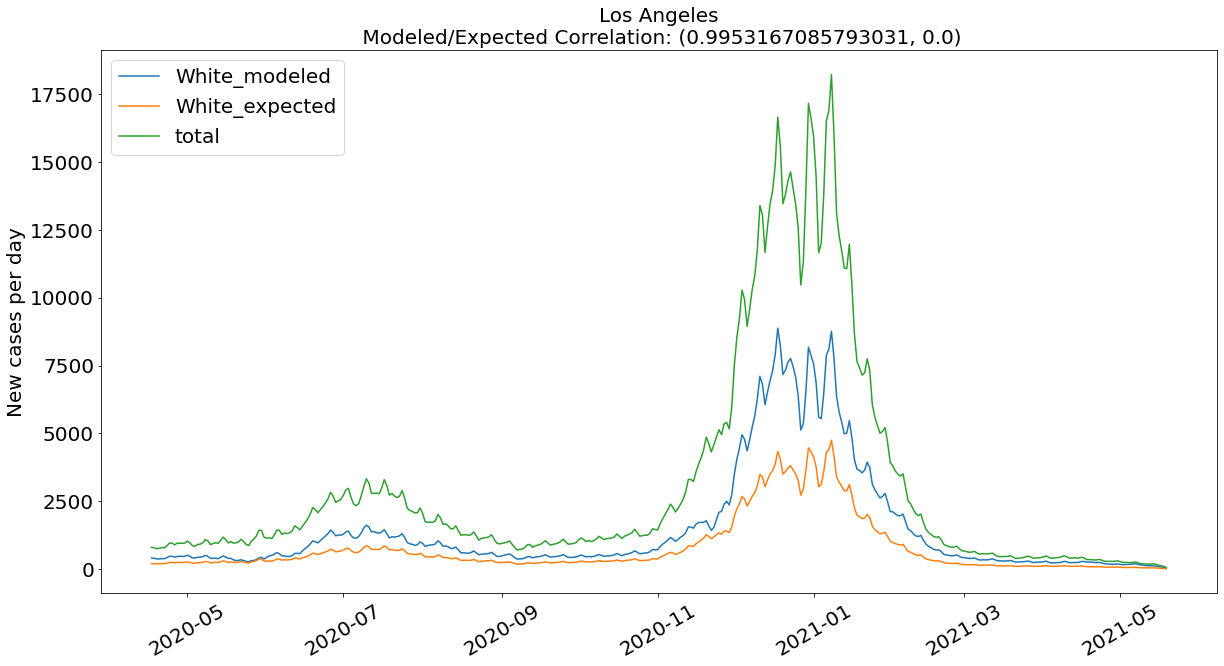

TESTING visualization Model vs Expected


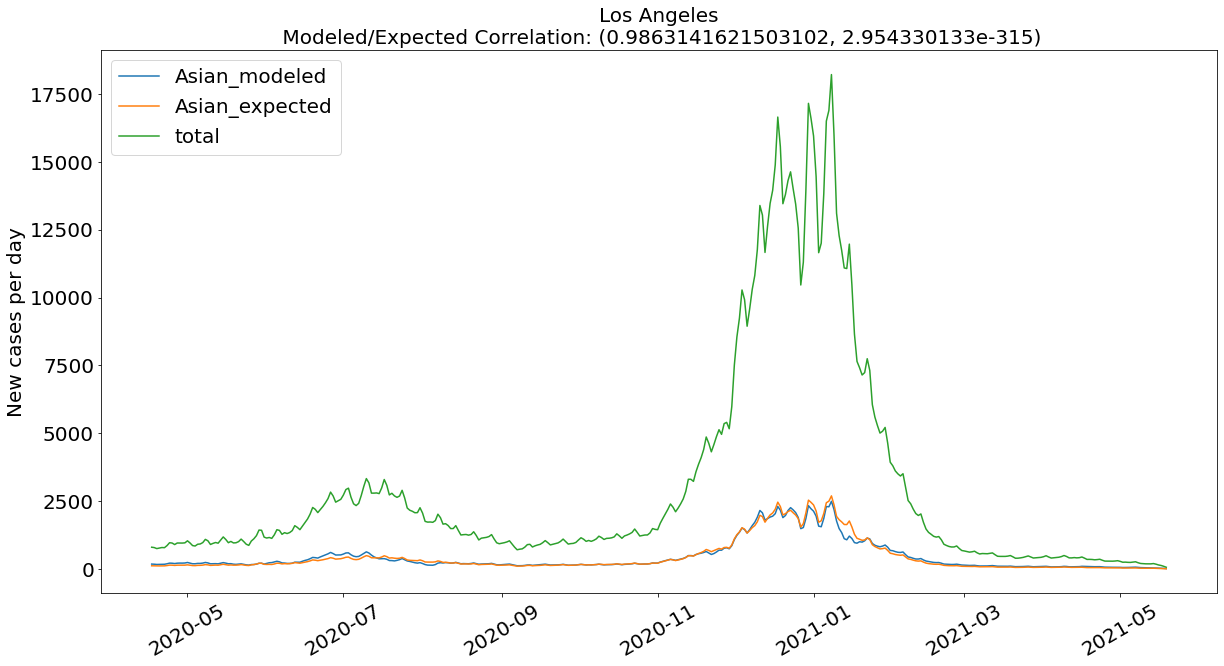

TESTING visualization Model vs Expected


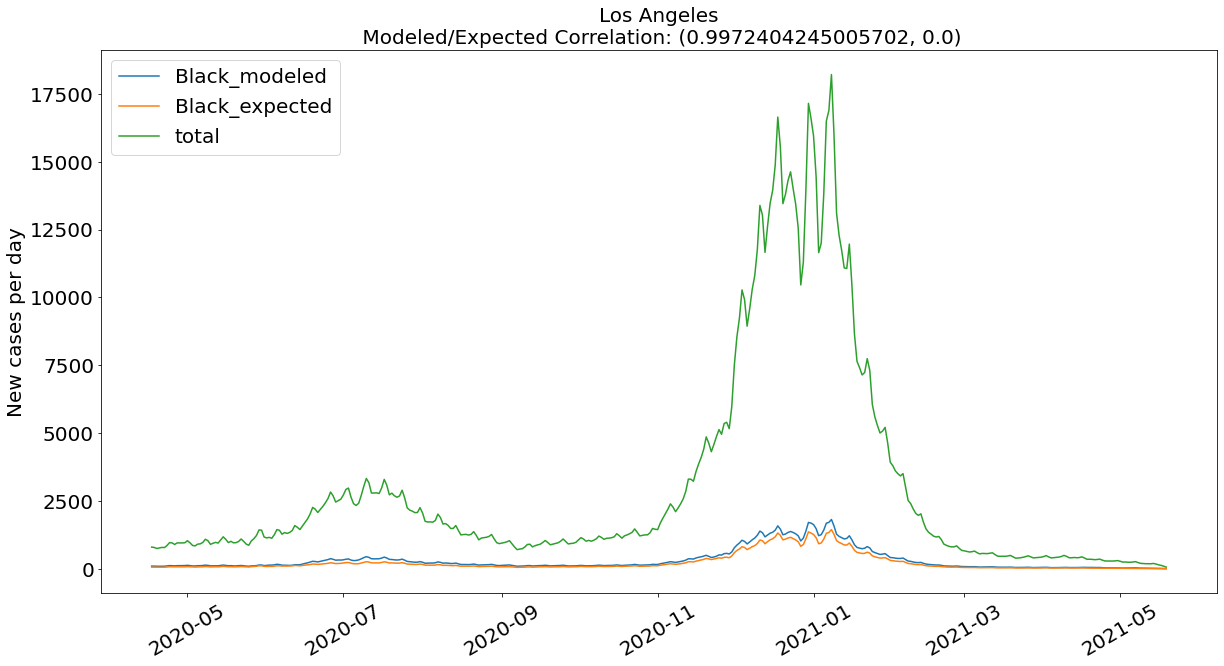

TESTING visualization Model vs Expected


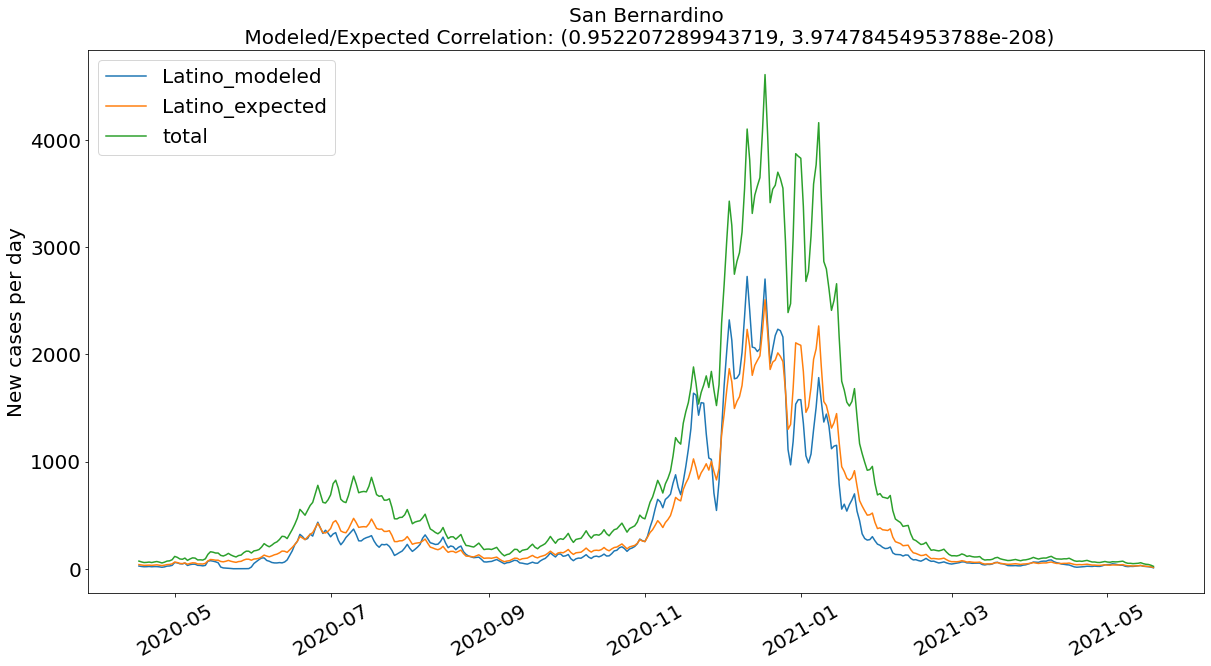

TESTING visualization Model vs Expected


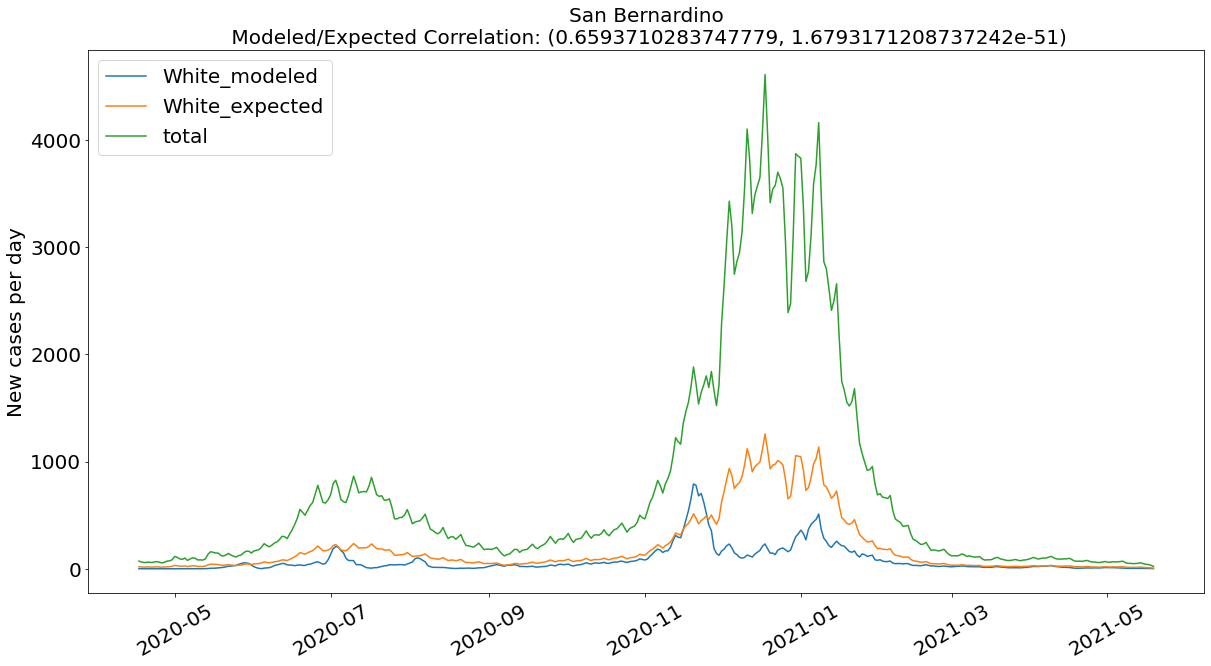

TESTING visualization Model vs Expected


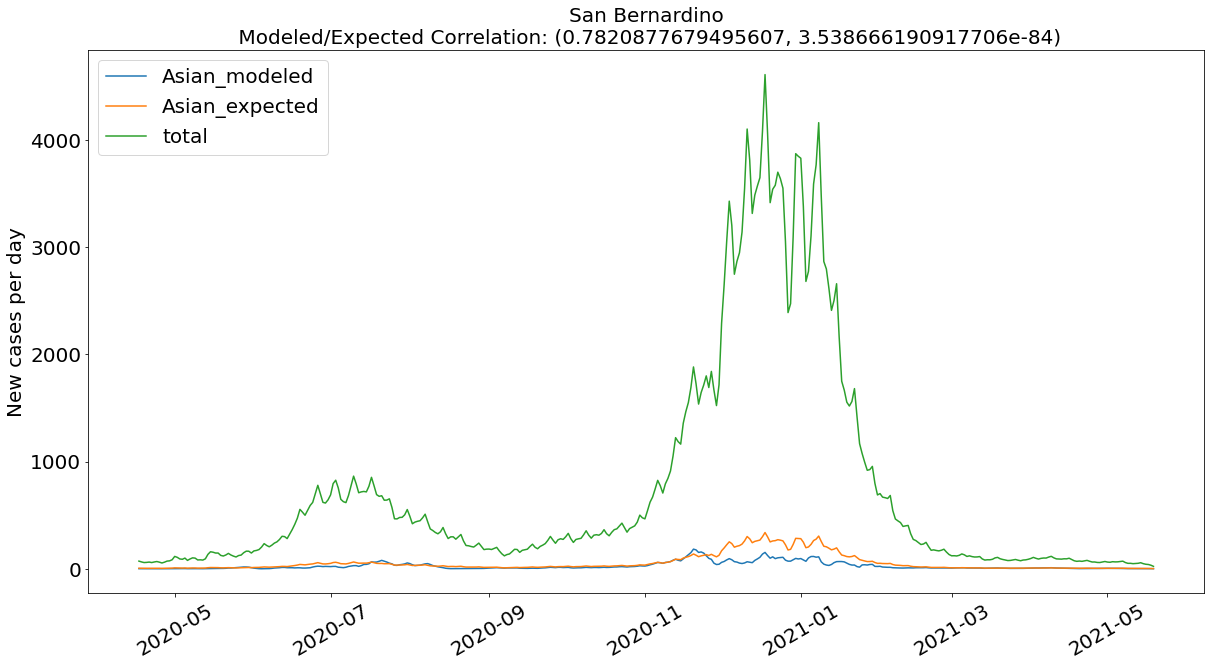

TESTING visualization Model vs Expected


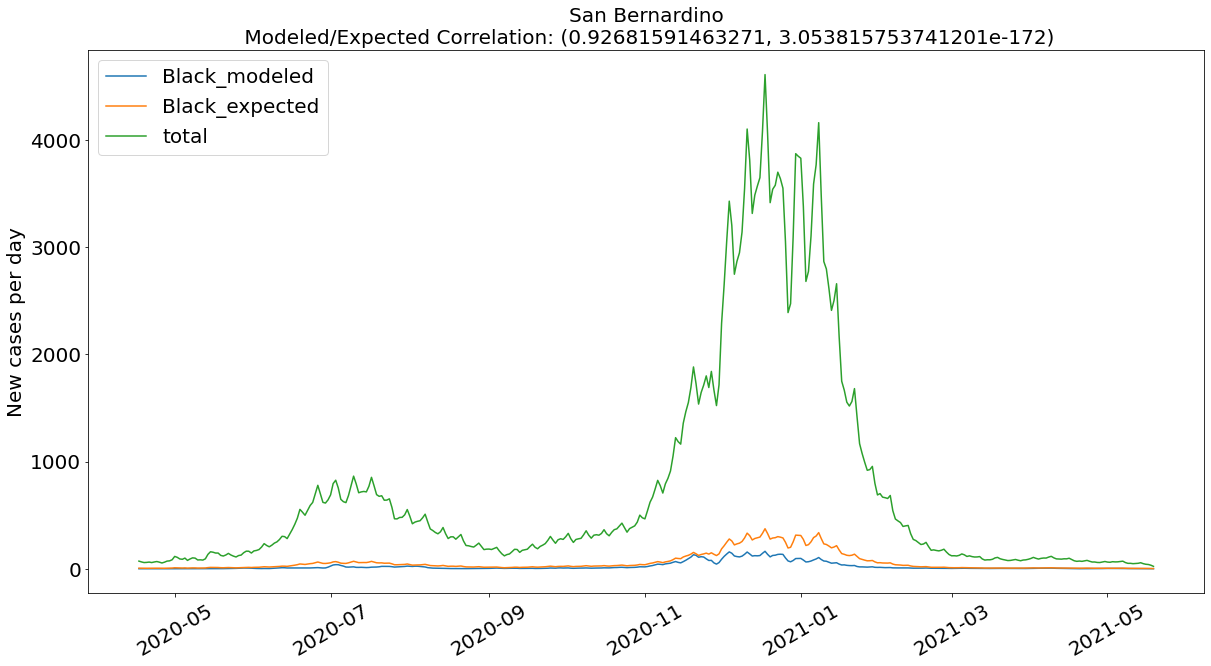

TESTING visualization Model vs Expected


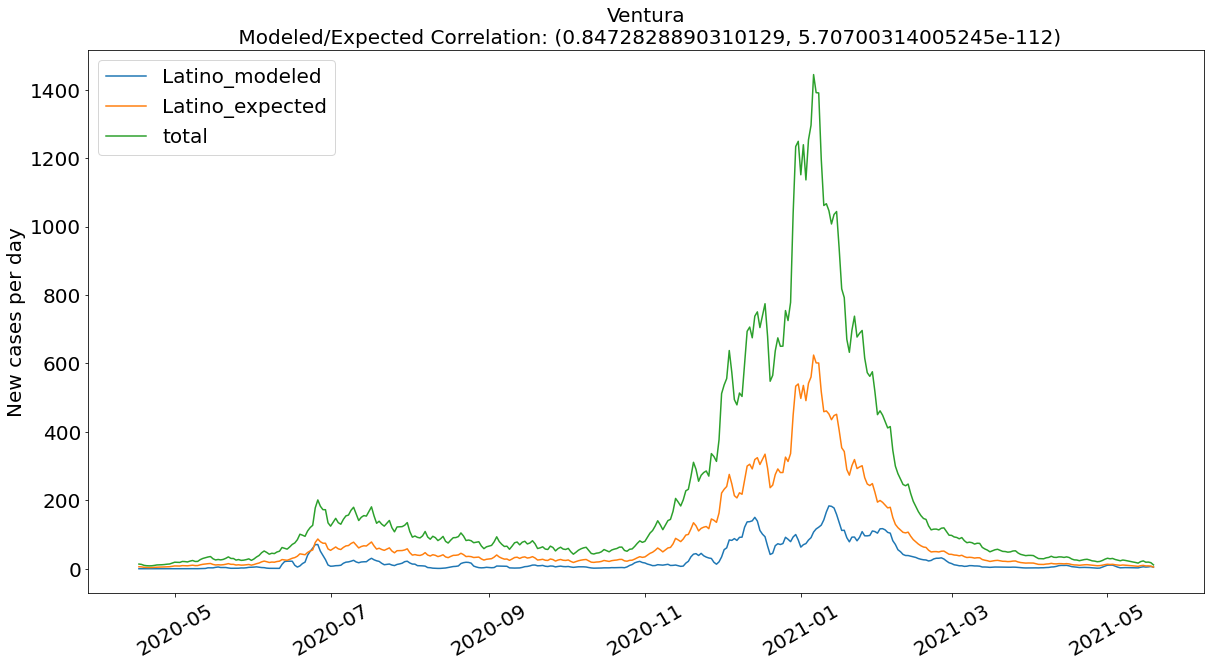

TESTING visualization Model vs Expected


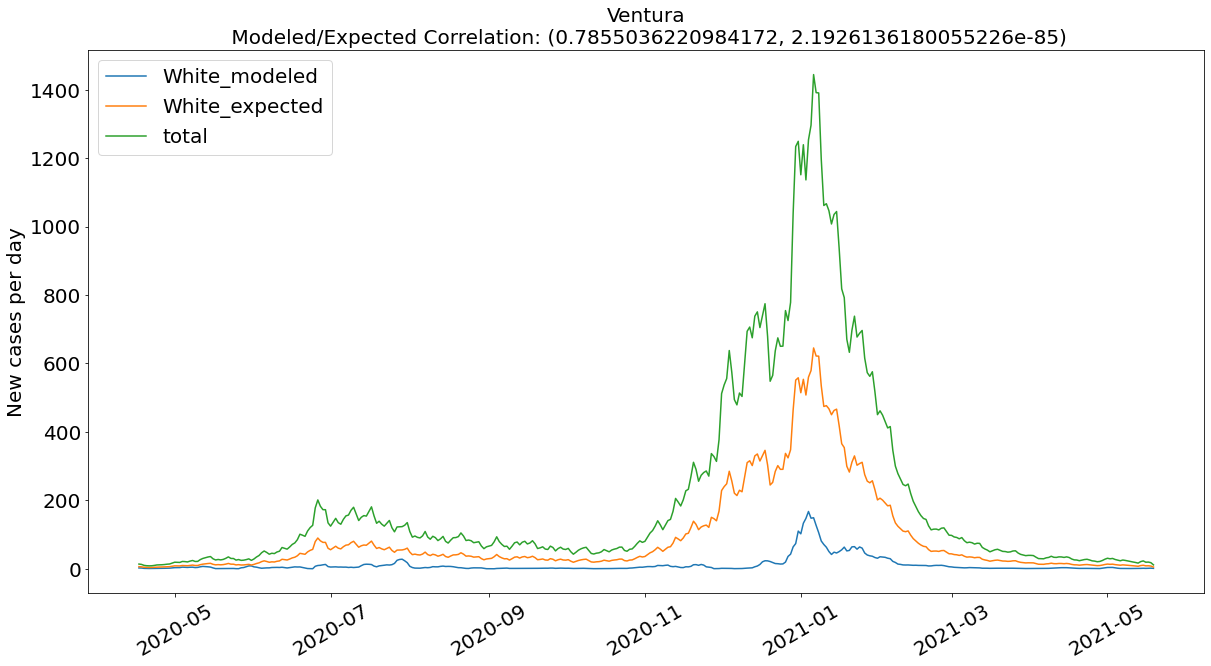

TESTING visualization Model vs Expected


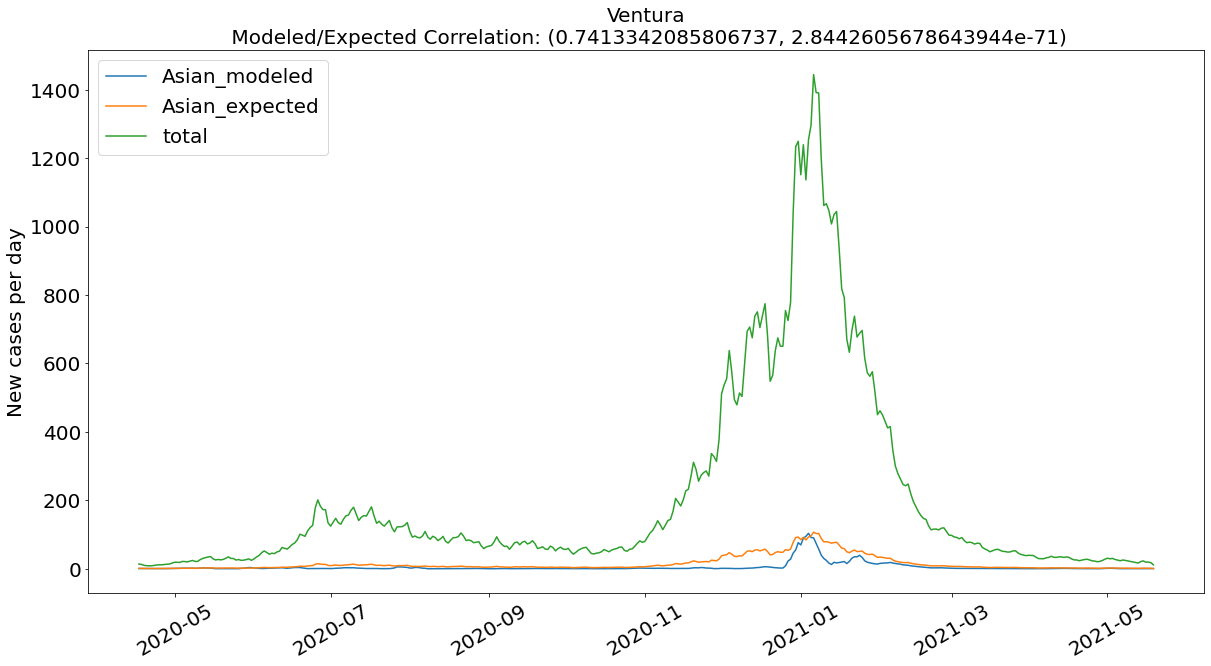

TESTING visualization Model vs Expected


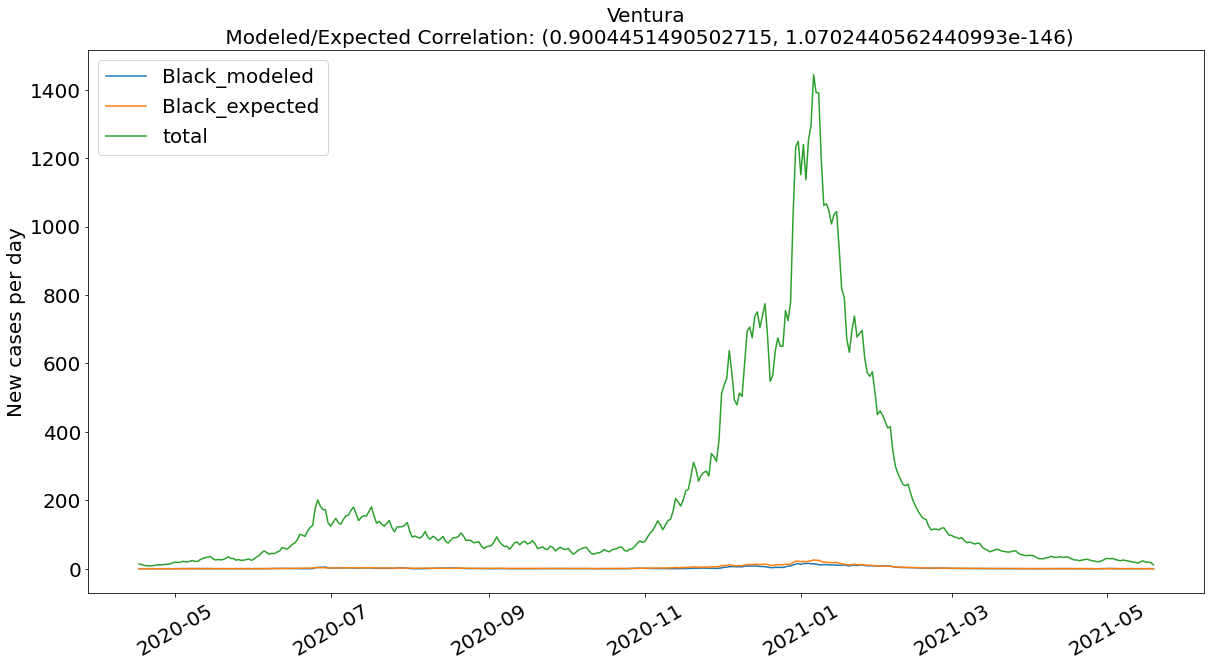

TESTING visualization Model vs Expected


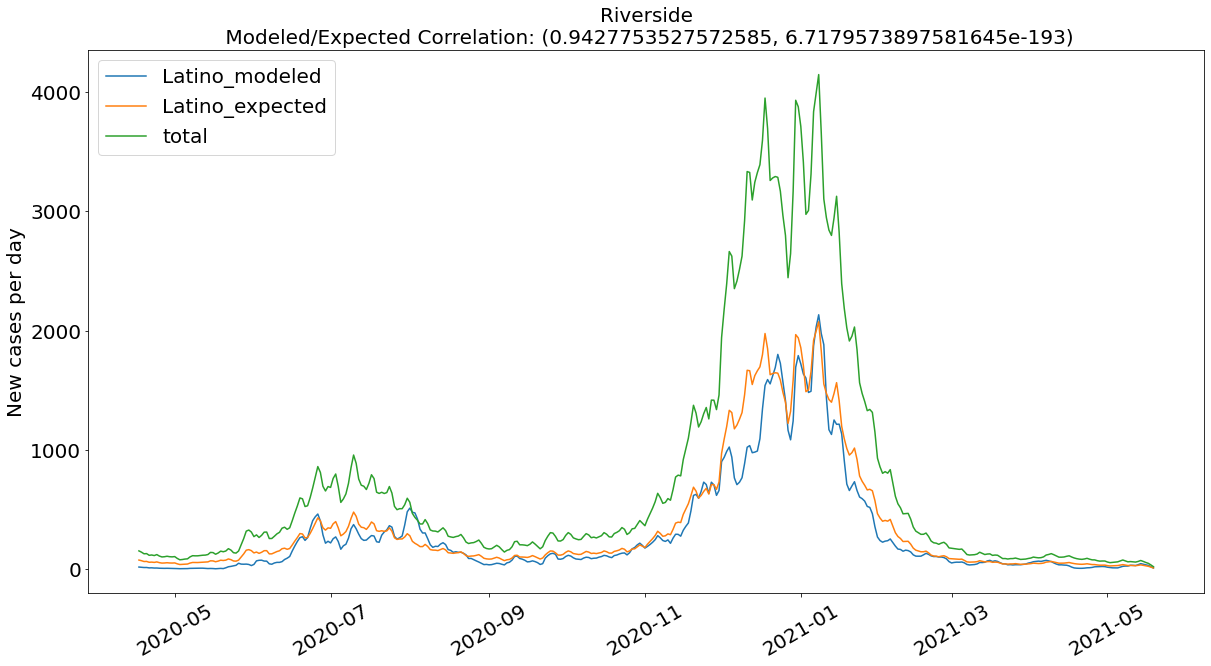

TESTING visualization Model vs Expected


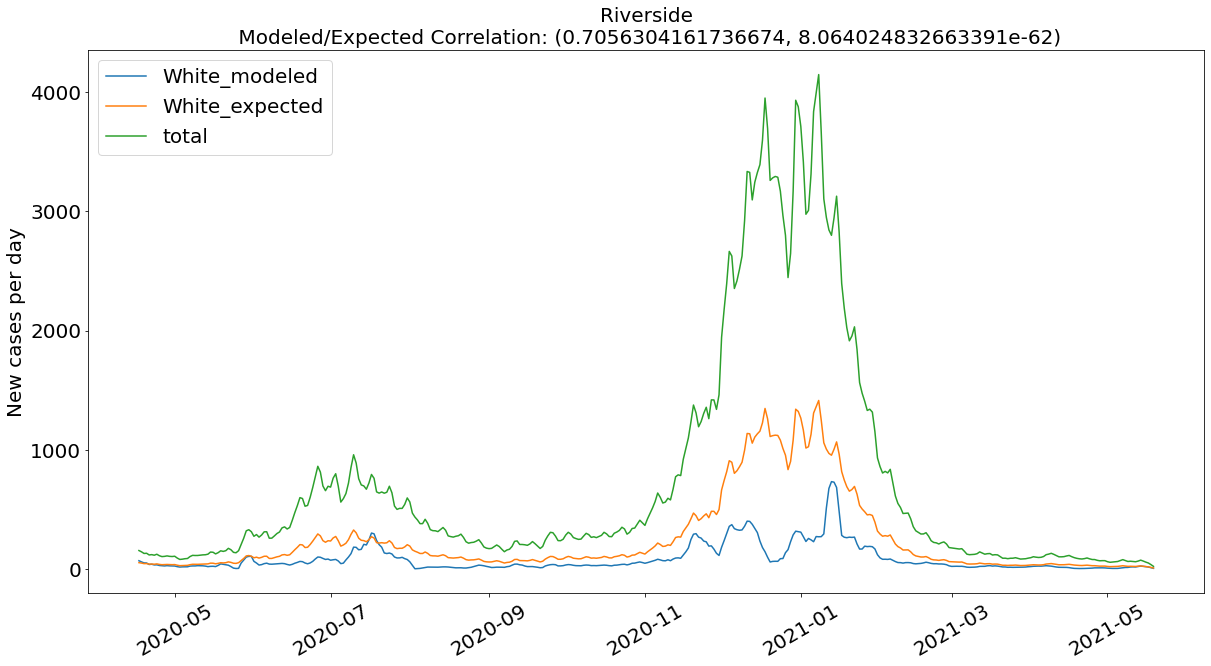

TESTING visualization Model vs Expected


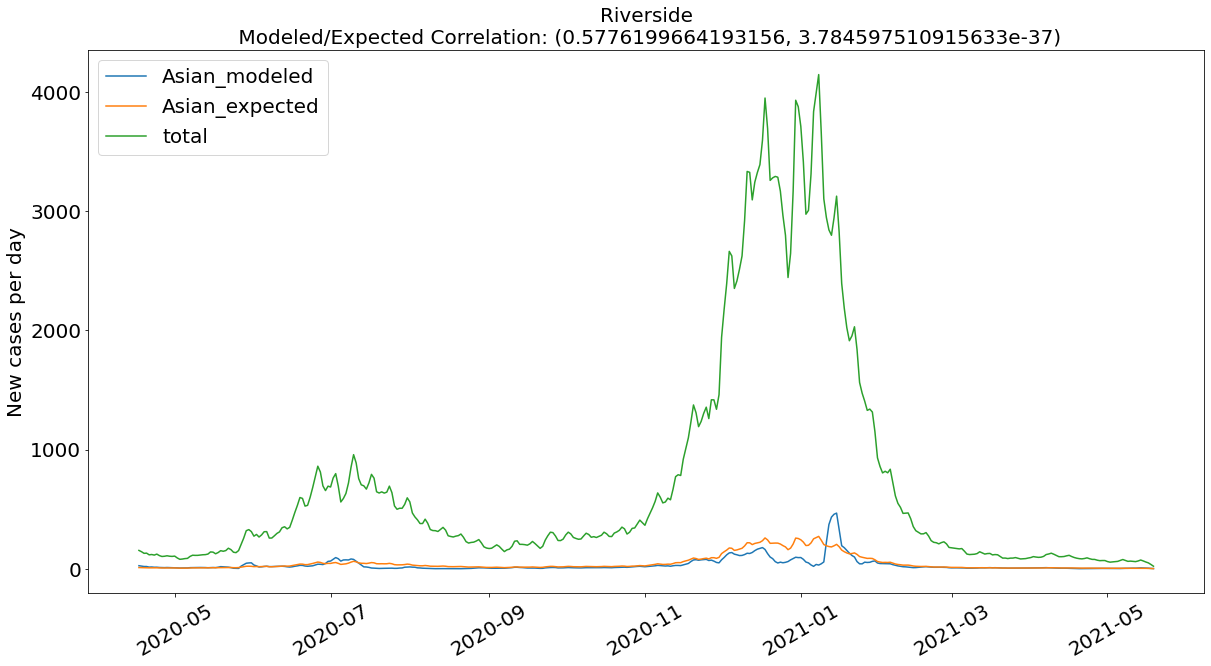

TESTING visualization Model vs Expected


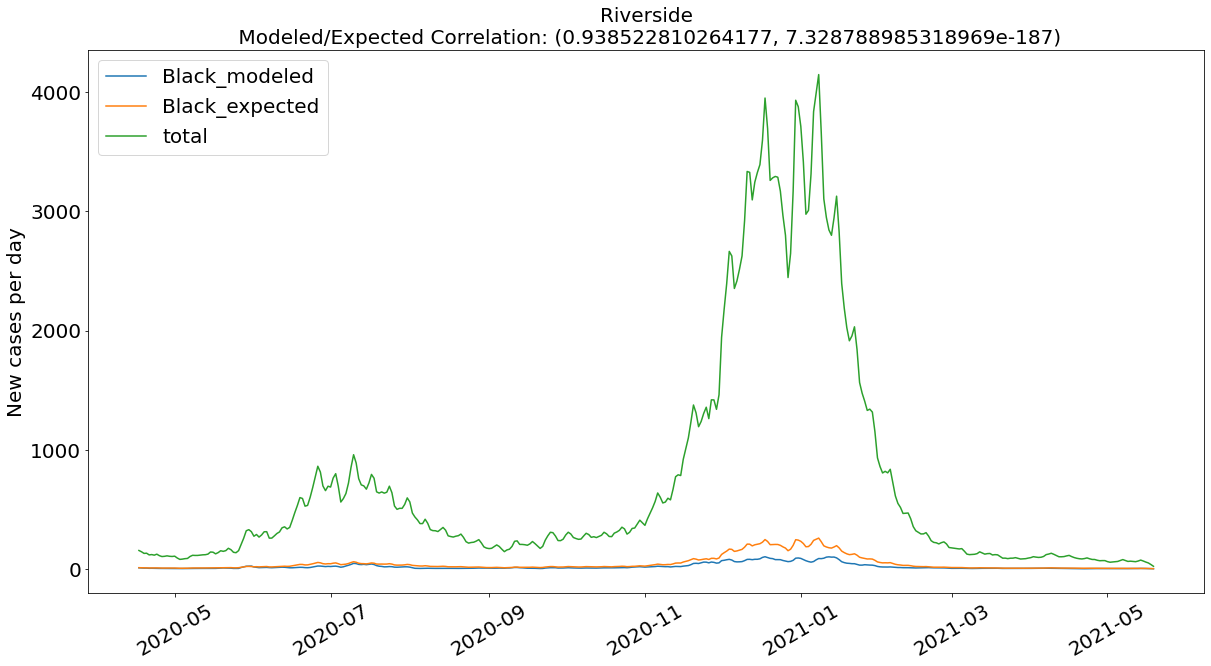

TESTING visualization Model vs Expected


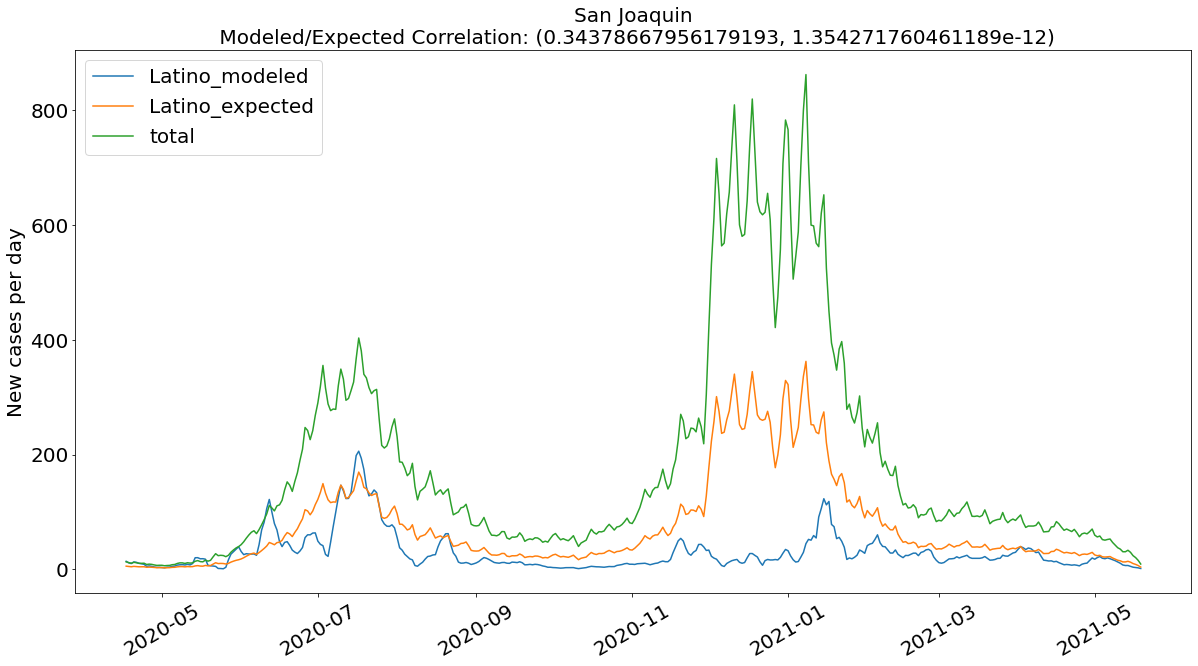

TESTING visualization Model vs Expected


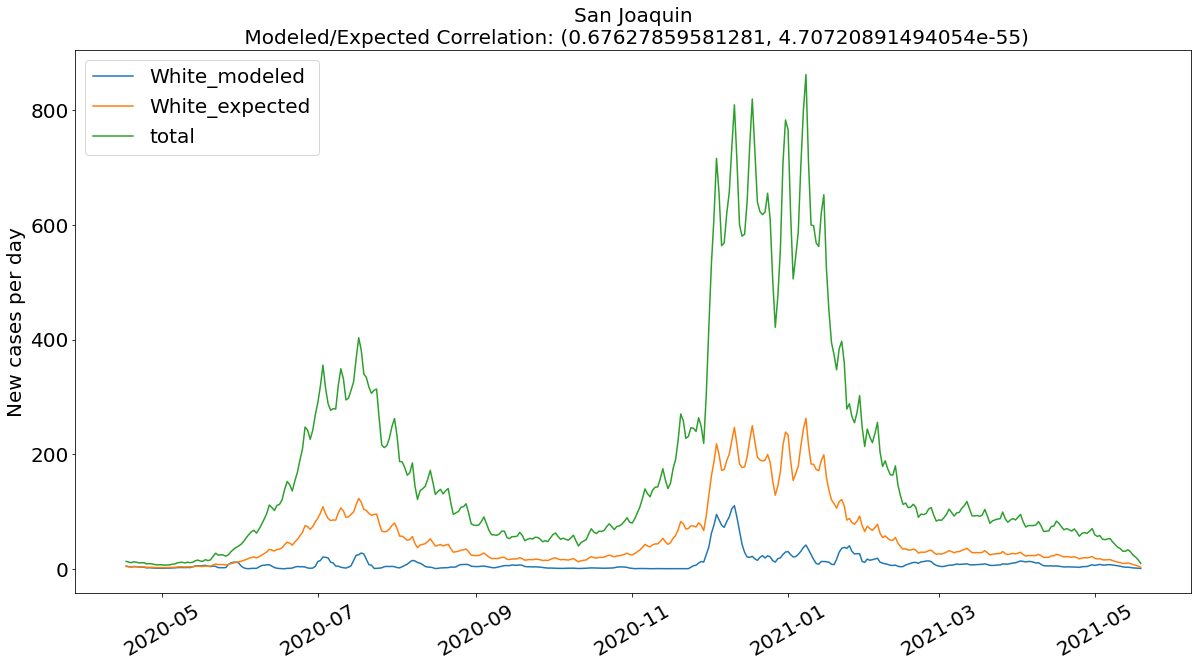

TESTING visualization Model vs Expected


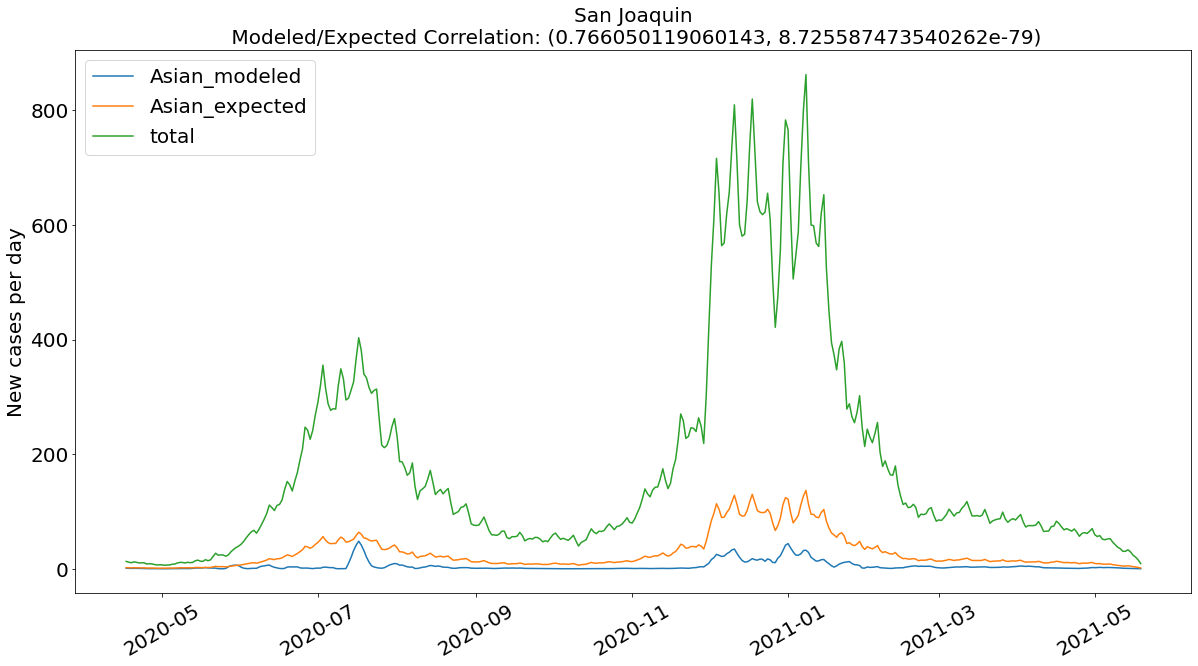

TESTING visualization Model vs Expected


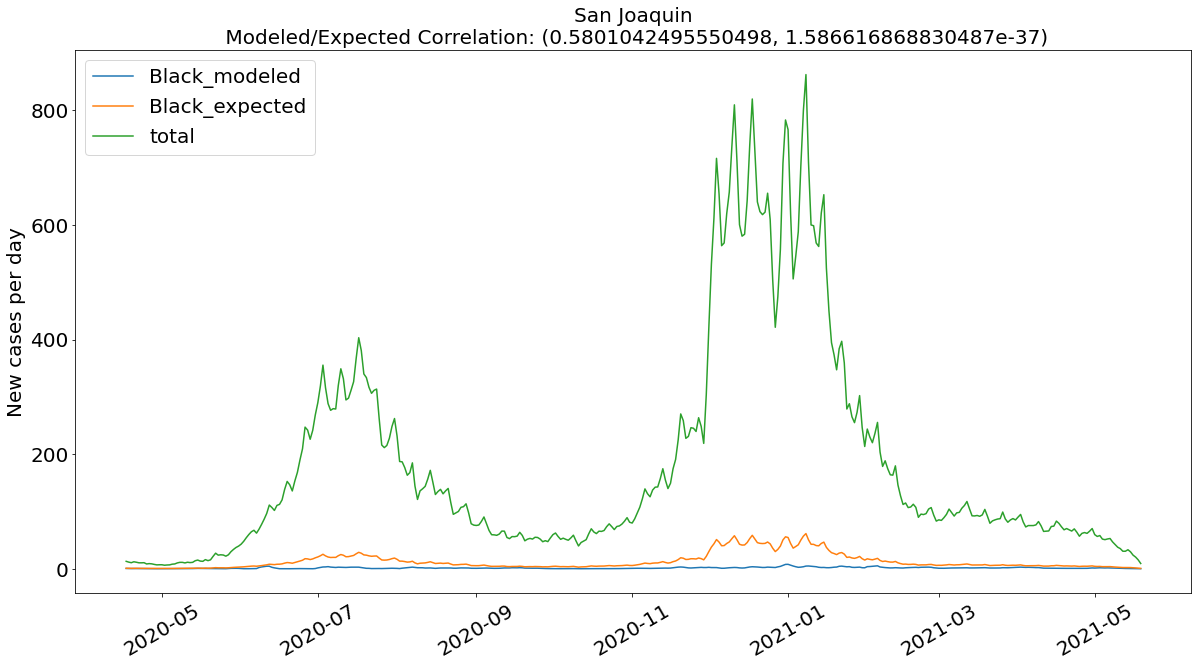

TESTING visualization Model vs Expected


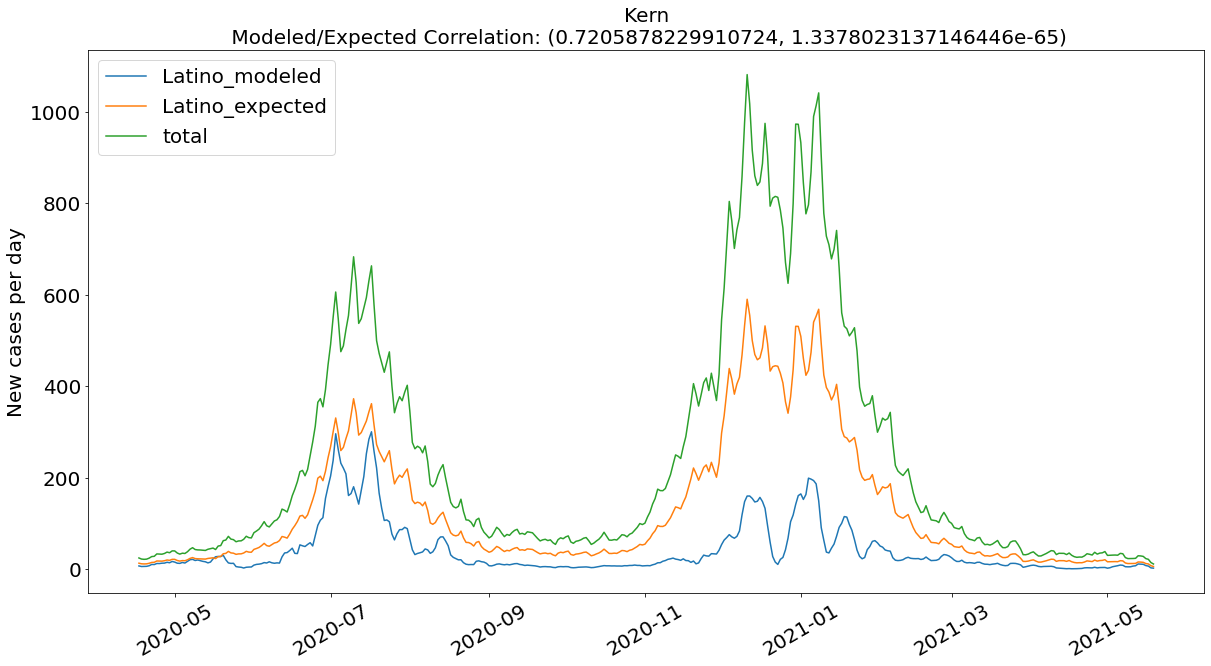

TESTING visualization Model vs Expected


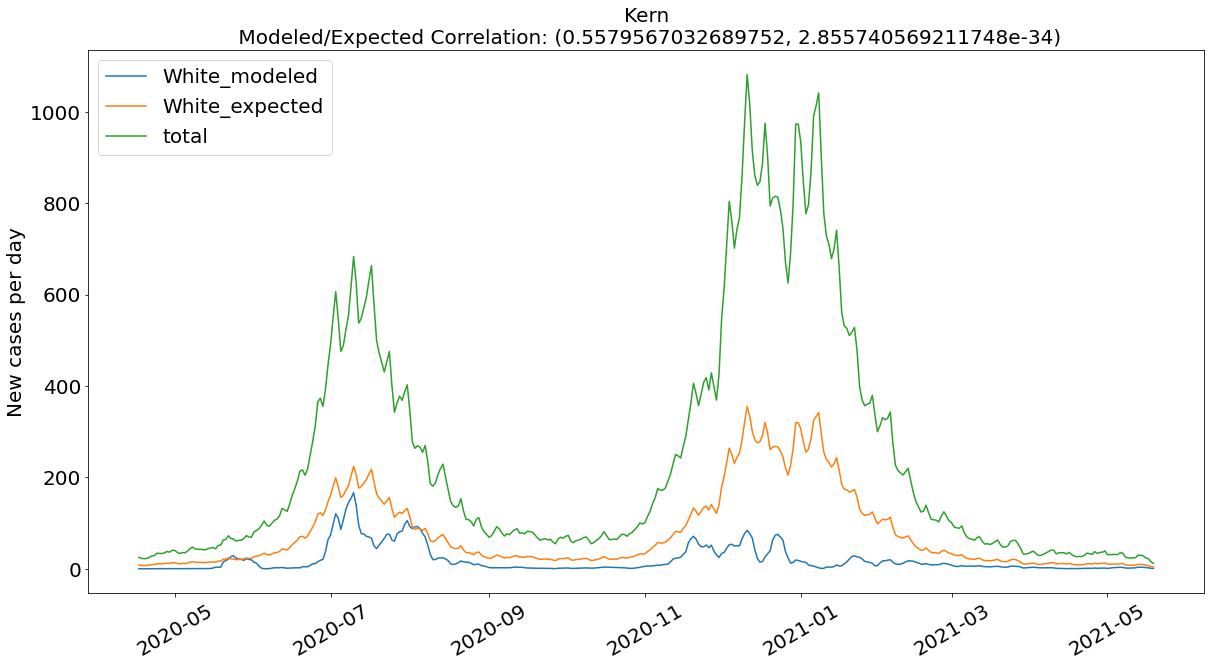

TESTING visualization Model vs Expected


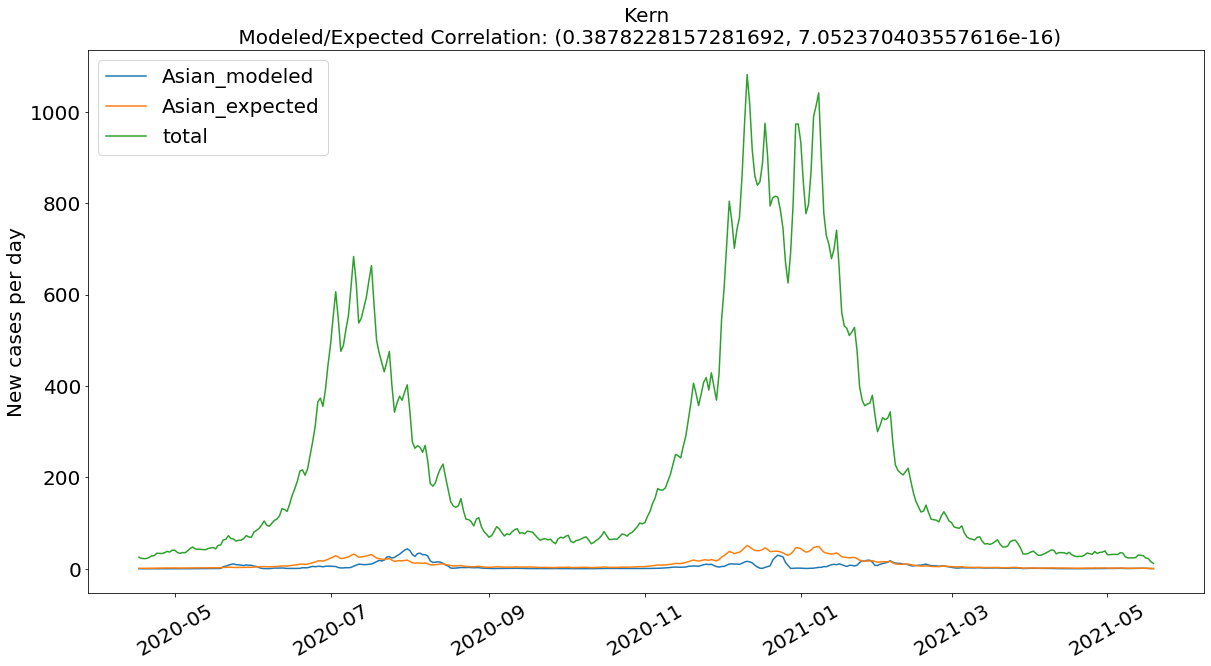

TESTING visualization Model vs Expected


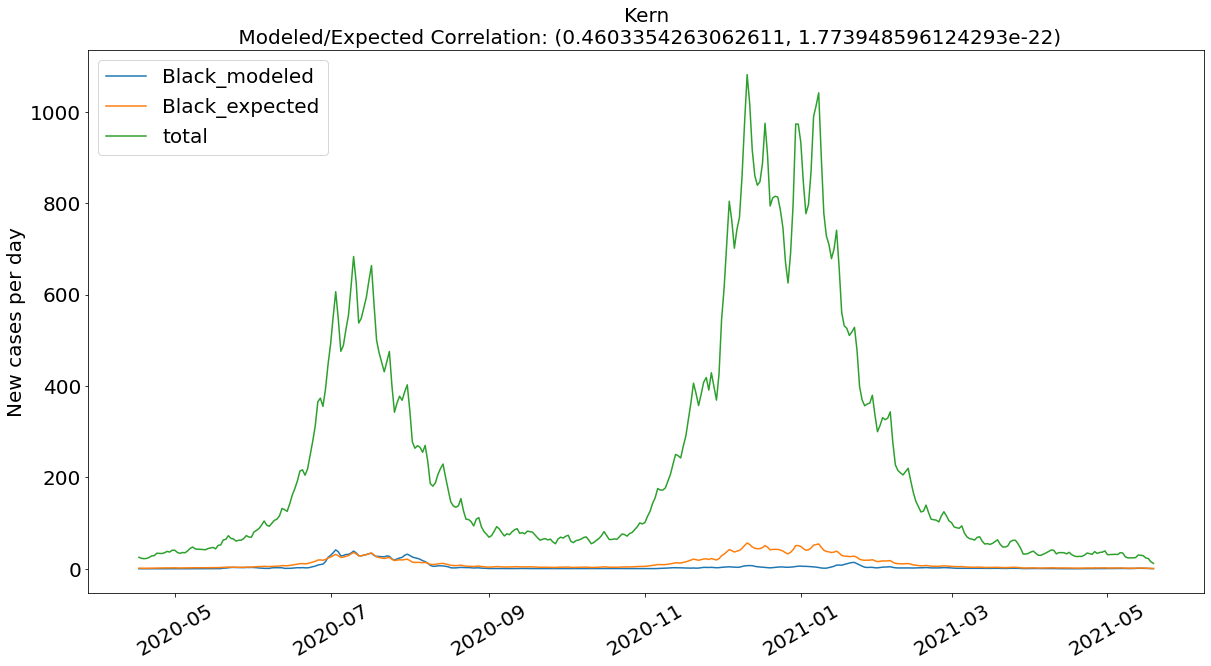

TESTING visualization Model vs Expected


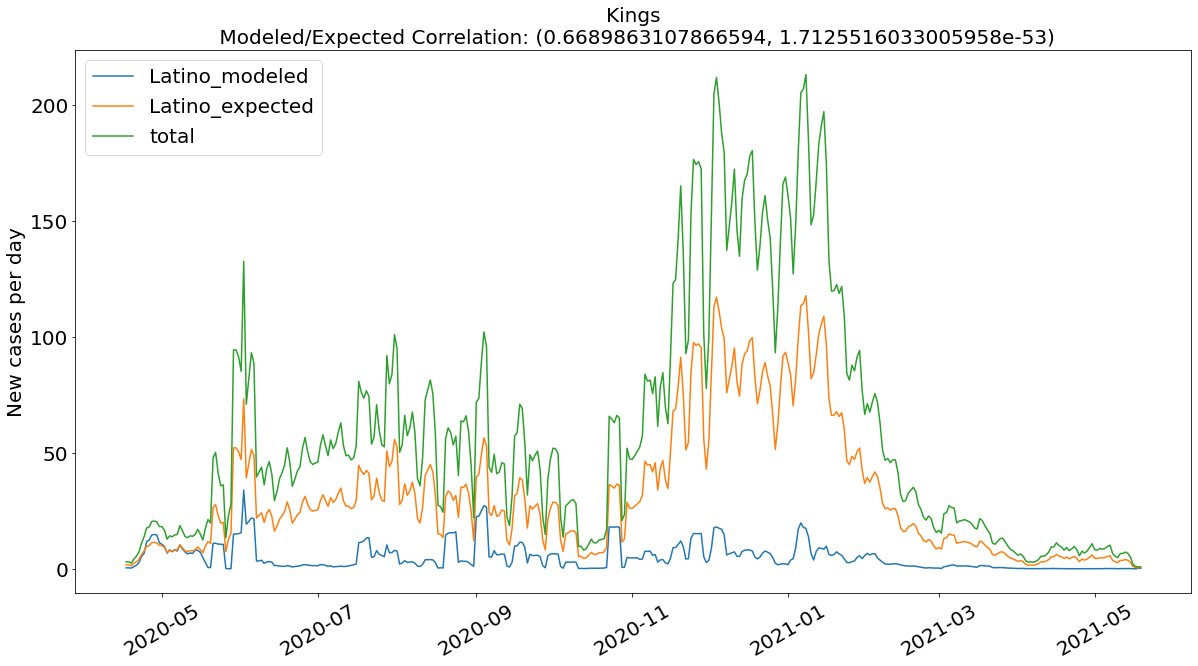

TESTING visualization Model vs Expected


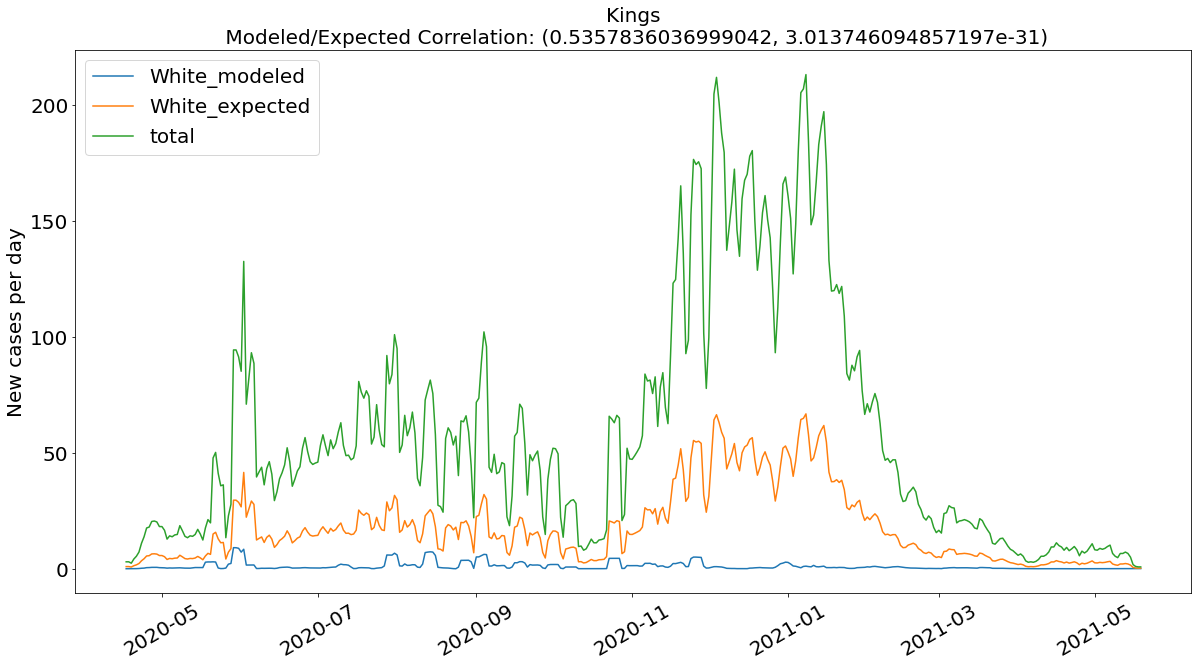

TESTING visualization Model vs Expected
TESTING visualization Model vs Expected


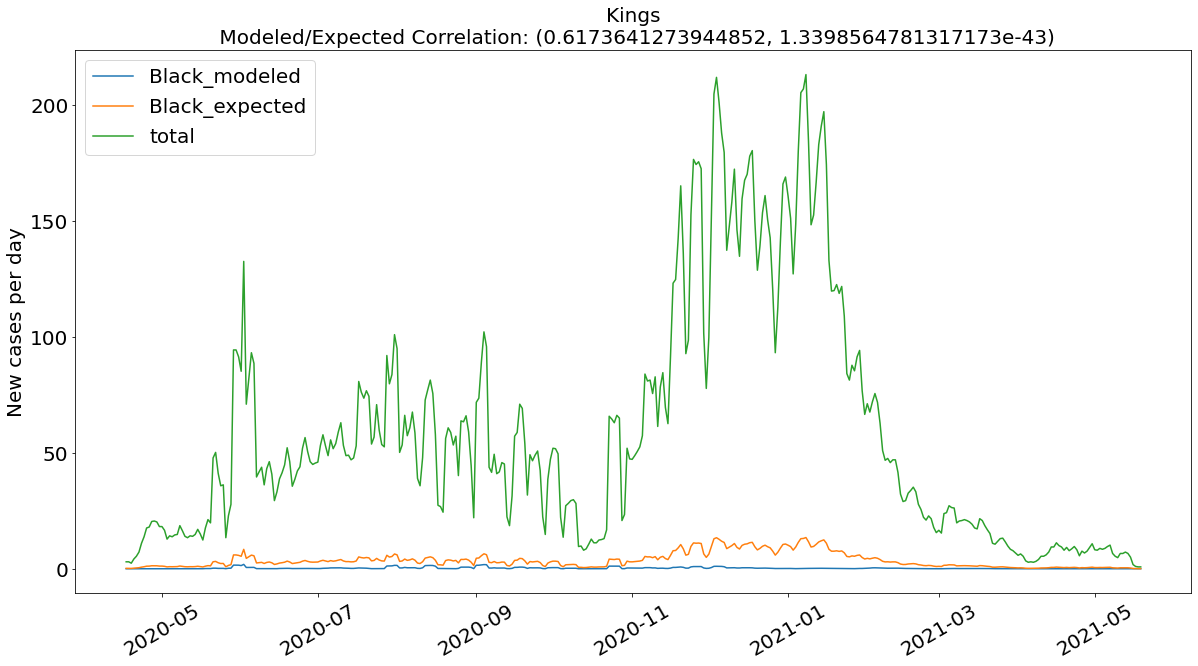

TESTING visualization Model vs Expected


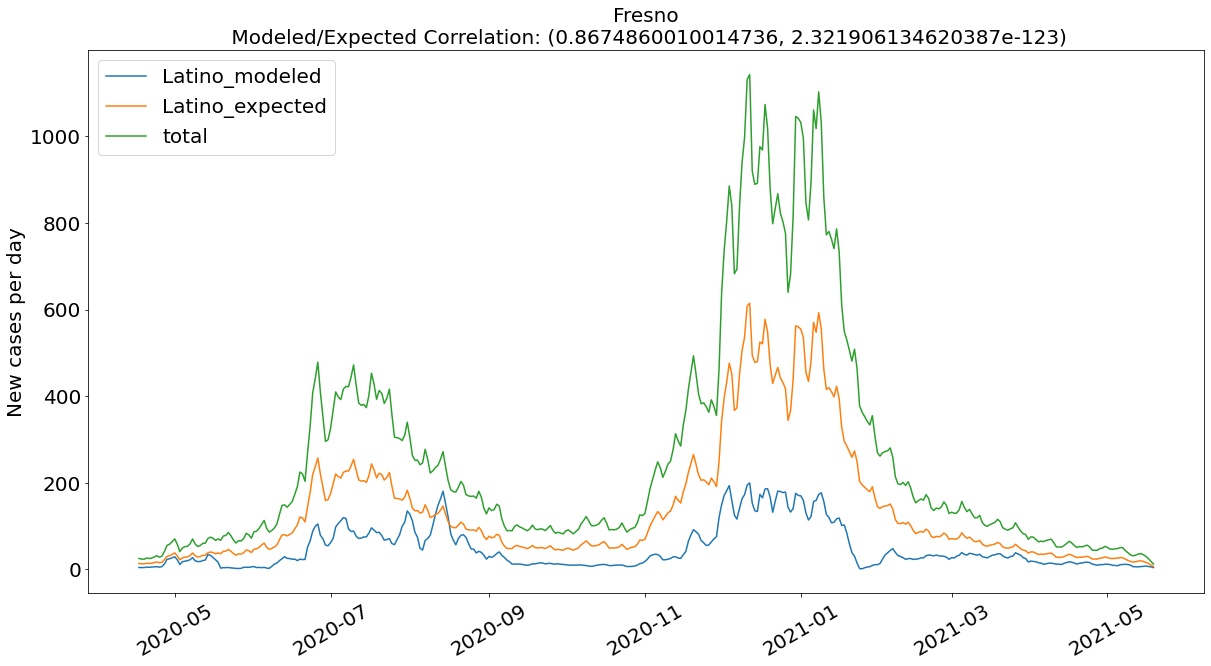

TESTING visualization Model vs Expected


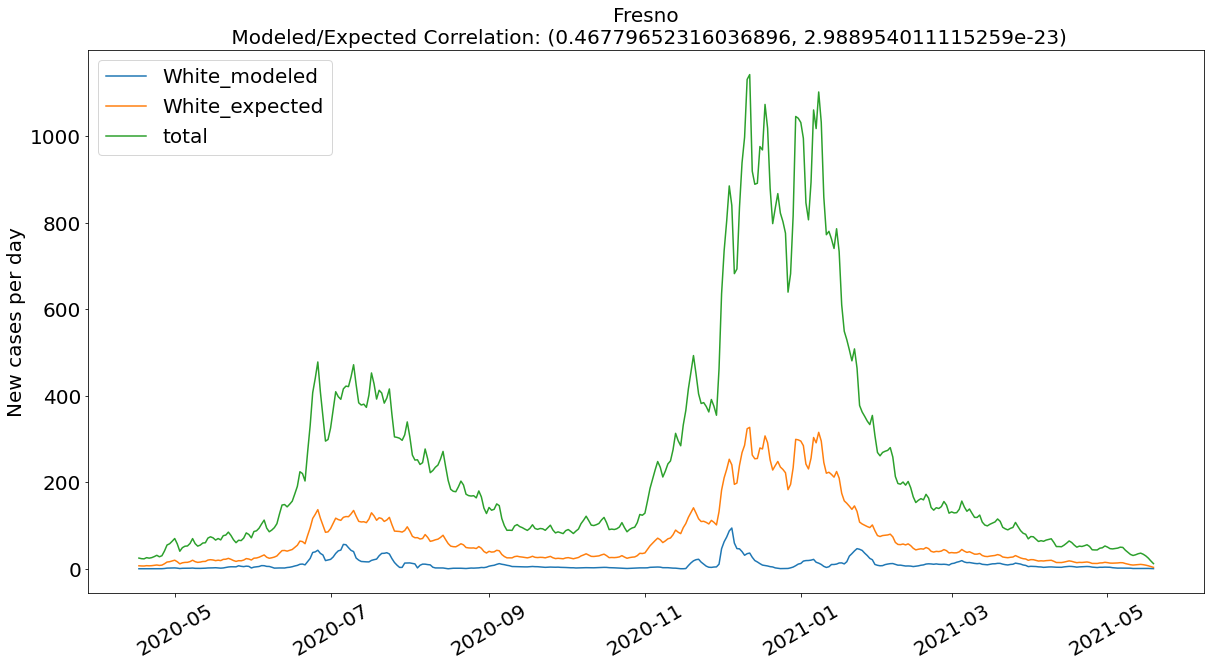

TESTING visualization Model vs Expected


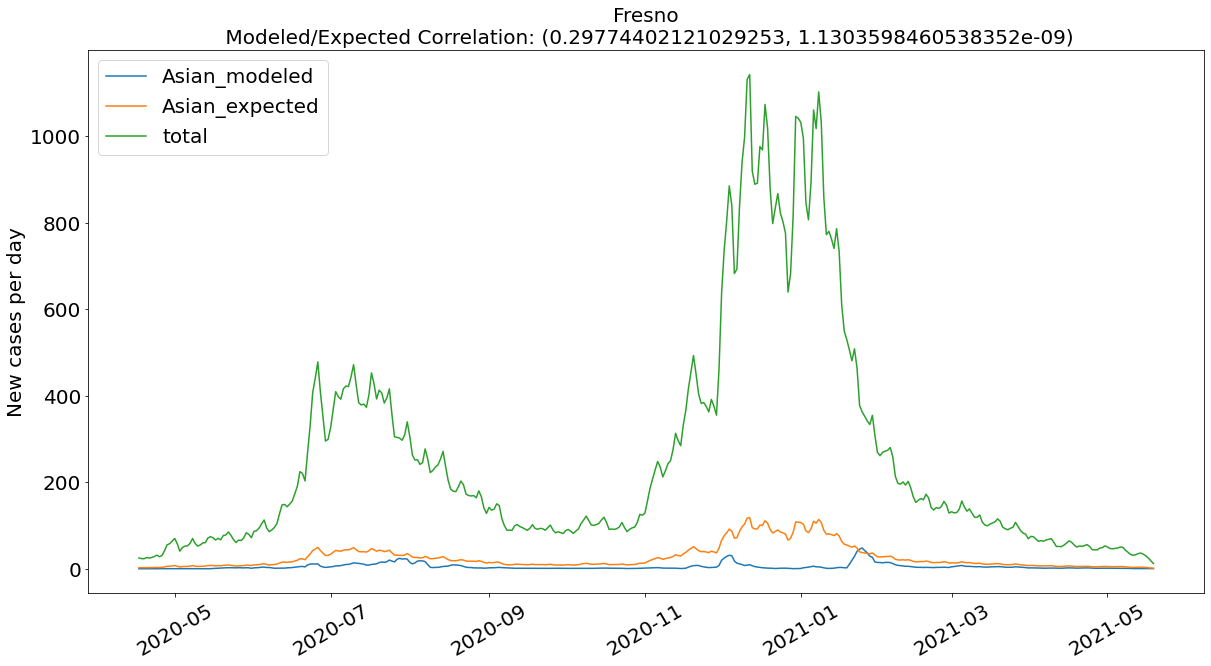

TESTING visualization Model vs Expected


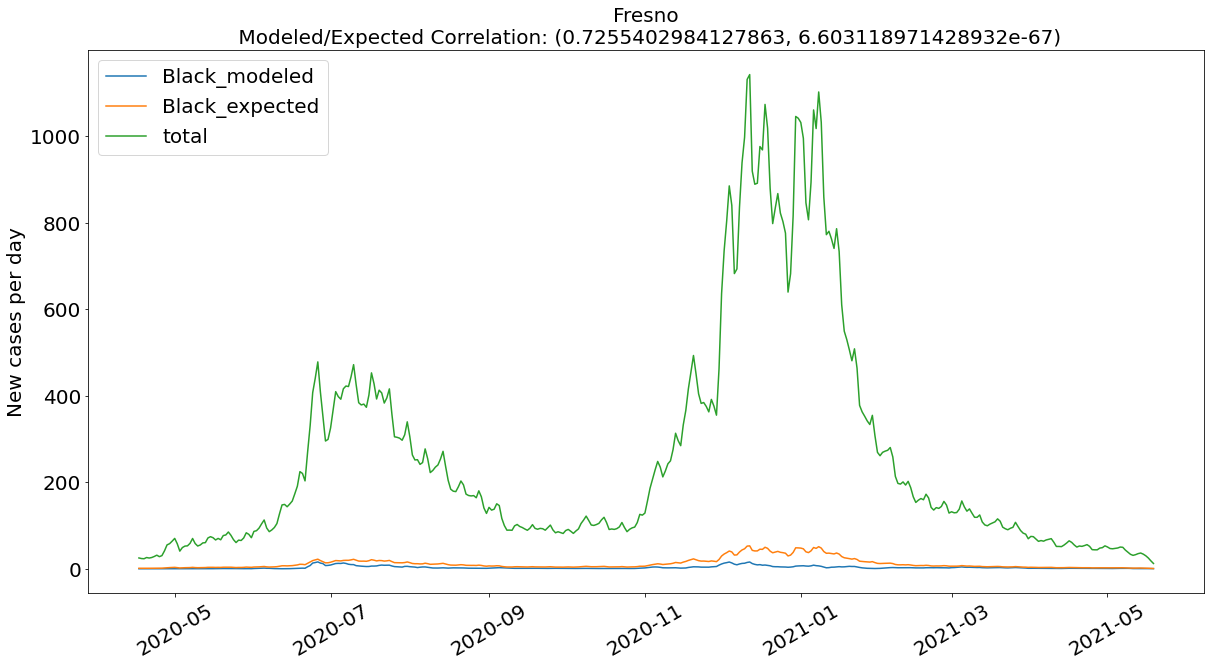

TESTING visualization Model vs Expected


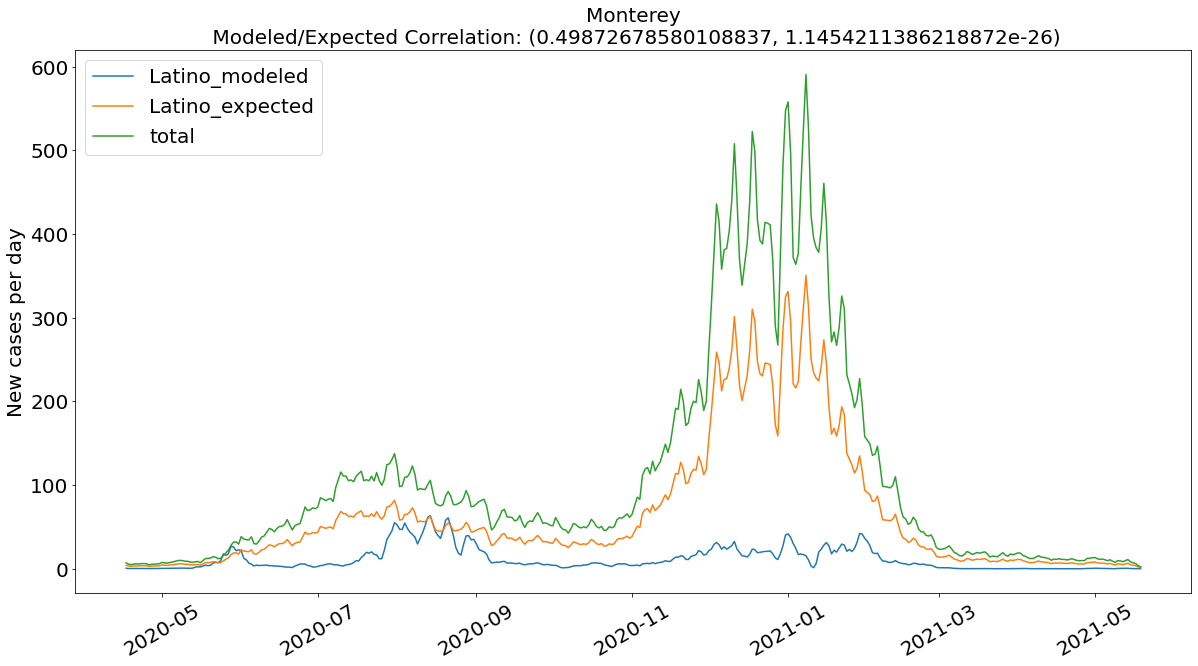

TESTING visualization Model vs Expected


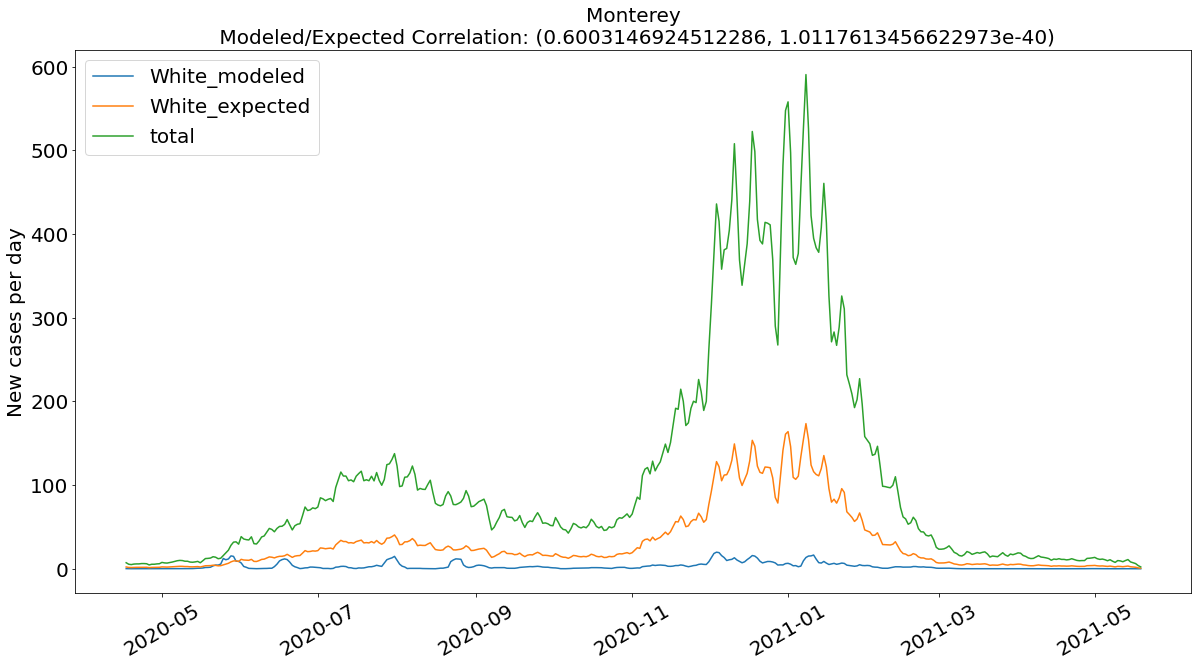

TESTING visualization Model vs Expected


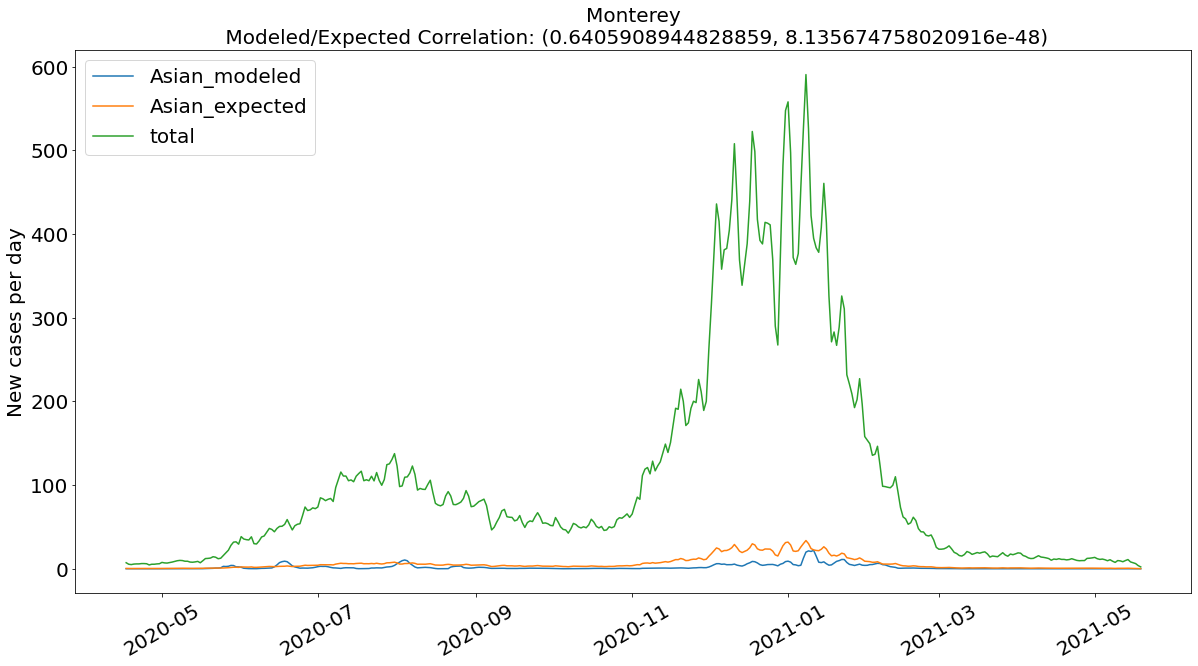

TESTING visualization Model vs Expected


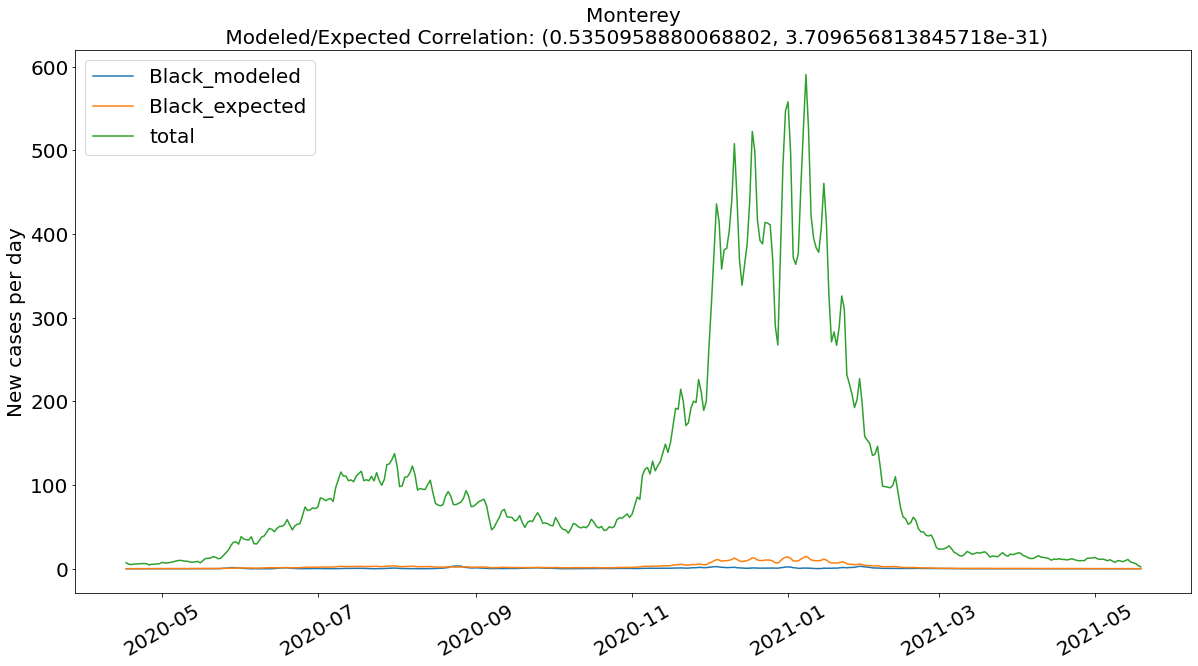

TESTING visualization Model vs Expected


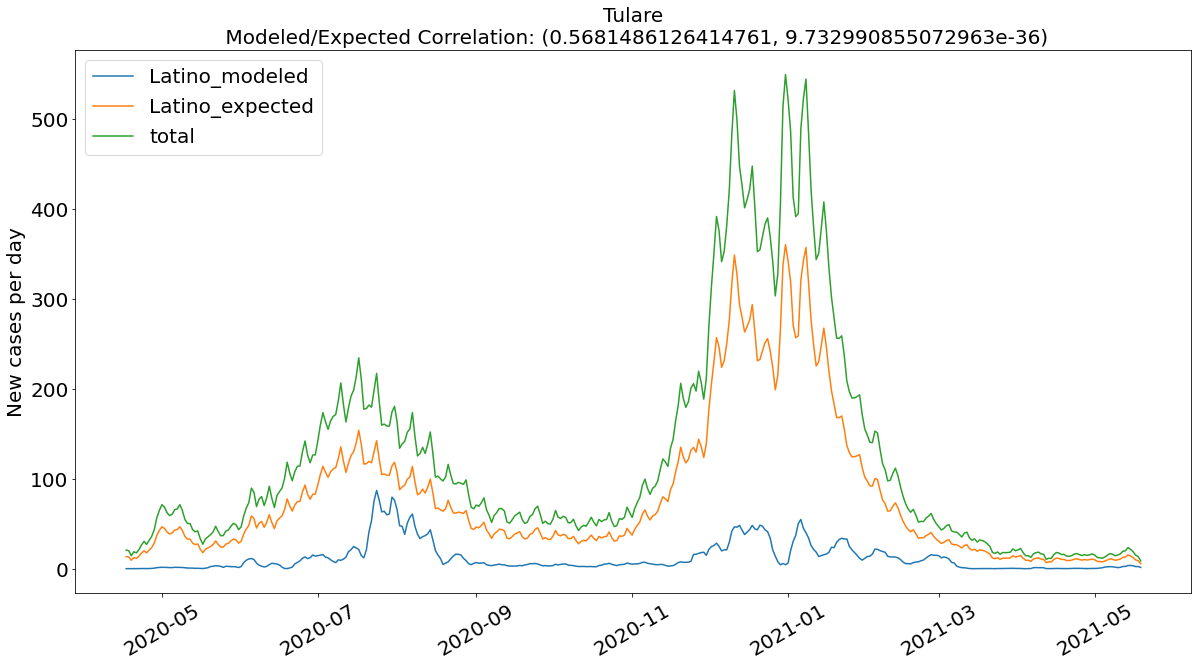

TESTING visualization Model vs Expected


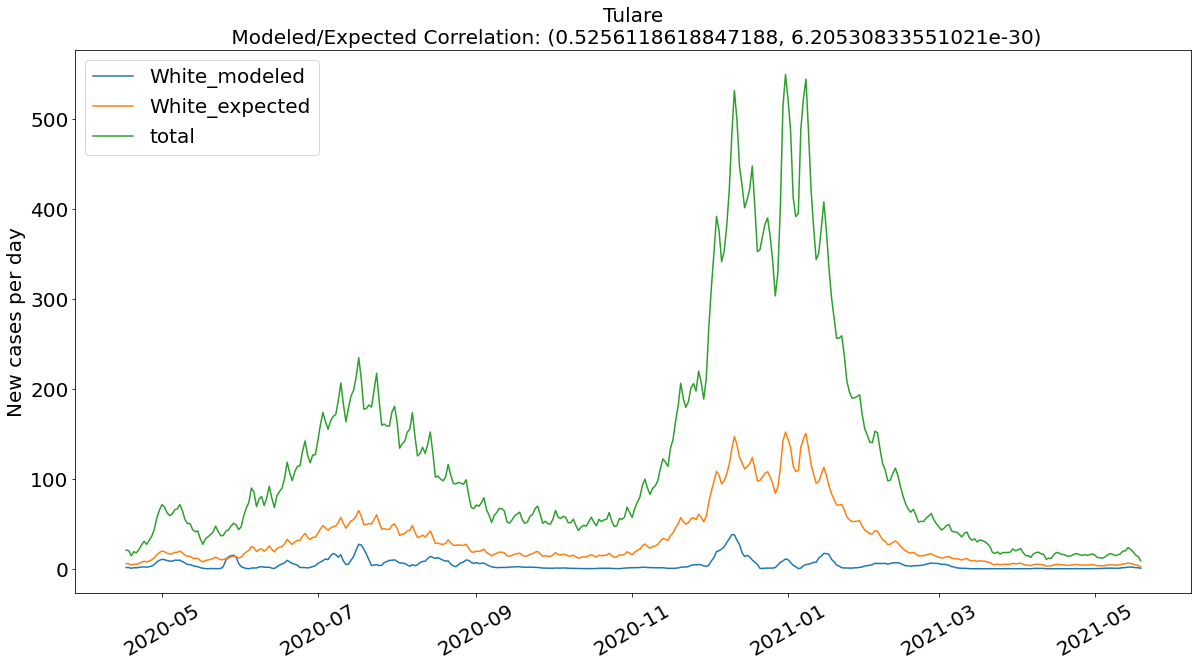

TESTING visualization Model vs Expected


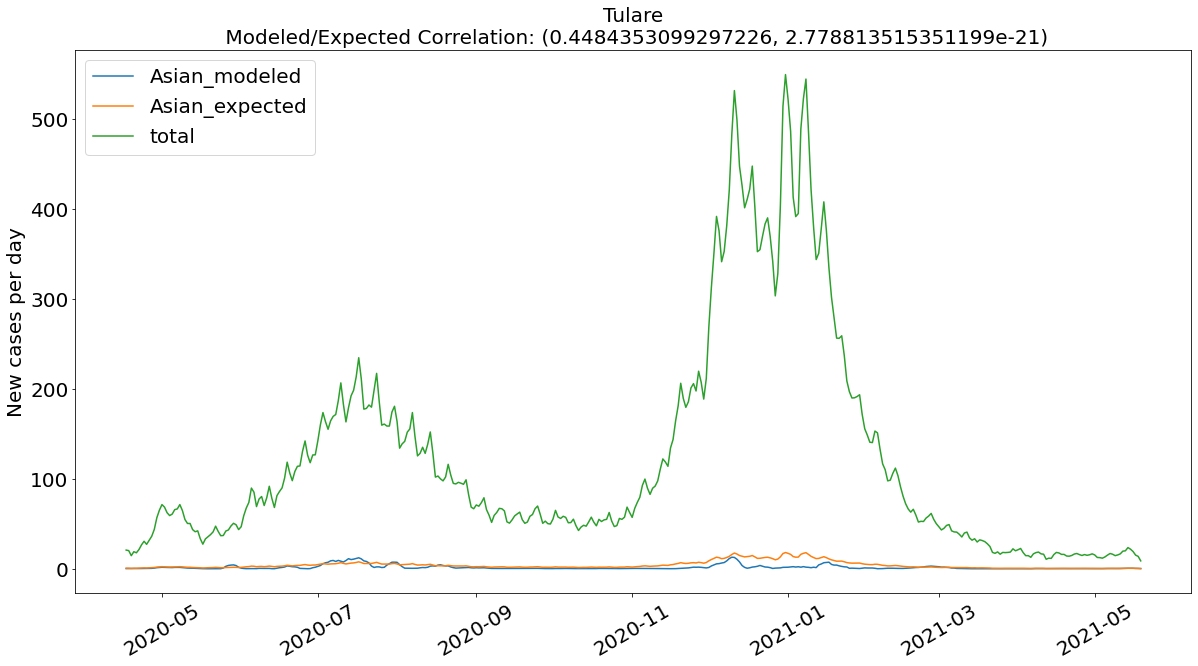

TESTING visualization Model vs Expected
TESTING visualization Model vs Expected


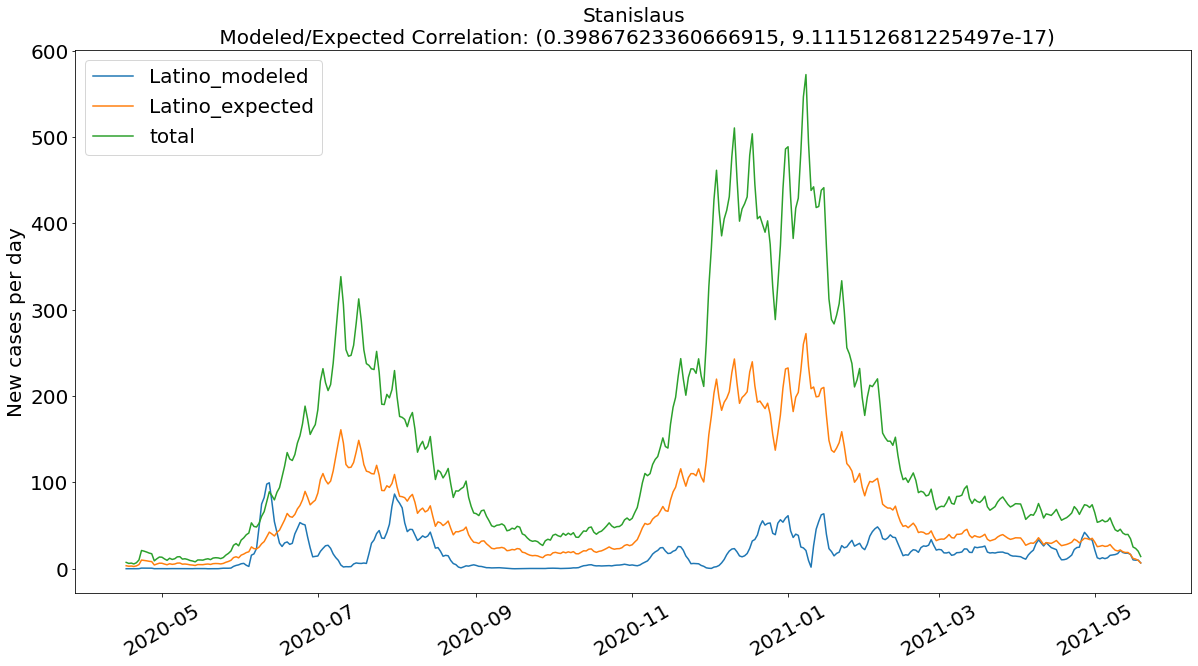

TESTING visualization Model vs Expected


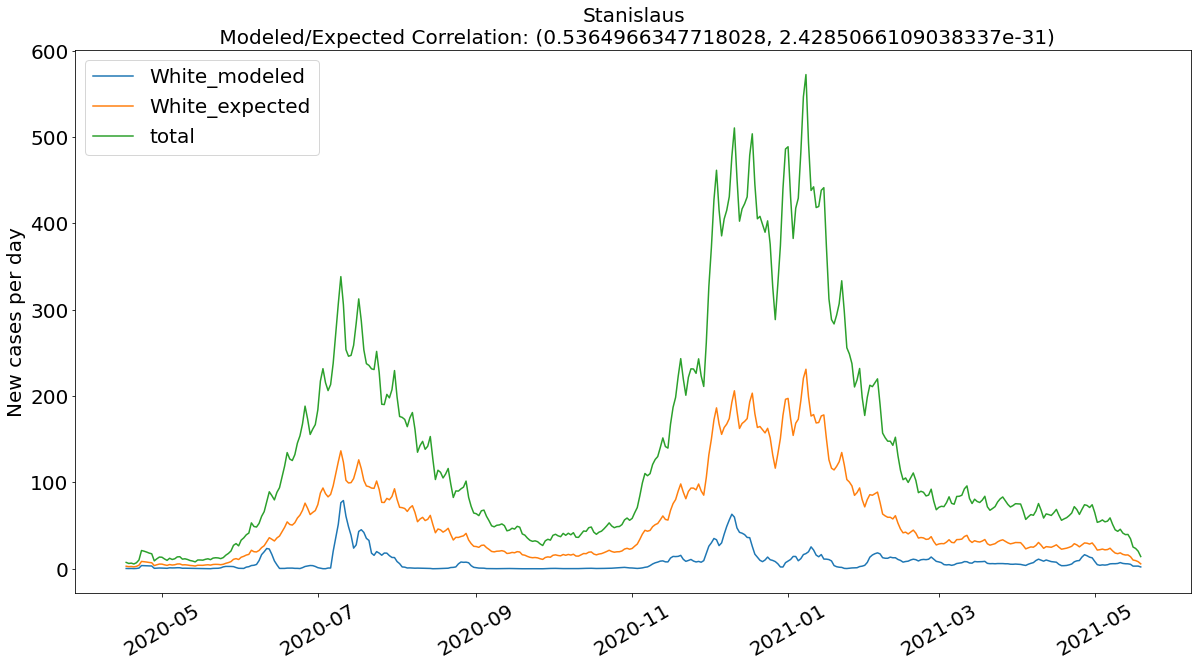

TESTING visualization Model vs Expected


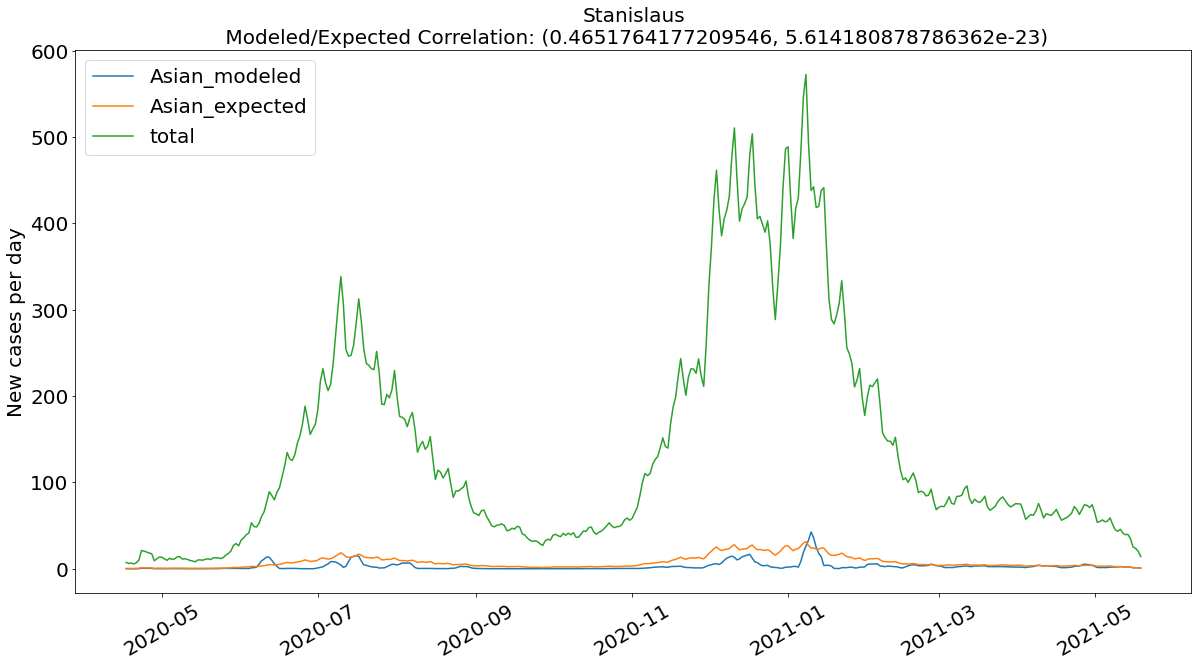

TESTING visualization Model vs Expected
TESTING visualization Model vs Expected


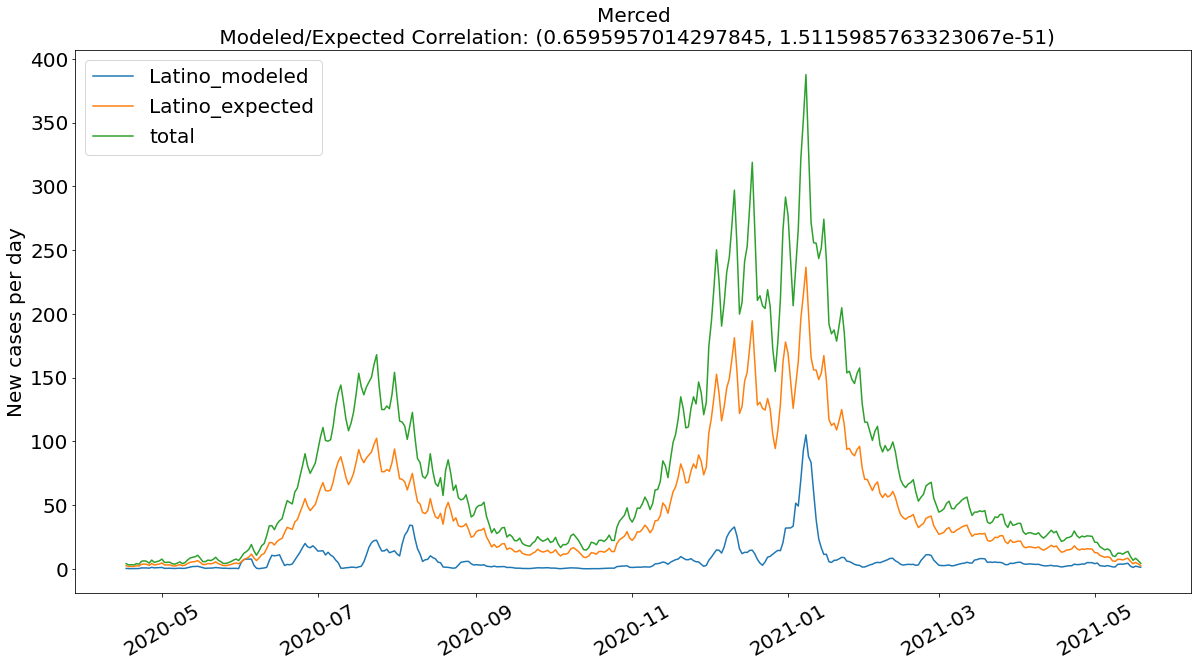

TESTING visualization Model vs Expected


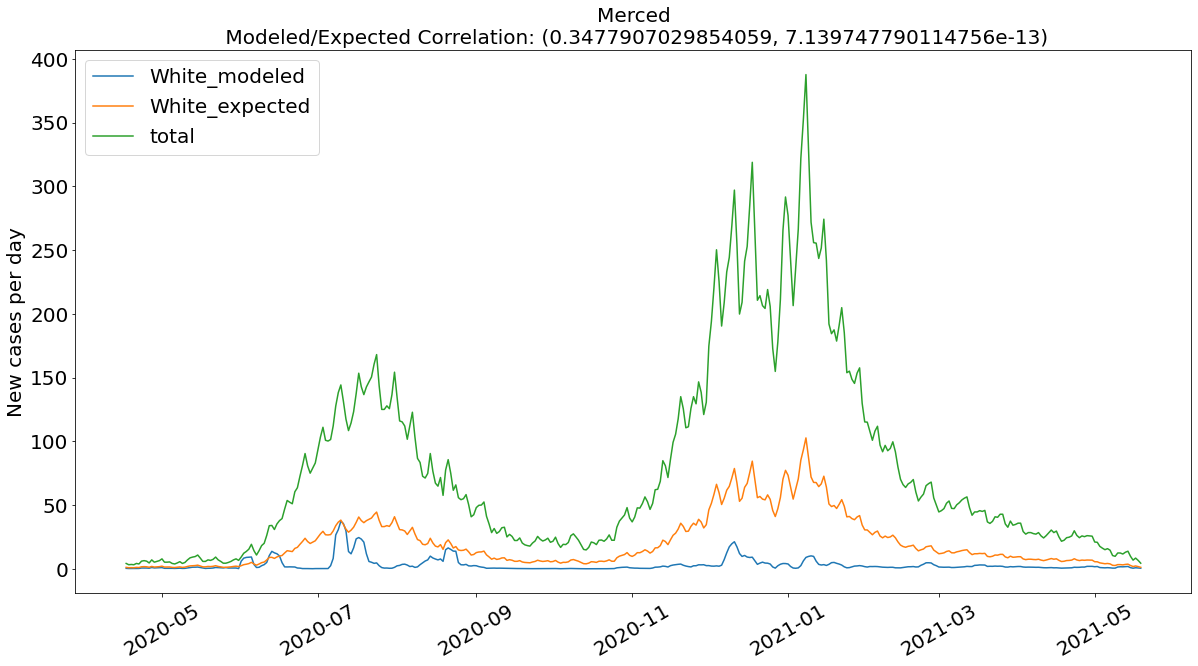

TESTING visualization Model vs Expected


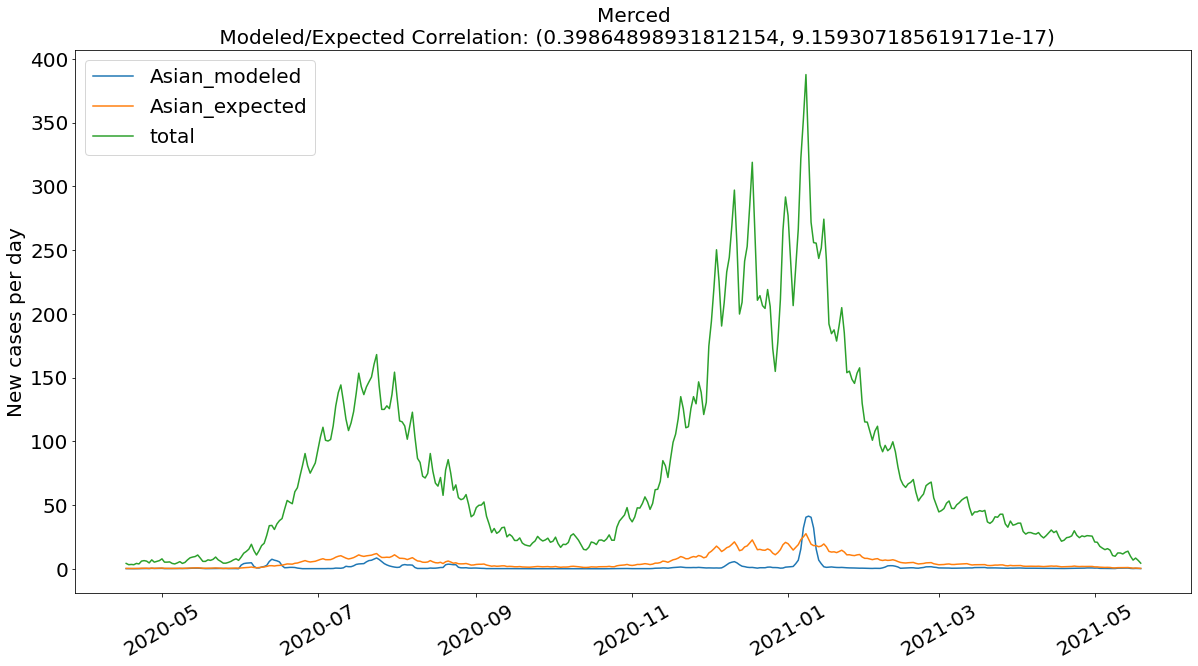

TESTING visualization Model vs Expected
TESTING visualization Model vs Expected


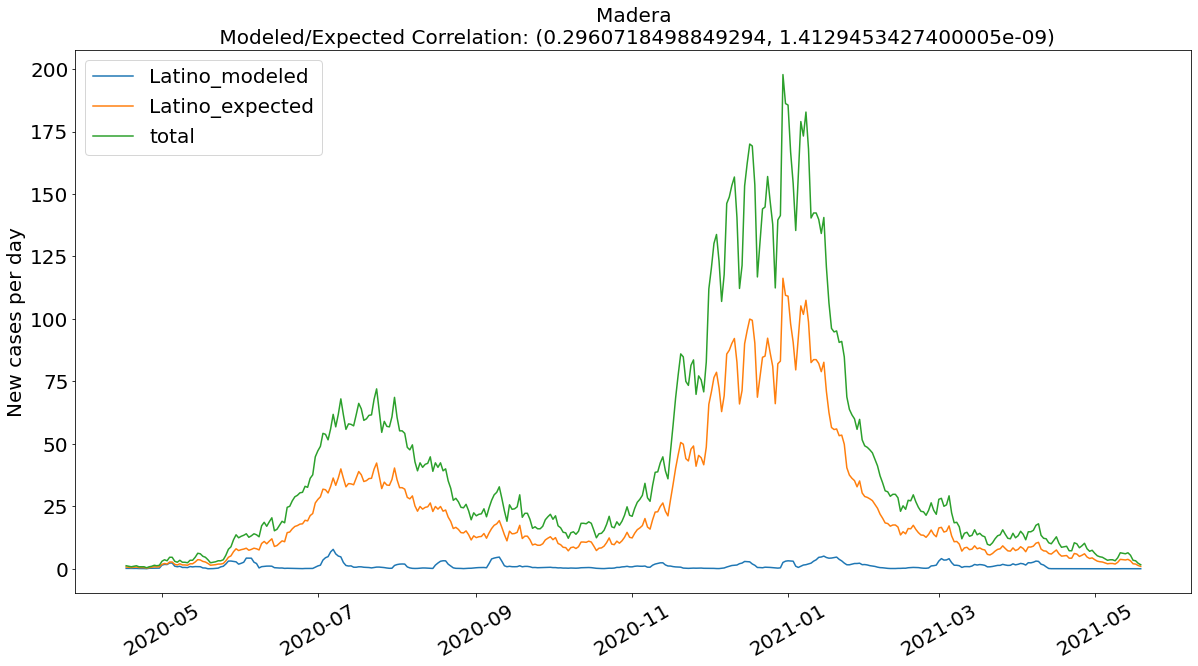

TESTING visualization Model vs Expected


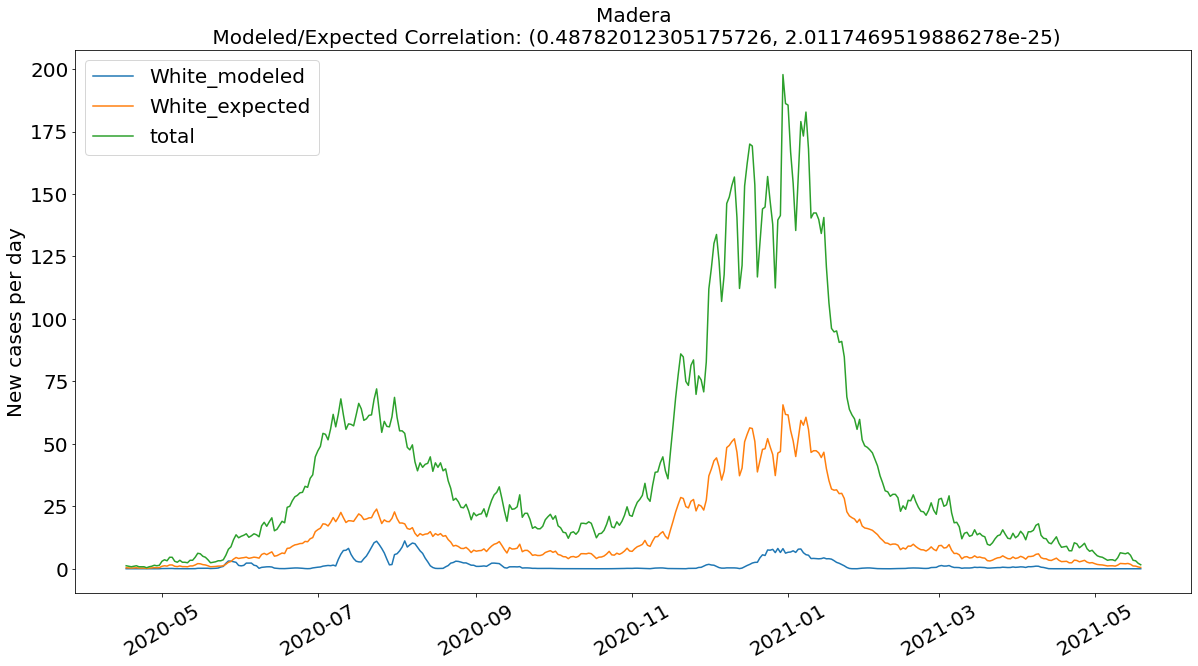

TESTING visualization Model vs Expected
TESTING visualization Model vs Expected
TESTING visualization Model vs Expected


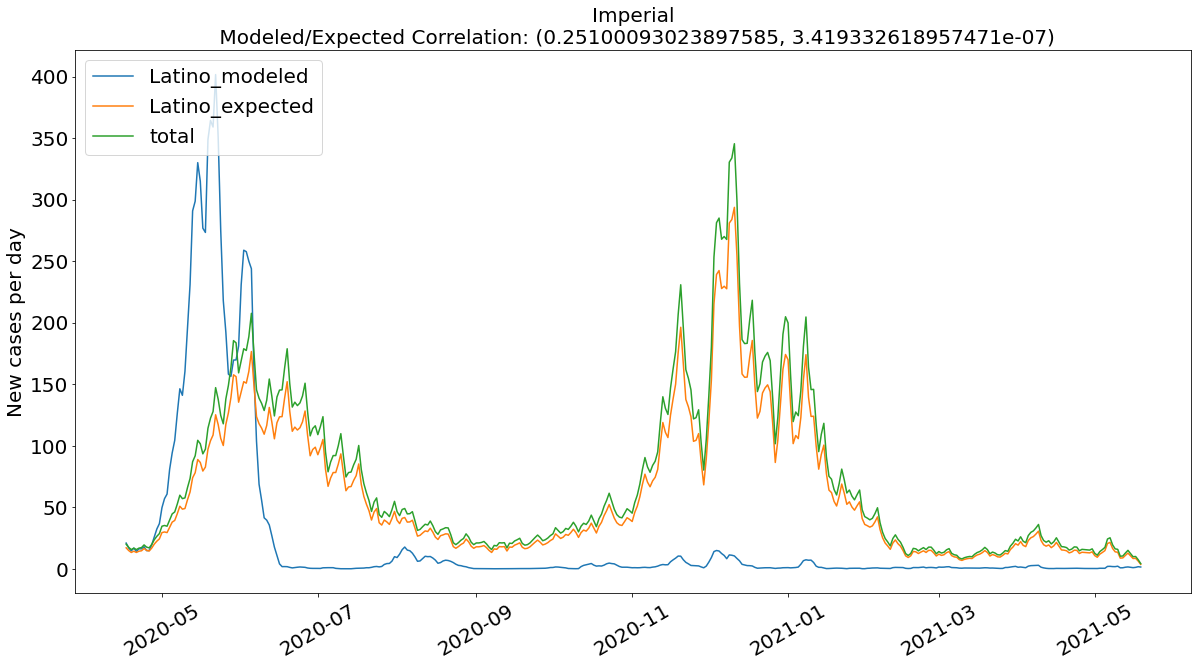

TESTING visualization Model vs Expected


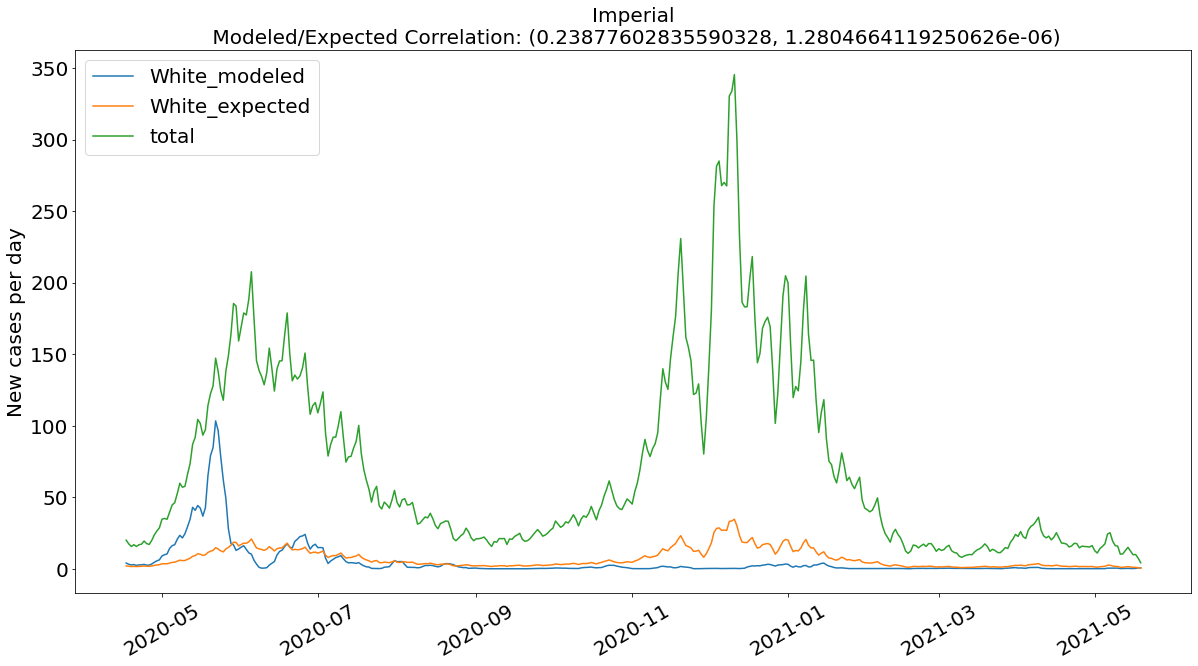

TESTING visualization Model vs Expected
TESTING visualization Model vs Expected


In [45]:
county = 'Los Angeles'
for county in cors_df['county']:   
    
    if county not in high_covid_counties:
        continue
    #//*** Compare the expected vs scaled modeled values
    expected_la = ca_model_cases_df[ca_model_cases_df['county']== county]
    
    
    modeled_la = modified_race_total[['date','race',county]]
    #modeled_la = v2_ca_case_race_total_df[['date','race',county]]
    
    modeled_la = ca_case_race_total_df[['date','race',county]]

    for race in ['Latino','White',"Asian","Black"]:
        print("=======================================")
        print("TESTING visualization Model vs Expected")
        print("=======================================")

        
        loop_model_race = modeled_la[modeled_la['race']==race]

        loop_model_expected = expected_la[['date','county',race,f"case_{race}",f"adj_{race}","cases"]]
        
        #//*** Skip Columns where the Max cases is less than 20. These values are a bit unreliable
        if loop_model_expected[f"case_{race}"].max() < 20:
            continue
        #loop_model_race = modeled_la[modeled_la['race']==race]

        #loop_model_expected = expected_la[['date','county',race,f"case_{race}",f"adj_{race}","cases"]]
        #print("Correlation: ", county, " ",race, " ",pearsonr(loop_model_race[county],loop_model_expected['cases']))
        
        #//*** Cases per 100k should be relatively similar in values.
        display_size = 20
        fig,ax = plt.subplots(figsize=(20,10))

        ax.plot(loop_model_race['date'],loop_model_race[county].rolling(5).mean(),label=f"{race}_modeled")
        ax.plot(loop_model_expected['date'],loop_model_expected[f"case_{race}"].rolling(5).mean(),label=f"{race}_expected")
        ax.plot(loop_model_expected['date'],loop_model_expected[f"cases"].rolling(5).mean(),label=f"total")

        plt.xticks(rotation=30,fontsize=display_size)
        plt.yticks(fontsize=display_size)
        handles,labels = deduplicate_legend(ax)
        plt.legend(fontsize=display_size,loc='upper left')
        plt.title(f"{county}\n Modeled/Expected Correlation: {(pearsonr(loop_model_race[county],loop_model_expected['cases']))}",fontsize=display_size)
        plt.ylabel("New cases per day",fontsize=display_size)
        plt.show()

        

#//*** Temp variable cleanup
del expected_la
del modeled_la
del loop_model_expected
del loop_model_race

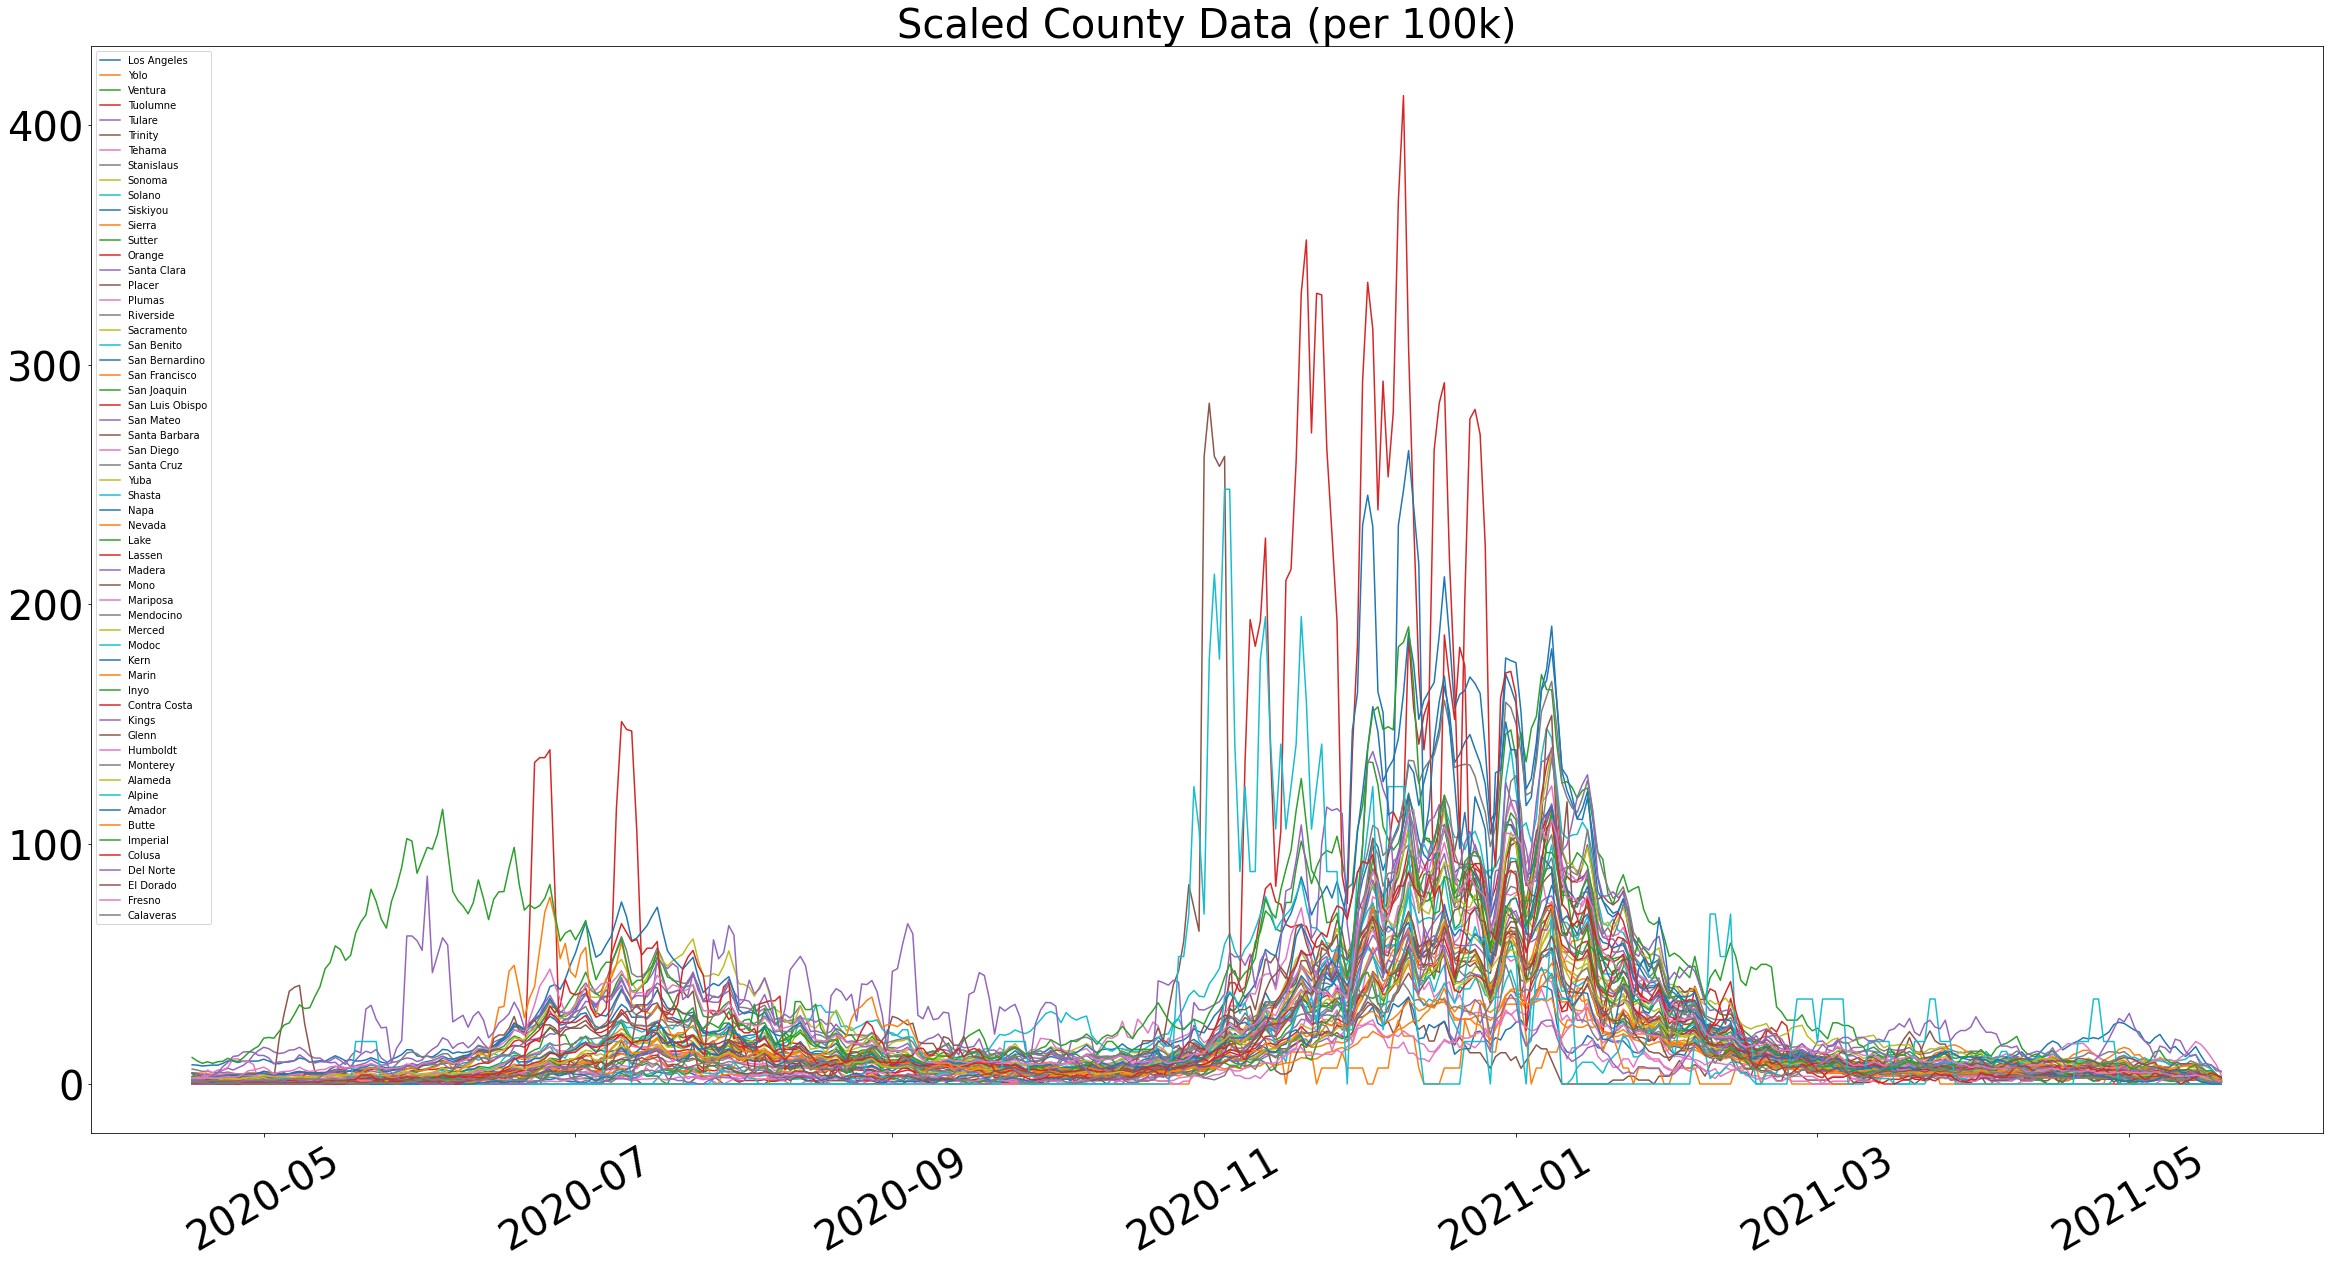

In [46]:
#//*** Merge Population Attributes with COVID County info
#//*** Only Merge if we haven't merged yet. I got 99 iPython problems but this aint one.
if "Latino" not in ca_covid_df.columns:
    ca_covid_df = pd.merge(ca_covid_df,pop_attrib_df,how="left",on=['county'])


#//*** Build per 100k Stats
ca_100k_df = ca_covid_df.copy()

#//*** Define Population Columns to convert to 100k. These Columns shouldn't change. Trying to setup a flexible
#//*** Systems where I can add other attributes later if needed
population_cols = [ 'population','Latino', 'White', 'Asian', 'Black', 'Native', 'Hawaiian','Multiracial' ]

#//*** Convert Popultion values to 100k units. ie divide by 100,000
for col in population_cols:
    ca_100k_df[col] = ca_100k_df[col]/100000



#//*** Convert cases, deaths, test to per 100k units
attrib_cols = ['date','county']

#//*** Ignore values in attrib_cols, and population_cols
#//*** Convert remianing attributes to values per 100,000.
#//*** This method makes it easier to change the 100k attributes later.
for col in ca_100k_df.columns:
    if col not in attrib_cols and col not in population_cols:
        #//*** Convert column to per 100k value. Which is Columns value divided population per 100k
        ca_100k_df[col] = ca_100k_df[col]/ca_100k_df['population'] 


#//*** Check our Work.
#//*** Cases per 100k should be relatively similar in values.
display_size = 40
fig,ax = plt.subplots(figsize=(40,20))

for county in ca_100k_df['county'].unique():
    
    loop_df = ca_100k_df[ca_100k_df['county'] ==  county]
    ax.plot(loop_df['date'],loop_df['cases'].rolling(5).mean(),label=county)


    plt.xticks(rotation=30,fontsize=display_size)
    plt.yticks(fontsize=display_size)
handles,labels = deduplicate_legend(ax)
plt.legend(fontsize=display_size*.25,loc='upper left')
plt.title(f"Scaled County Data (per 100k)",fontsize=display_size)
#plt.ylabel("Total Cases by County (millions)",fontsize=display_size)
plt.show()



In [47]:
print(ca_cases_broad_df['Madera'].sum())

for group in ca_case_race_total_df.groupby('race'):
    cols = group[1].columns[4:]
    print(group[0])
    print(group[1][['Los Angeles','Madera']])


16437.0
Asian
     Los Angeles    Madera
402   160.472727  0.000030
403   168.459625  0.000125
404   201.910866  0.000024
405   182.310535  0.000000
406   196.132074  0.000095
..           ...       ...
799    28.865252  0.001745
800    19.173250  0.000523
801    32.766570  0.007475
802     1.638275  0.000000
803     0.000000  0.000000

[402 rows x 2 columns]
Black
      Los Angeles    Madera
804     95.410837  0.000328
805     97.809096  0.001338
806    115.214099  0.000250
807    105.406520  0.000000
808    107.588631  0.000959
...           ...       ...
1201    16.507608  0.000958
1202    10.827478  0.000314
1203    18.519729  0.005223
1204     0.800681  0.000000
1205     0.000000  0.000000

[402 rows x 2 columns]
Hawaiian
      Los Angeles    Madera
2010    16.256124  0.001304
2011    18.019638  0.005748
2012    22.553362  0.001141
2013    18.136022  0.000000
2014    21.497000  0.004468
...           ...       ...
2407     2.344206  0.000199
2408     1.563589  0.000052
2409     2.

In [48]:
#//*** Assigns a color from a palette list to a county. 
def assign_color(input_item, input_cd,input_palette):
    #//*** Check if item already exists, if so, return input_cd
    if input_item in input_cd.keys():
        return input_cd
    
    #//*** input_item needs a Color. Walk down the input_palette till one is not found
    for color in input_palette:
        if color not in input_cd.values():
            input_cd[input_item] = color
            return input_cd
    print("UH OH ran out of colors!!!")
    print(f"Item: {input_item}")
    print(input_cd)
    return input_cd

In [49]:
#//*** Color Choices: Tucking these aside for later use
#//*** Combine these with a dictionary to create color continuity across multiple visualizations.
color_palette = ["#c6eaff","#caa669","#14bae2","#f7cd89","#98a9e7","#e2ffb7","#cb9ec2","#77dcb5","#ffc5b7","#40bdba","#fff4b0","#74d0ff","#e4da8d","#7ceeff","#d0e195","#b7ab8c","#fcffdb","#83b88d","#ffe2c0","#abc37a"]
color_palette = ["#557788","#e12925","#44af0e","#7834c0","#726d00","#130c6d","#004e12","#f7007d","#017878","#950089","#00a3d7","#4b000e","#0063c2","#f07478","#013b75","#cf81b8","#212238","#af87e7","#320f49","#9c91db"]
county_color_palette = ["#b4a23b","#4457ca","#9ec535","#a651cb","#59ce59","#6a77f0","#52a325","#b93d9b","#36b25c","#e374d4","#c1c035","#7452af","#96ae3a","#a484e2","#89c466","#e54790","#57c888","#dd3d60","#5bd6c4","#dd4e2d","#45ccdf","#bd3738","#4cb998","#b13a6c","#368433","#588feb","#dcad3d","#4763af","#e49132","#4aa5d4","#c86321","#7695d3","#769233","#925898","#54701c","#c893d6","#3d7b44","#e084ac","#65a76b","#965179","#296437","#e57f5f","#31a8ad","#a44b2c","#368d71","#df7f81","#226a4d","#96465f","#b5b671","#68649c","#ad772e","#a34f52","#758348","#d8a06e","#505e25","#8e5e31","#8e8033","#695f1b"]
county_color_palette = ["#96465f","#dd3d60","#df7f81","#a34f52","#bd3738","#dd4e2d","#e57f5f","#a44b2c","#c86321","#8e5e31","#d8a06e","#e49132","#ad772e","#dcad3d","#b4a23b","#8e8033","#695f1b","#c1c035","#b5b671","#96ae3a","#505e25","#758348","#9ec535","#769233","#54701c","#52a325","#89c466","#368433","#59ce59","#3d7b44","#65a76b","#296437","#36b25c","#57c888","#226a4d","#368d71","#4cb998","#5bd6c4","#31a8ad","#45ccdf","#4aa5d4","#7695d3","#588feb","#4763af","#6a77f0","#4457ca","#68649c","#a484e2","#7452af","#a651cb","#c893d6","#925898","#e374d4","#b93d9b","#965179","#e084ac","#e54790","#b13a6c"]
county_color_palette = ["#226a4d","#31a8ad","#68649c","#758348","#505e25","#368d71","#4aa5d4","#965179","#7695d3","#45ccdf","#296437","#96465f","#8e5e31","#b5b671","#d8a06e","#a34f52","#5bd6c4","#695f1b","#4cb998","#df7f81","#3d7b44","#e084ac","#c893d6","#65a76b","#8e8033","#925898","#4763af","#54701c","#ad772e","#a44b2c","#e57f5f","#769233","#57c888","#b13a6c","#588feb","#a484e2","#b4a23b","#368433","#89c466","#7452af","#96ae3a","#dcad3d","#bd3738","#36b25c","#e374d4","#c86321","#b93d9b","#e49132","#dd3d60","#e54790","#c1c035","#4457ca","#6a77f0","#52a325","#9ec535","#dd4e2d","#a651cb","#59ce59"]

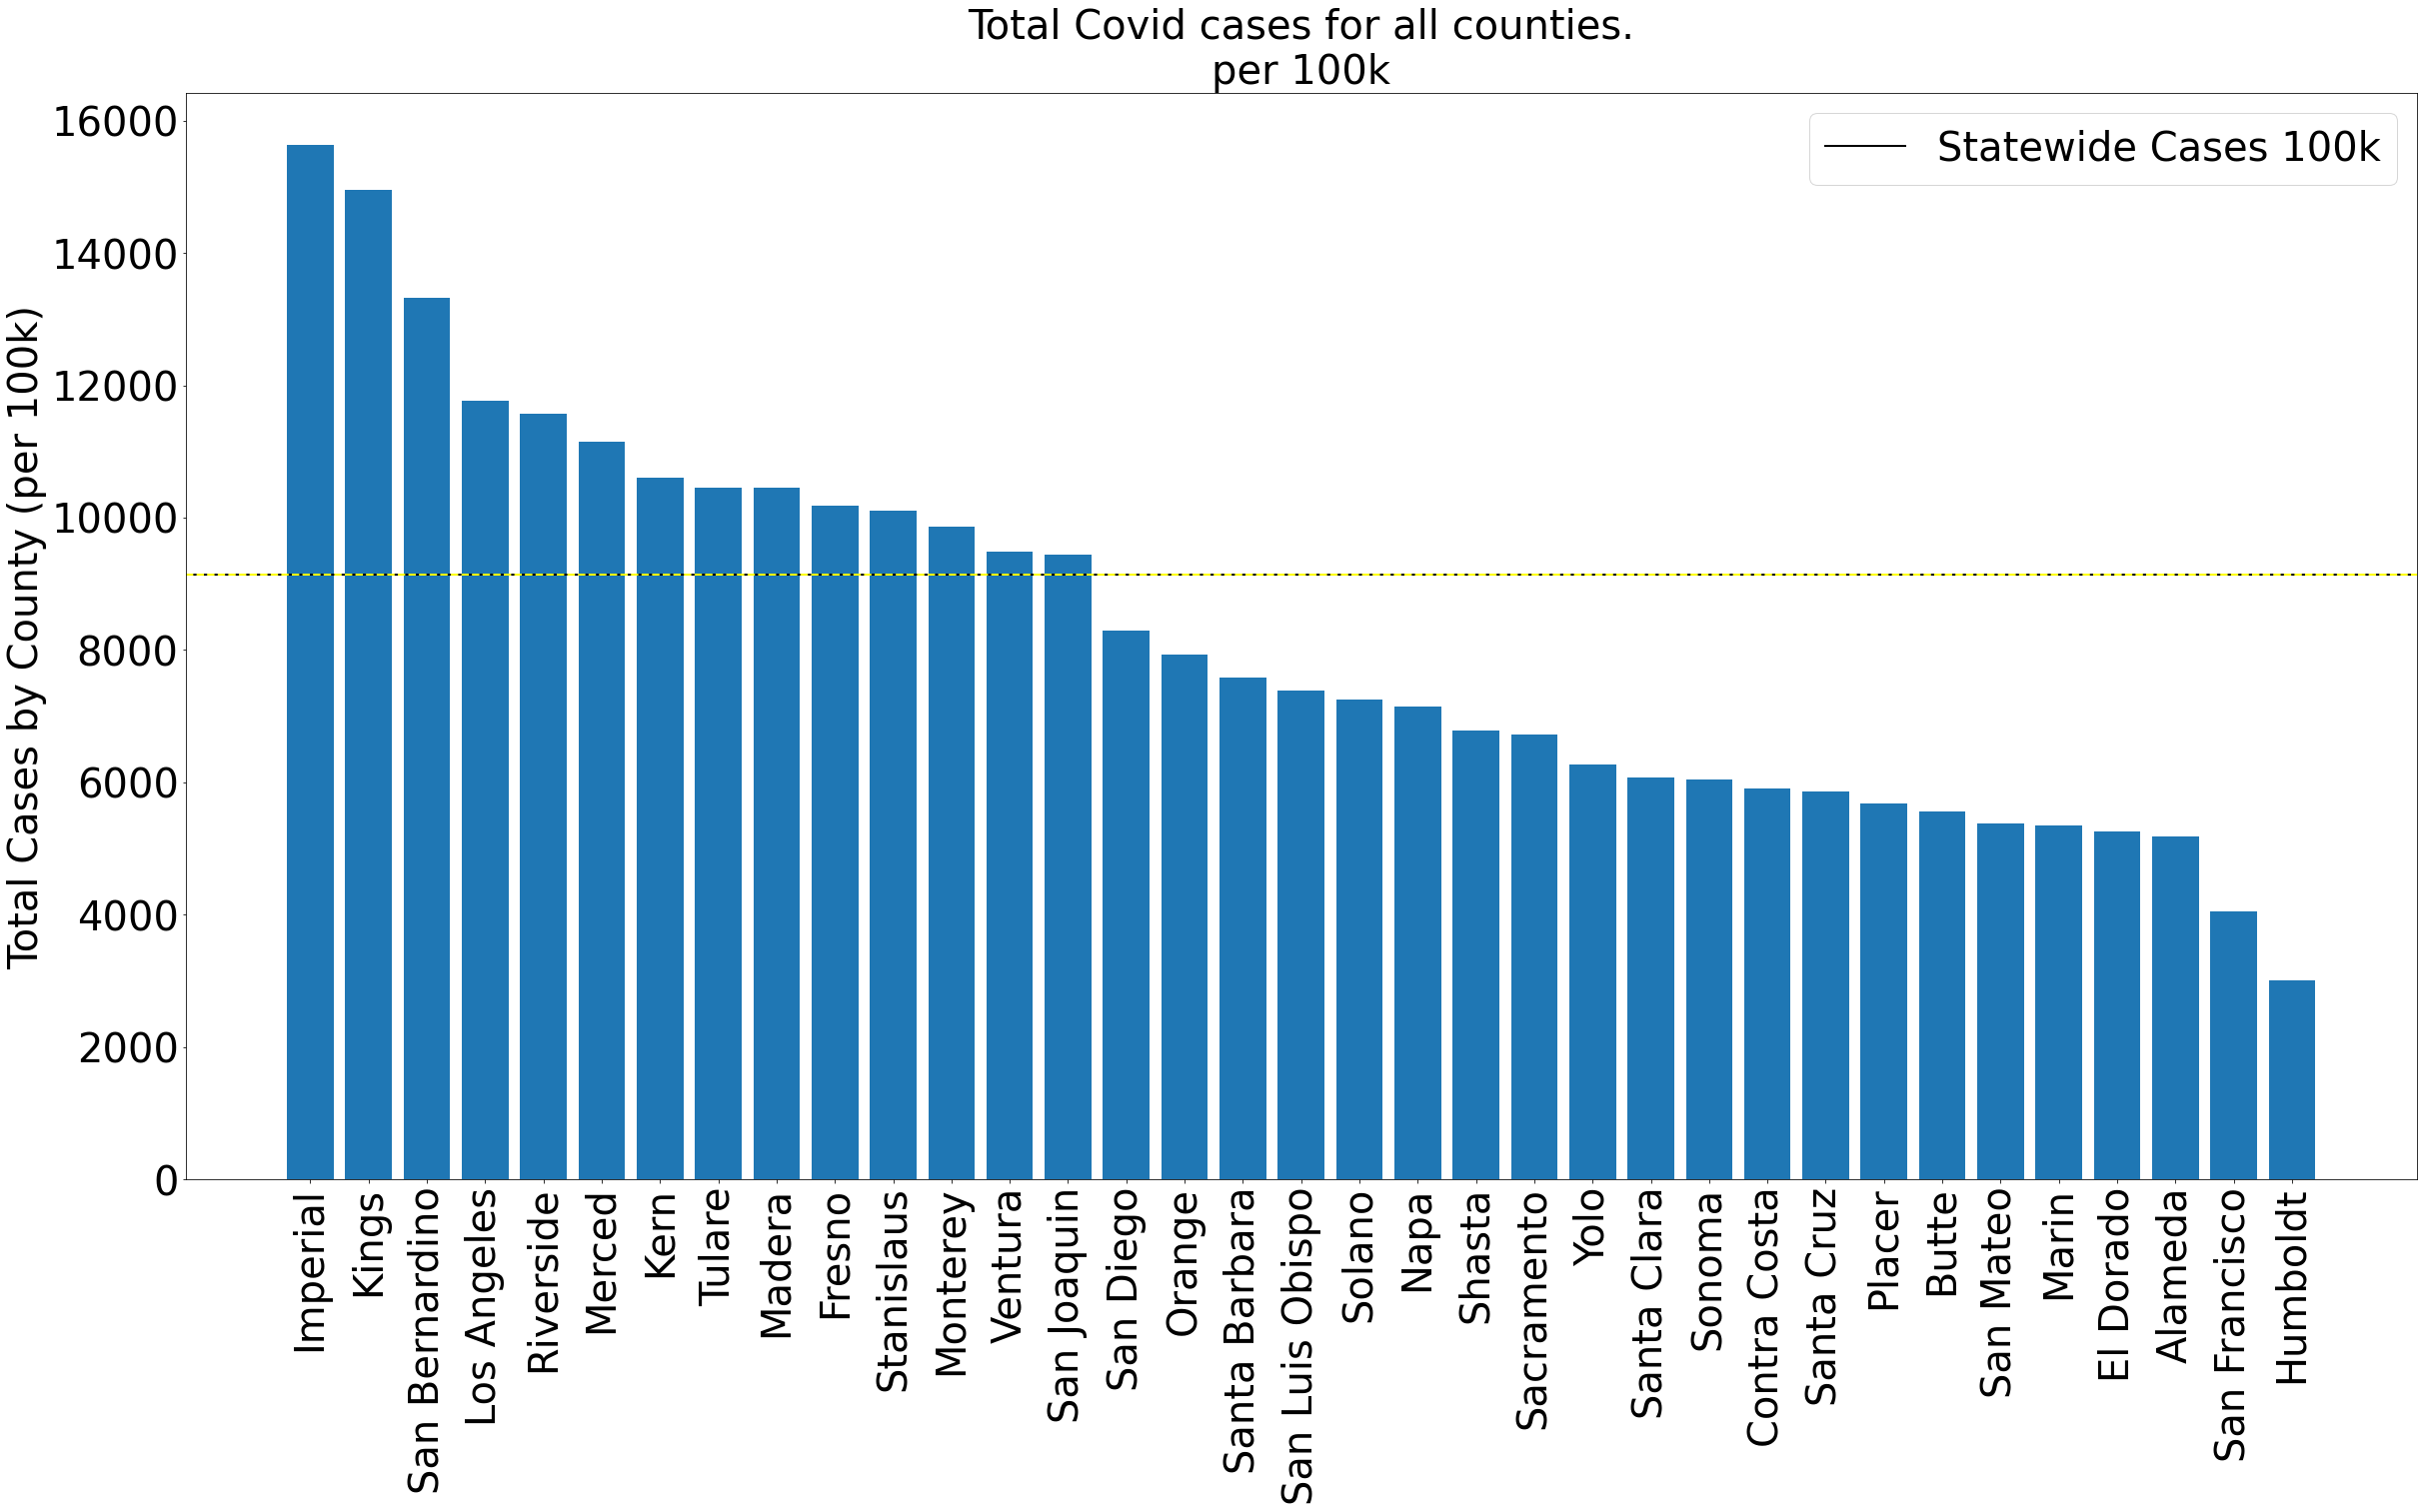

In [50]:


display_size = 40

fig,ax = plt.subplots(figsize=(display_size,display_size/2))

ax.bar(ts.index,ts)

#//*** Draw horizontal line. Draw it twice to get the yellow and back effect. 
#//*** This technique looks viusually good, but I can't get the legend to draw approrpriately.
ax.axhline(state_100k,color = "black", label="Statewide Cases 100k", linestyle = "-", lw=2)
ax.axhline(state_100k,color = "yellow", linestyle = "--", lw=2)
        
plt.xticks(rotation=90,fontsize=display_size)
plt.yticks(fontsize=display_size)

handles,labels = deduplicate_legend(ax)

plt.legend(fontsize=display_size,loc='upper right')
plt.title(f"Total Covid cases for all counties.\nper 100k",fontsize=display_size)
plt.ylabel("Total Cases by County (per 100k)",fontsize=display_size)
plt.show()

In [51]:
#//*** Look at total County COVID numbers by county rates per 100k.


#//*** Get the last data


#for county in






#last_day_df = rd[race_list[0]][rd[race_list[0]]['date'] == last_date]

In [52]:
"""
#//*** Convert Racial percentages into estimated COVID cases per county
ca_case_race_total_df = pd.DataFrame()

if 'ca_case_race_total_df' not in df_list:
    df_list.append('ca_case_race_total_df')
    
case_county_index = 4
x_column = ca_case_race_percent_df.columns[case_county_index:]
    
#//*** Loop through each day in ca_case_race_percent_df
for group in ca_case_race_percent_df.groupby('date'):
    
    loop_df = group[1].copy()
    #print(loop_df[x_column])
    
    this_day = ca_cases_broad_df[ca_cases_broad_df['date']==group[0]].copy()
    
    loop_df['intercept'] = this_day['total'].values[0]
    
    #//*** Keep just the county columns
    this_day = this_day[this_day.columns[2:]]
    
    loop_df[x_column]= (loop_df[x_column]*this_day.values).astype(int)
    
    
    ca_case_race_total_df = pd.concat([ca_case_race_total_df,loop_df])

print(ca_case_race_total_df)
#//*** Temp Variable Cleanup
del loop_df
del this_day
"""
print()


In [53]:
"""
#//*** Version 1: Generate Coefficients from the model

#//*** This works on one variable at a time. Keeping this for reference. 
#//*** Will use builder function.

#//***************************************************************************************************************************************************************************
#//*** Generatate a Individual Race Coeffecients for each county per day.
#//*** The the sum of racial coefficients should equal the state coefficent for the county. 
#//***************************************************************************************************************************************************************************
from sklearn.preprocessing import StandardScaler

#//*** Build the coefficients for the entire data set. Each day will calculate the coefficients from the previous 30 days. The First 30 days will use one set of coeffients. The rest will use
#//*** The current day: -30 to generate the coefficients. This will be an overfitted solution which is exactly what we are going for.
start_time = time.time()
#//*** Abstract Dataframes to Left and Right for reusability
left_df = ca_races_broad_df
right_df = ca_cases_broad_df

#//*** Get Coefficients for counties predicting the State total Case values
output_df = pd.DataFrame()

#//*** County Columns start at Index 3
x_col_index = 3

#//*** Target Independent Column Index. Statewide race numbers begin at column 1
y_col_index = 1

#//*** Sample size
#modeling_days = 30


print("Calculating racial coefficients...")
#//*** Combining with car_race_df and Latino value. It's not strictly needed, but the additional column will make combining the dataframes later, easier.
#//*** Reusing Code: This loop only needs to run once
for race in left_df.columns[1:]:
    
    #//*** Build model for the first 30 days, combines the race from ca_race (which is only needed as an extra field, to evenly space the columms)
    model_df = left_df[['date',race]].merge(right_df, left_on='date', right_on='date')[:30]
    
    #//*************************
    #//*** BEGIN regression
    #//*************************
    
    
    #//**** Build the x Values - Dependent Variables. These will be all the counties which start at the column index 
    #//*** The X Value is the index where the attributes start, there are 58 of them :)
    #x_column = model_df.columns[x_col_index:]
    
    #//*** Generate ordered list of Counties by current race population.
    #//*** The assumptions is the counties with higher populations will exert a greater weight on the model.
    #//*** Otherwise the tiny county of Alpine gets way overly represented
    race_columns = (pop_attrib_df[['county',race]].sort_values(race,ascending=False)['county'])

    #print(model_df[race_columns])
    #//*** Build the X attributes using the x_column. These are separated for readability and modularity
    x_model = model_df[race_columns]

    #print(x_model)
    #//*** Build the independent variable using the Index Column defined above as y_col_index.
    y_column = model_df.columns[y_col_index]
    
    #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
    #//*** easily assigned at the top of this section
    y_model = model_df[y_column]
    
    #//*** Define the Linear Model
    regr = linear_model.LinearRegression(n_jobs=-1)
    
    #//*** Make Regression Magic
    regr.fit(x_model, y_model)
    
    #//*** Apply the regression coefficients
    model_df[race_columns] = (model_df[race_columns])*regr.coef_
    
    

    #//*** Replace the Statewide Total Column. With the Statewide Race Totals
    model_df['total'] = model_df[race]
    
    #//*** Change The race column to hold the race name
    model_df[race] = race
    
    #//*** Rename the race (Latino, Native, etc) to 'race'
    cols = list(model_df.columns)
    cols[1] = 'race'
    model_df.columns = cols
    
    model_df['intercept'] = regr.intercept_

    #//*** Move intercept to be the column after Total
    #//*** Gets Columns as a list, removes intercept of end and inserts into position
    #//*** Model_df is saved with ordered list of columns.
    #//*** Kinda Cool
    model_df = model_df[ list(model_df.columns[:-1].insert(3,'intercept')) ]

    #//*** Reorder Counties
    #//*** Keep the First four Columns, then use ordered_counties
    model_df = model_df[list(model_df.columns[:4])+ordered_counties]
    
    #print(model_df)
    #//*** Add the First 30 days Model to the output_df dataframe
    output_df = pd.concat([output_df,model_df])

    #//*** Checking our work. The sum of the coefficients * cases + intercept should be close the independent value in Total Cases.
    print("Checking our Work. These values should be close:")
    print(model_df.iloc[1]['total'], " == ", model_df[x_column].iloc[1].sum()+regr.intercept_)    
     
   
    #//*** Build each day individually, based on the previous 30 days
    #//*** Start at index 31 
    for index in range(31,len(left_df)):
        
        #//*** Define the start and indexes for linear modeling. This is the row_index - 30
        min_index = index-30
        
        #//*** Build model_df using min_index and index as a 30 day range)
        model_df = left_df[['date',race]].merge(right_df, left_on='date', right_on='date')[min_index:index]
        
        #//*** Build the X attributes using the x_column. These are separated for readability and modularity
        x_model = model_df[race_columns]

        #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
        #//*** easily assigned at the top of this section
        y_model = model_df[y_column]

        #//*** Build a New the Linear Model
        regr = linear_model.LinearRegression(n_jobs=-1)

        #//*** Make Regression Magic
        regr.fit(x_model, y_model)

        #//*** Replace the Statewide Total Column. With the Statewide Race Totals
        model_df['total'] = model_df[race]

        #//*** Change The race column to hold the race name
        model_df[race] = race

        #//*** Rename the race (Latino, Native, etc) to 'race'
        cols = list(model_df.columns)
        cols[1] = 'race'
        model_df.columns = cols

        #//*** Apply the regression coefficients to all columns, even though we only need the last one
        model_df[race_columns] = (model_df[race_columns])*regr.coef_
        model_df['intercept'] = regr.intercept_

        #//*** Move intercept to be the column after Total
        #//*** Gets Columns as a list, removes intercept of end and inserts into position
        #//*** Model_df is saved with ordered list of columns.
        #//*** Kinda Cool
        model_df = model_df[ list(model_df.columns[:-1].insert(3,'intercept')) ]

        #//*** Reorder Counties
        #//*** Keep the First four Columns, then use ordered_counties
        model_df = model_df[list(model_df.columns[:4])+ordered_counties]

        #//*** Add the last day of model_df to output_df. 
        #//*** It's not exactly efficient, but it is functional
        #output_df = pd.concat([output_df,model_df.iloc[-1]])
        output_df = output_df.append(model_df.iloc[-1])

processing_df = output_df.copy()

del output_df
print("Done")
"""
print()


In [54]:
"""
#//**** Archived Reference in case I muck it up

#//************************************************
#//*** Convert Coefficients to percentages
#//************************************************
#//*** Racial Coefficients are built for each race by day and county.
#//*** Group output_df by date, to calculate the race percent for each county by day.
#//*** The Racial Percentage is

print(f"CoEfficients Calculated: {round(time.time()-start_time,0)}s")
start_time = time.time()

x_col_index = 4
x_column = model_df.columns[x_col_index:]
output2_df = pd.DataFrame()
for group in output_df.groupby('date'):
    
    #//*** Make a coopy of sliced dataframe. This prevents index errors
    loop_df = group[1].copy()
    
    #//*** Avoid Divide by zero errors and replace 0 with 1. When processed 0's will become 0.142857, which can be replace with 0 again
    loop_df = loop_df.replace(0,1)
    
    #//*** Each racial row of coefficints summed + intercept will equal the racial total for the day.
    #//*** The relavtive weights of each racial coefficient need to be converted in to percentages.
    #//*** Coefficients are positive and negative. Which adds a challenge of calculating weights which is usually value/sum. 
    #//*** If values are negative, it disrupts the sum. The solution is to sum the absolute value of the coefficients. Percentages are calculated as value/ abs().sum()
    
    
    
    #print((abs(loop_df[x_column])/max_val).sum())
    loop_df[x_column] = (abs(loop_df[x_column])/abs(loop_df[x_column]).sum())
    
    #//*** replace the exactly even percentage distributions with 0's. These were the initially 0's replaced with 1's
    loop_df = loop_df.replace(.14285714285714285,0)
    output2_df = pd.concat([output2_df,loop_df])
    #print(loop_df)

    
ca_case_race_percent_df = output2_df.copy().fillna(0)

ca_case_race_percent_df.index = np.arange(0,len(ca_case_race_percent_df))

print(f'Racial Percentages Calculated: {round(time.time()-start_time,0)}s')
print(ca_case_race_percent_df)
if 'ca_case_race_percent_df' not in df_list:
    df_list.append('ca_case_race_percent_df')
#//*** Temp Variable Cleanup
#del output_df
#del output2_df
#del loop_df
#del model_df
"""
print()


In [55]:
"""
if 'state_coef_df' not in df_list:
    df_list.append('state_coef_df')
    
#//*** Generate Coefficients for the State - Orphaned Code
#//***************************************************************************************************************************************************************************
#//*** Generatate a State Coeffecient. These are best used to check our work.
#//*** The State Coeefficients are useful for comparing the sum of racial coefficients. If the regressions are consistent, the state coefficient should be close to the 
#//*** sum of the racial coeffificents
#//***************************************************************************************************************************************************************************

#//*** Build the coefficients for the entire data set. Each day will calculate the coefficients from the previous 30 days. The First 30 days will use one set of coeffients. The rest will use
#//*** The current day: -30 to generate the coefficients. This will be an overfitted solution which is exactly what we are going for.

#//*** Abstract Dataframes to Left and Right for reusability
left_df = ca_races_broad_df
right_df = ca_cases_broad_df

#//*** Get Coefficients for counties predicting the State total Case values
output_df = pd.DataFrame()

#//*** County Columns start at Index 3
x_col_index = 3

#//*** Target Independent Column Index. Statewide numbers begin at column 2
y_col_index = 2

#//*** Sample size
#modeling_days = 30

#//*** Combining with car_race_df and Latino value. It's not strictly needed, but the additional column will make combining the dataframes later, easier.
#//*** Reusing Code: This loop only needs to run once
for race in ['Latino']:
    
    #//*** Build model for the first 30 days, combines the race from ca_race (which is only needed as an extra field, to evenly space the columms)
    model_df = left_df[['date',race]].merge(right_df, left_on='date', right_on='date')[:30]
    #print(model_df)
    
    #//*************************
    #//*** BEGIN regression
    #//*************************
    
    #//**** Build the x Values - Dependent Variables. These will be all the counties which start at the column index 
    #//*** The X Value is the index where the attributes start, there are 58 of them :)
    x_column = model_df.columns[x_col_index:]

    #//*** Build the X attributes using the x_column. These are separated for readability and modularity
    x_model = model_df[x_column]
    

    #//*** Build the independent variable using the Index Column defined above as y_col_index.
    y_column = model_df.columns[y_col_index]
    
    #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
    #//*** easily assigned at the top of this section
    y_model = model_df[y_column]
    
    #//*** Define the Linear Model
    regr = linear_model.LinearRegression()
    
    #//*** Make Regression Magic
    regr.fit(x_model, y_model)

    #//*** Apply the regression coefficients
    model_df[x_column] = (model_df[x_column])*regr.coef_
    
    #//*** Add the First 30 days Model to the output_df dataframe
    output_df = pd.concat([output_df,model_df])
    
    #//*** Checking our work. The sum of the coefficients * cases + intercept should be close the independent value in Total Cases.
    print("Checking our Work. These values should be close:")
    print(model_df.iloc[1]['total'], " == ", model_df[x_column].iloc[1].sum()+regr.intercept_)    

    #//*** Build each day individually, based on the previous 30 days
    #//*** Start at index 31 
    for index in range(31,len(left_df)):
        
        #//*** Define the start and indexes for linear modeling. This is the row_index - 30
        min_index = index-30
        
        #//*** Build model_df using min_index and index as a 30 day range)
        model_df = left_df[['date',race]].merge(right_df, left_on='date', right_on='date')[min_index:index]
        
        #//*** Build the X attributes using the x_column. These are separated for readability and modularity
        x_model = model_df[x_column]

        #//*** Build the Y model using the y_column attribute. This is less readable and intuitive, but it lets the columns be 
        #//*** easily assigned at the top of this section
        y_model = model_df[y_column]

        #//*** Build a New the Linear Model
        regr = linear_model.LinearRegression()

        #//*** Make Regression Magic
        regr.fit(x_model, y_model)

        #//*** Apply the regression coefficients to all columns, even though we only need the last one
        model_df[x_column] = (model_df[x_column])*regr.coef_
        model_df[model_df.columns[1]] = regr.intercept_
        #//*** Add the last day of model_df to output_df. 
        #//*** It's not exactly efficient, but it is functional
        #output_df = pd.concat([output_df,model_df.iloc[-1]])
        output_df = output_df.append(model_df.iloc[-1])
        
        
state_coef_df = output_df.copy()
state_coef_df.columns = [ ['date','intercept','total'] + list(x_column) ]
print("State Coef")
print(state_coef_df)
if 'state_coef_df' not in df_list:
    df_list.append('state_coef_df')
#//*** Eliminate lingering temp variables
del output_df
del model_df
"""
print()


In [56]:
"""
#//*** Version 1: Covert Coefficients to percentages

#//************************************************
#//*** Convert Coefficients to percentages
#//************************************************
#//*** Racial Coefficients are built for each race by day and county.
#//*** Group output_df by date, to calculate the race percent for each county by day.
#//*** The Racial Percentage is

start_time = time.time()



x_col_index = 4
x_column = model_df.columns[x_col_index:]
output2_df = pd.DataFrame()

break_counter = 0
for row in processing_df.iterrows():
    

    loop_row = row[1]
    
    
    total = row[1][2]
    #print("Total: ",total)
    intercept = row[1][3]
    #print("Intercept: ",total-intercept)
    loop_row[4:] = loop_row[4:]
    #x_range = loop_row[4:].max() - loop_row[4:].min()
    #x_range = total - loop_row[4:].min()
    #print("x_norm: ", x_norm)
    #print((loop_row[4:]-min_val)/x_range)
    
    #loop_row[4:] = loop_row[4:].replace(0,1)
    #print(loop_row[4:].sum())
    
    #//*** ABSOLUTE Value method
    #loop_row[4:] = abs(loop_row[4:])/abs(loop_row[4:]).sum()
    
    #//*** Find double the minimum value. This is the offset value.
    #//*** Used to make negative values positive
    offset_value = abs(loop_row[4:].min()*2)
    
    #//*** The total offset which is added to all the values.
    #//*** The Offset_total has to be added to the maximum value in order to keep the proportions correct
    offset_total = offset_value*len(loop_row[4:])
    
    #print("Offset: ",offset_total)

    
    #//*** If all values were positive and there was no need for adjusted, the max value would be the loop_row['total'] 
    #//*** Max_value is calculated as Race Total (loop_row['total']) + offset_total - intercept.
    #//*** We can verify this value by compaing it to the sum() of all the values.
    max_value = (loop_row['total'] + offset_total) - loop_row['intercept']
    #print(loop_row['date']," ", loop_row['race'],"- [",max_value, " == ",(loop_row[4:]+offset_value).sum(), "] [ 1 == ", ((loop_row[4:]+offset_value)/max_value).sum(),"]")
    
    
    
    #//*** Calculate the modeled percentage of each caounty's contribution
    #//*** Percentages: value + offset / max_value
    #//*** Case contribution: race total * value + offset / max_value
    #//*** Original formula
    #loop_row[4:] = ((loop_row[4:]+offset_value)/max_value)*loop_row['total']
    
    #//*** Reformulated
    #//*** Square the results to remove negative values
    loop_row[4:] = loop_row[4:]**2
    
    #//*** Divide by the sum to get relative percentages
    loop_row[4:] = loop_row[4:]/loop_row[4:].sum()
    
    #//*** Multiply by the total to get the weighted percentage of racial values
    loop_row[4:] = loop_row[4:]*loop_row['total']
    
    #print((((loop_row[4:]+offset_value)/max_value)*loop_row['total']).sum())
    #print( (loop_row[4:]*loop_row['total']))
    #print(pd.DataFrame(loop_row).transpose())
    #loop_row[4:] = ( (loop_row[4:].pow(2)/ (total+intercept)**2 ).pow(1./2) )
    #print( abs(loop_row[4:]).sum())  
    #print( loop_row[4:])  
    #print(abs((loop_row[4:]/(total))).sum())    
    #min_val = loop_row[4:].min()
    #print("min: ", loop_row[4:].min())
    #//*** Make a coopy of sliced dataframe. This prevents index errors
    #loop_df = group[1].copy()
    

    output2_df = pd.concat([output2_df,pd.DataFrame(loop_row).transpose()])
    #print(loop_row['total'])
    #print(loop_row)
    break_counter = break_counter + 1
    
#    if break_counter > 250:
#        print(loop_row[4:].sum())
#        print(loop_row)
#        break
    
    
ca_case_race_total_df = output2_df.copy().fillna(0)

ca_case_race_total_df.index = np.arange(0,len(ca_case_race_total_df))

print(f'Racial Percentages Calculated: {round(time.time()-start_time,0)}s')
print(ca_case_race_total_df)
if 'ca_case_race_total_df' not in df_list:
    df_list.append('ca_case_race_total_df')
#//*** Temp Variable Cleanup
#del output_df
#del output2_df
#del loop_df
#del model_df
"""
print()

In [57]:
"""
100k Modeling is a fail

#ca_broad_race_100k_df
#ca_broad_cases_100k_df
#ca_case_race_100k_df

t_date = ca_case_race_100k_df.iloc[random.randint(0,len(ca_case_race_100k_df))]['date']
t_total = ca_case_race_100k_df[ca_case_race_100k_df['date']==t_date]['total']

print(t_date)

tdf1 = ca_broad_cases_100k_df[ca_broad_cases_100k_df['date']== t_date]
print(tdf1[tdf1.columns[2:]].transpose().sum())
print("===================")
print(ca_case_race_100k_df[ca_case_race_100k_df['date']==t_date].iloc[3][2])
print(ca_case_race_100k_df[ca_case_race_100k_df['date']==t_date].iloc[3][4:].sum())
print("===================")
print(tdf1)
print("===================")
print("Total COVID cases by Race on this day: ",ca_broad_race_100k_df[ca_broad_race_100k_df['date']==t_date].transpose()[1:].sum().values[0])
print("Total COVID cases by County:           ",tdf1['total'].values[0])
"""
print()

In [58]:
"""
100k Modeling is a fail

#//*** Compare the Modeled County Totals to the Actual Totals. 
for county in ordered_counties:
    #print(county, " Actual: ",ca_cases_broad_df[county].sum(), " - Modeled: ",ca_case_race_total_df[county].sum()   )
    print("A: ",ca_cases_broad_df[county].sum(), " - M: ",round(ca_case_race_100k_df[county].sum(),0), " ", county   )
print(ca_cases_broad_df['Los Angeles'].sum())

print(ca_case_race_total_df['Los Angeles'].sum())
"""
print()

In [59]:
"""
100k Linear Regression is not the way to go.

ca_broad_cases_100k_df = build_broad_county_attribute(ca_100k_df,'cases')

ca_broad_race_100k_df = build_broad_race_attribute(ca_race_df,'cases_100k')
#build_broad_race_attribute

#print(ca_100k_cases_df)

#//************************************************************************************************************************************************************************
#//*** Calculate the coefficients for Racial data for each county day.
#//*** This uses LinearRegression to generate coefficients which are weighted with the county cases of the day.
#//*** Coefficients derive individual counties affect on the whole of racial COVID cases. The idea is to estimate every counties given portion of the racial cases.
#//*** Each race is modeled separately. The coefficients are converted to percentages in the following step
#//************************************************************************************************************************************************************************


#//*** left_df contains the broad racial categories
left_df = ca_broad_race_100k_df

#//*** Right df contains each county as a column, with one value aggregated. Such as raw COVID cases.
right_df = ca_broad_cases_100k_df

#//*** County Columns start at Index 3.
#//*** These values are a little unintuitive, since they are releveant during the function operation. They are used to indicate which columns are used via the first elements index position
x_col_index = 3

#//*** Target Independent Column Index. Statewide race numbers begin at column 1
#//*** These values are a little unintuitive. They are used to indicate which columns are used via the first elements index position
y_col_index = 1

processing_df = calculate_coefficients(left_df,right_df,x_col_index,y_col_index)

#//**** County Column index start
x_col_index = 4

#//*** Convert coefficients to percentages,

ca_case_race_100k_df =coef_to_percent(processing_df,x_col_index)


print(ca_case_race_total_df)
if 'ca_case_race_100k_df' not in df_list:
    df_list.append('ca_case_race_100k_df')

print("Done")
"""
print()